# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


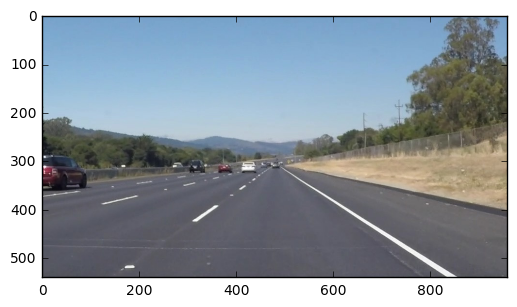

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def x_int(coef_1, intercept_1, coef_2, intercept_2):
    # Returns x-coordinate of intersection of two lines, difference of the intercepts divided by diff of slopes
    x = (intercept_2-intercept_1)/(coef_1-coef_2)
    return x

def draw_LinReg_line(coef, intercept, int_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", int_x)
    point_one = (int(int_x), int(int_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line 
    cv2.line(img, point_one, point_two, color, thickness)

def find_line_fit(slope_intc):
    # slope_intc is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    
    print("Slope & intercept: ", slope_intc)
    
    if len(slope_intc) == 1:
        return slope_intc[0][0], slope_intc[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intc]
    mean_slope = np.mean(slopes)
    std_slope = np.std(slopes)
    for pair in slope_intc:
        slope = pair[0]
        if slope - mean_slope < 1.5 * std_slope:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
        
    # estimate of slope, intercept to be the mean of all values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imshape = img.shape
    
    print("In draw lines")
    
    # Initialise arrays for positive and negative slopes
    positive_slope_pts = []
    negative_slope_pts = []
    positive_slope_intc = []
    negative_slope_intc = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("slope;", slope)
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            
            # if slope is positive, append to the positive slope arrays, if negative, append to the negative arrays
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_pts.append([x1, y1])
                        positive_slope_pts.append([x2, y2])
                        positive_slope_intc.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_pts.append([x1, y1])
                        negative_slope_pts.append([x2, y2])
                        negative_slope_intc.append([slope, y1-slope*x1])
        
    # If either array is empty, do not check for length
    if not positive_slope_pts:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_pts.append([x1, y1])
                    positive_slope_pts.append([x2, y2])
                    positive_slope_intc.append([slope, y1-slope*x1])
                    
    if not negative_slope_pts:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_pts.append([x1, y1])
                    negative_slope_pts.append([x2, y2])
                    negative_slope_intc.append([slope, y1-slope*x1])
                    
          
    # Get intercept and coefficient of fitted lines
    pos_cf, pos_intc = find_line_fit(positive_slope_intc)
    neg_cf, neg_intc = find_line_fit(negative_slope_intc)
    
    # Get intersection point of the two lines to help plot the lines
    int_x = x_int(pos_cf, pos_intc, neg_cf, neg_intc)
    
    # Plot lines
    draw_LinReg_line(pos_cf, pos_intc, int_x, img)
    draw_LinReg_line(neg_cf, neg_intc, int_x, img)
    

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    print("In hough lines")
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

# read an image
def read_image(image_path):
    return mpimg.imread(image_path)

run your solution on all test_images and make copies into the test_images directory).

In hough lines
In draw lines
Slope & intercept:  [[0.55263157894736847, 41.736842105263122], [0.57679180887372017, 32.153583617747415]]
Slope:  0.564711693911 Intercept:  36.9452128615
Slope & intercept:  [[-0.72727272727272729, 663.63636363636363], [-0.83734939759036142, 708.01807228915663], [-0.72988505747126442, 663.58620689655174], [-0.80473372781065089, 695.56804733727813], [-0.75438596491228072, 669.66666666666663]]
Slope:  -0.770725375011 Intercept:  680.095071365
Coef:  0.564711693911 Intercept:  36.9452128615 intersection_x:  481.602520606
Point one:  (481, 308) Point two:  (960, 579)
Coef:  -0.770725375011 Intercept:  680.095071365 intersection_x:  481.602520606
Point one:  (481, 308) Point two:  (0, 680)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ..., 
       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ..., 
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ..., 
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ..., 
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,

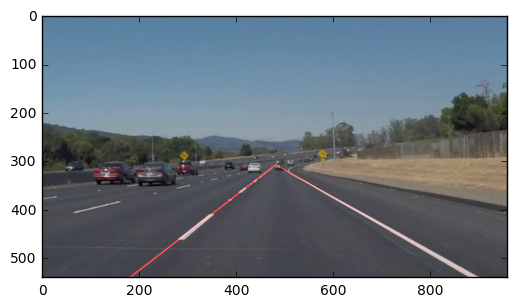

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Save test images to an array
test_images_list = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

def lane_lines(image):
    
    imshape = image.shape
    # Read in and grayscale the image
    image_gray = grayscale(image)
    # plt.imshow(image_gray, cmap='gray')
    
    # Define a kernel size and apply Gaussian smoothing
    # Blur an image to reduce noise
    image_gray_blur = gaussian_blur(image_gray, 5)
    # plt.imshow(image_gray_blur, cmap='gray')
    
    
    # Define our parameters for Canny and apply
    # find the edges in the image
    image_edges = canny(image_gray_blur, 50, 150)
    # plt.imshow(image_edges, cmap='gray')
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_mask = region_of_interest(image_edges, vertices)
    # plt.imshow(edges_image_mask, cmap='gray')
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    
    hough_lines_image = hough_lines(edges_image_mask, rho, theta, threshold, min_line_length, max_line_gap)
    # plt.imshow(hough_lines_image)
        
    # hough_lines_image_rgb = cv2.cvtColor(hough_lines_image, cv2.COLOR_GRAY2BGR)
    # plt.imshow(hough_lines_image_rgb)
    
    image_final = weighted_img(hough_lines_image, image)
    plt.imshow(image_final)
    
    return image_final

lane_lines(test_images_list[0])

In hough lines
In draw lines
Slope & intercept:  [[0.625, 5.875], [0.6512455516014235, -4.1850533807829038], [0.65071770334928225, -4.5454545454545041], [0.62271062271062272, 6.205128205128176]]
Slope:  0.637418469415 Intercept:  0.837405069723
Slope & intercept:  [[-0.67105263157894735, 631.36842105263156], [-0.72222222222222221, 655.83333333333337], [-0.69767441860465118, 639.46511627906978], [-0.70161290322580649, 646.00806451612902], [-0.77272727272727271, 672.90909090909088]]
Slope:  -0.713057889672 Intercept:  649.116805218
Coef:  0.637418469415 Intercept:  0.837405069723 intersection_x:  480.037577693
Point one:  (480, 306) Point two:  (960, 612)
Coef:  -0.713057889672 Intercept:  649.116805218 intersection_x:  480.037577693
Point one:  (480, 306) Point two:  (0, 649)


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ..., 
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ..., 
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ..., 
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ..., 
       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ..., 
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ..., 
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ..., 
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144,

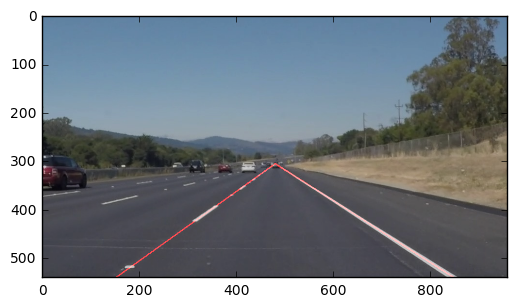

In [6]:
lane_lines(test_images_list[1])

In hough lines
In draw lines
Slope & intercept:  [[0.56060606060606055, 48.121212121212125], [0.56521739130434778, 51.04347826086962]]
Slope:  0.562911725955 Intercept:  49.582345191
Slope & intercept:  [[-0.75367647058823528, 670.89338235294122], [-0.70099667774086383, 645.65448504983385], [-0.70242214532871972, 647.87543252595151], [-0.70099667774086383, 645.95348837209303], [-0.73248407643312097, 664.26114649681529], [-0.73142857142857143, 665.26857142857148]]
Slope:  -0.72033410321 Intercept:  656.651084371
Coef:  0.562911725955 Intercept:  49.582345191 intersection_x:  473.072832487
Point one:  (473, 315) Point two:  (960, 589)
Coef:  -0.72033410321 Intercept:  656.651084371 intersection_x:  473.072832487
Point one:  (473, 315) Point two:  (0, 656)


array([[[ 82, 125, 162],
        [ 82, 125, 162],
        [ 82, 125, 162],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 125, 160],
        [ 82, 125, 160],
        [ 82, 125, 160],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 126, 158],
        [ 82, 126, 158],
        [ 82, 126, 158],
        ..., 
        [ 78, 122, 157],
        [ 77, 120, 155],
        [ 72, 115, 150]],

       ..., 
       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 58,  63,  74],
        [ 58,  63,  74],
        [ 58,  63,  74]],

       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 57,  62,  73],
        [ 57,  62,  73],
        [ 57,  62,  73]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 58,  62,  71],
        [ 58,  62,  71],
        [ 58,  62,

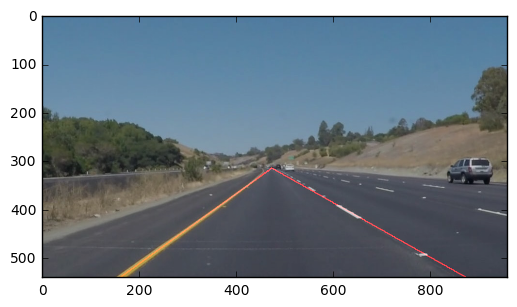

In [7]:
lane_lines(test_images_list[2])

In hough lines
In draw lines
Slope & intercept:  [[0.57565789473684215, 34.875], [0.59868421052631582, 27.921052631578902], [0.59999999999999998, 27.400000000000034], [0.57971014492753625, 35.724637681159436]]
Slope:  0.588513062548 Intercept:  31.4801725782
Slope & intercept:  [[-0.72611464968152861, 655.10828025477701], [-0.75531914893617025, 672.44680851063833], [-0.74358974358974361, 658.61538461538464], [-0.75539568345323738, 673.21582733812943], [-0.75324675324675328, 659.51948051948057], [-0.73999999999999999, 659.46000000000004], [-0.76190476190476186, 664.38095238095241]]
Slope:  -0.751576015188 Intercept:  664.606408894
Coef:  0.588513062548 Intercept:  31.4801725782 intersection_x:  472.450859301
Point one:  (472, 309) Point two:  (960, 596)
Coef:  -0.751576015188 Intercept:  664.606408894 intersection_x:  472.450859301
Point one:  (472, 309) Point two:  (0, 664)


array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ..., 
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ..., 
       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ..., 
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ..., 
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ..., 
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,

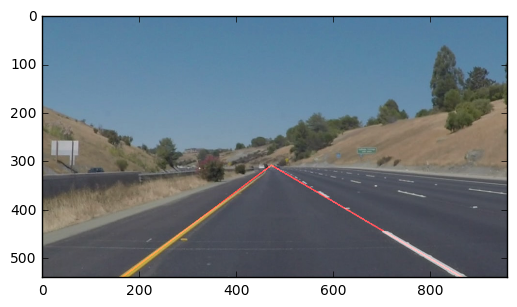

In [8]:
lane_lines(test_images_list[3])

In hough lines
In draw lines
Slope & intercept:  [[0.64593301435406703, -2.4306220095693902], [0.59708737864077666, 23.480582524271881], [0.67532467532467533, -24.896103896103909]]
Slope:  0.639448356107 Intercept:  -1.2820477938
Slope & intercept:  [[-0.72602739726027399, 653.71232876712327], [-0.70085470085470081, 639.85470085470081], [-0.69863013698630139, 637.90410958904113], [-0.65714285714285714, 628.68571428571431], [-0.75, 663.0], [-0.72573839662447259, 654.42194092827003]]
Slope:  -0.720250126345 Intercept:  649.778616028
Coef:  0.639448356107 Intercept:  -1.2820477938 intersection_x:  478.827234291
Point one:  (478, 304) Point two:  (960, 612)
Coef:  -0.720250126345 Intercept:  649.778616028 intersection_x:  478.827234291
Point one:  (478, 304) Point two:  (0, 649)


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ..., 
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ..., 
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ..., 
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ..., 
       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ..., 
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ..., 
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ..., 
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146,

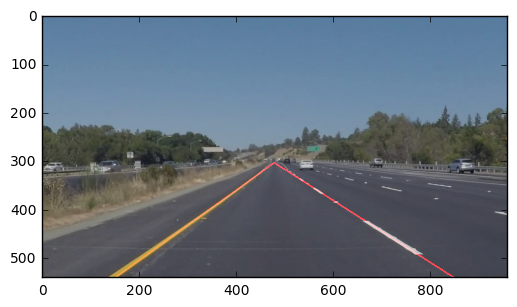

In [9]:
lane_lines(test_images_list[4])

In hough lines
In draw lines
Slope & intercept:  [[0.59931506849315064, 21.986301369863043], [0.57446808510638303, 31.744680851063777], [0.57603686635944695, 29.847926267281139], [0.62068965517241381, 3.86206896551721]]
Slope:  0.592627418783 Intercept:  21.8602443634
Slope & intercept:  [[-0.78102189781021902, 690.29927007299273], [-0.75, 670.0], [-0.75257731958762886, 672.95876288659792], [-0.76923076923076927, 677.69230769230774], [-0.79545454545454541, 695.5], [-0.80833333333333335, 699.17499999999995], [-0.76666666666666672, 676.0333333333333]]
Slope:  -0.774754933155 Intercept:  683.094096284
Coef:  0.592627418783 Intercept:  21.8602443634 intersection_x:  483.576412247
Point one:  (483, 308) Point two:  (960, 590)
Coef:  -0.774754933155 Intercept:  683.094096284 intersection_x:  483.576412247
Point one:  (483, 308) Point two:  (0, 683)


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ..., 
       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ..., 
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ..., 
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,

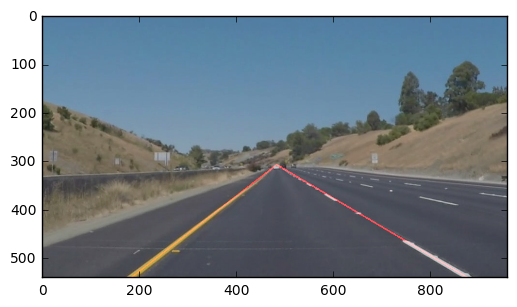

In [10]:
lane_lines(test_images_list[5])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [69]:
# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [67]:
"""

NOTE: If you don't have ffmpeg installed on your computer you'll have to install it for moviepy to work. 
If this is the case you'll be prompted by an error in the notebook. You can easily install ffmpeg by running 
the following in a code cell in the notebook

import imageio
imageio.plugins.ffmpeg.download()

"""

Imageio: 'ffmpeg.win32.exe' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.win32.exe (27.4 MB)
Downloading: 8192/28781056 bytes (0.0%)483328/28781056 bytes (1.7%)901120/28781056 bytes (3.1%)1204224/28781056 bytes (4.2%)1490944/28781056 bytes (5.2%)1908736/28781056 bytes (6.6%)2301952/28781056 bytes (8.0%)2703360/28781056 bytes (9.4%)3112960/28781056 bytes (10.8%)3497984/28781056 bytes (12.2%)3923968/28781056 bytes (13.6%)4235264/28781056 bytes (14.7%)4669440/28781056 bytes (16.2%)5136384/28781056 bytes (17.8%)

In [70]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = lane_lines(image)
    print(result.shape)
    return result

Let's try the one with the solid white lane on the right first ...

In hough lines
In draw lines
Slope & intercept:  [[0.64444444444444449, -5.5555555555555998], [0.60150375939849621, 15.293233082706763], [0.59999999999999998, 29.200000000000045], [0.67455621301775148, -29.106508875739621], [0.59999999999999998, 15.600000000000023], [0.624, 7.0720000000000027]]
Slope:  0.613989640769 Intercept:  12.3219355054
Slope & intercept:  [[-0.752, 665.904], [-0.70305676855895194, 642.56331877729258], [-0.67816091954022983, 638.20689655172418], [-0.72727272727272729, 650.0]]
Slope:  -0.715122603843 Intercept:  649.168553832
Coef:  0.613989640769 Intercept:  12.3219355054 intersection_x:  479.151870663
Point one:  (479, 306) Point two:  (960, 601)
Coef:  -0.715122603843 Intercept:  649.168553832 intersection_x:  479.151870663
Point one:  (479, 306) Point two:  (0, 649)
(540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64444444444444449, -5.5555555555555998], [0.60150375939849621, 15.293233082706763], [0.59999999999999998, 29.200000000000045], [0.67455621301775148, -29.106508875739621], [0.59999999999999998, 15.600000000000023], [0.624, 7.0720000000000027]]
Slope:  0.613989640769 Intercept:  12.3219355054
Slope & intercept:  [[-0.752, 665.904], [-0.70305676855895194, 642.56331877729258], [-0.67816091954022983, 638.20689655172418], [-0.72727272727272729, 650.0]]
Slope:  -0.715122603843 Intercept:  649.168553832
Coef:  0.613989640769 Intercept:  12.3219355054 intersection_x:  479.151870663
Point one:  (479, 306) Point two:  (960, 601)
Coef:  -0.715122603843 Intercept:  649.168553832 intersection_x:  479.151870663
Point one:  (479, 306) Point two:  (0, 649)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.60223048327137552, 15.263940520446056], [0.64754098360655743, -8.1721311475409948], [0.56081081081081086, 44.094594594594582], [0.

  1%|▋                                                                                 | 2/222 [00:00<00:16, 13.52it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60824742268041232, 11.041237113402076], [0.62616822429906538, 6.8411214953271156], [0.63636363636363635, 0.63636363636362603], [0.6166666666666667, 4.6499999999999773], [0.61702127659574468, 14.978723404255334], [0.59322033898305082, 22.576271186440692], [0.6071428571428571, 16.928571428571445], [0.55844155844155841, 49.272727272727309], [0.55782312925170063, 47.517006802721141], [0.66233766233766234, -20.805194805194787], [0.5714285714285714, 34.0]]
Slope:  0.599252368185 Intercept:  20.844202234
Slope & intercept:  [[-0.75265017667844525, 666.7031802120141], [-0.72448979591836737, 647.39795918367349], [-0.7009345794392523, 640.51401869158872]]
Slope:  -0.726024850679 Intercept:  651.538386029
Coef:  0.599252368185 Intercept:  20.844202234 intersection_x:  475.896042592
Point one:  (475, 306) Point two:  (960, 596)
Coef:  -0.726024850679 Intercept:  651.538386029 intersection_x:  475.896042592
Point one:  (475, 306) Point two:  (0, 

  2%|█▍                                                                                | 4/222 [00:00<00:16, 13.39it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62773722627737227, 5.6788321167883282], [0.59999999999999998, 17.0], [0.59999999999999998, 16.0], [0.61194029850746268, 15.955223880597032], [0.60919540229885061, 16.195402298850581], [0.60869565217391308, 17.47826086956519]]
Slope:  0.605966270596 Intercept:  16.5257774098
Slope & intercept:  [[-0.72916666666666663, 656.5], [-0.72727272727272729, 650.81818181818176], [-0.70270270270270274, 644.02702702702709], [-0.77333333333333332, 667.18666666666672]]
Slope:  -0.733118857494 Intercept:  654.632968878
Coef:  0.605966270596 Intercept:  16.5257774098 intersection_x:  476.524739229
Point one:  (476, 305) Point two:  (960, 598)
Coef:  -0.733118857494 Intercept:  654.632968878 intersection_x:  476.524739229
Point one:  (476, 305) Point two:  (0, 654)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62721893491124259, 4.6035502958579855], [0.59999999999999998, 17.0], [0.60076045627376429, 15.140684410646372], [0.609375,

  3%|██▏                                                                               | 6/222 [00:00<00:16, 13.36it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62445414847161573, 7.0611353711790343], [0.60082304526748975, 14.683127572016417], [0.59925093632958804, 16.65168539325839], [0.61538461538461542, 15.53846153846149]]
Slope:  0.609978186363 Intercept:  13.4836024687
Slope & intercept:  [[-0.69680851063829785, 637.89893617021278], [-0.72340425531914898, 653.25531914893622]]
Slope:  -0.710106382979 Intercept:  645.57712766
Coef:  0.609978186363 Intercept:  13.4836024687 intersection_x:  478.828053801
Point one:  (478, 305) Point two:  (960, 599)
Coef:  -0.710106382979 Intercept:  645.57712766 intersection_x:  478.828053801
Point one:  (478, 305) Point two:  (0, 645)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.625, 6.75], [0.59745762711864403, 17.016949152542395], [0.59693877551020413, 18.433673469387713], [0.6071428571428571, 8.1785714285714448]]
Slope:  0.600513086591 Intercept:  14.5430646835
Slope & intercept:  [[-0.7231638418079096, 646.48022598870057], [-0.7

  4%|██▉                                                                               | 8/222 [00:00<00:15, 13.67it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62420382165605093, 7.4522292993630685], [0.59782608695652173, 18.293478260869563], [0.64772727272727271, -10.272727272727252], [0.59774436090225569, 17.364661654135318], [0.61538461538461542, 15.076923076923038], [0.61702127659574468, 12.255319148936167], [0.64150943396226412, -4.1509433962264097]]
Slope:  0.615614932576 Intercept:  11.0486113407
Slope & intercept:  [[-0.69841269841269837, 637.80952380952385], [-0.72463768115942029, 653.98550724637676], [-0.69841269841269837, 638.50793650793651]]
Slope:  -0.707154359328 Intercept:  643.434322521
Coef:  0.615614932576 Intercept:  11.0486113407 intersection_x:  478.077103128
Point one:  (478, 305) Point two:  (960, 602)
Coef:  -0.707154359328 Intercept:  643.434322521 intersection_x:  478.077103128
Point one:  (478, 305) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.599290780141844, 19.014184397163092], [0.62753036437246967, 8.3643724696356117]

  5%|███▋                                                                             | 10/222 [00:00<00:15, 13.75it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60159362549800799, 21.231075697211168], [0.62857142857142856, 10.457142857142856], [0.60273972602739723, 19.643835616438366], [0.64429530201342278, 0.5033557046980377], [0.64684014869888473, -2.4052044609665018]]
Slope:  0.624808046162 Intercept:  9.8860410829
Slope & intercept:  [[-0.69841269841269837, 641.68253968253964], [-0.75213675213675213, 667.97435897435901], [-0.72307692307692306, 657.676923076923], [-0.72680412371134018, 657.96391752577324]]
Slope:  -0.725107624334 Intercept:  656.324434815
Coef:  0.624808046162 Intercept:  9.8860410829 intersection_x:  478.873168051
Point one:  (478, 309) Point two:  (960, 609)
Coef:  -0.725107624334 Intercept:  656.324434815 intersection_x:  478.873168051
Point one:  (478, 309) Point two:  (0, 656)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64794007490636707, -0.88764044943820863], [0.59807073954983925, 25.453376205787777], [0.65909090909090906, -9.5454545454545041

  5%|████▍                                                                            | 12/222 [00:00<00:15, 13.77it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.65000000000000002, -2.1999999999999886], [0.62189054726368154, 9.0099502487562404], [0.6171875, 11.4765625], [0.62745098039215685, 9.6666666666666856], [0.65000000000000002, -2.4499999999999886]]
Slope:  0.633305805531 Intercept:  5.10063588308
Slope & intercept:  [[-0.6988847583643123, 641.89591078066917], [-0.72592592592592597, 657.55555555555554], [-0.67708333333333337, 634.75], [-0.7303370786516854, 659.60674157303367]]
Slope:  -0.708057774069 Intercept:  648.452051977
Coef:  0.633305805531 Intercept:  5.10063588308 intersection_x:  479.624932329
Point one:  (479, 308) Point two:  (960, 613)
Coef:  -0.708057774069 Intercept:  648.452051977 intersection_x:  479.624932329
Point one:  (479, 308) Point two:  (0, 648)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6160714285714286, 11.258928571428555], [0.65240641711229952, -4.4545454545454959], [0.63917525773195871, -4.4639175257731836], [0.65254237288135597, -5.5

  6%|█████                                                                            | 14/222 [00:01<00:15, 13.58it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6512820512820513, -5.8205128205128176], [0.62271062271062272, 5.3369963369963216], [0.63636363636363635, 2.636363636363626], [0.65161290322580645, -5.0967741935484128], [0.60377358490566035, 20.566037735849079]]
Slope:  0.633148559698 Intercept:  3.52442213903
Slope & intercept:  [[-0.72791519434628971, 655.19434628975262], [-0.69964664310954061, 637.34982332155482], [-0.72839506172839508, 654.40740740740739], [-0.69930069930069927, 638.30069930069931]]
Slope:  -0.713814399621 Intercept:  646.31306908
Coef:  0.633148559698 Intercept:  3.52442213903 intersection_x:  477.213306048
Point one:  (477, 305) Point two:  (960, 611)
Coef:  -0.713814399621 Intercept:  646.31306908 intersection_x:  477.213306048
Point one:  (477, 305) Point two:  (0, 646)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.625, 2.125], [0.66990291262135926, -20.621359223300999], [0.6706586826347305, -20.287425149700596]]
Slope:  0.655187198419 In

  7%|█████▊                                                                           | 16/222 [00:01<00:15, 13.35it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67123287671232879, -21.986301369863043], [0.62307692307692308, 2.776923076923083], [0.67241379310344829, -23.810344827586221]]
Slope:  0.655574530964 Intercept:  -14.3399077068
Slope & intercept:  [[-0.67883211678832112, 631.043795620438], [-0.69747899159663862, 635.03361344537814], [-0.67647058823529416, 632.35294117647061]]
Slope:  -0.68426056554 Intercept:  632.810116747
Coef:  0.655574530964 Intercept:  -14.3399077068 intersection_x:  483.007219428
Point one:  (483, 302) Point two:  (960, 615)
Coef:  -0.68426056554 Intercept:  632.810116747 intersection_x:  483.007219428
Point one:  (483, 302) Point two:  (0, 632)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.66995073891625612, -20.709359605911288], [0.62452107279693492, 2.1609195402298269], [0.61194029850746268, 12.179104477611929], [0.61290322580645162, 12.741935483870975], [0.68518518518518523, -29.351851851851904], [0.68888888888888888, -36.64444444444438

  8%|██████▌                                                                          | 18/222 [00:01<00:15, 13.40it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62406015037593987, 3.8045112781954913], [0.65497076023391809, -8.8070175438596152], [0.6244897959183674, 4.0612244897959044], [0.64963503649635035, -6.0948905109489147], [0.63636363636363635, 6.7272727272727479]]
Slope:  0.637903875878 Intercept:  -0.0617799119089
Slope & intercept:  [[-0.70056497175141241, 643.94915254237287], [-0.6470588235294118, 619.35294117647061]]
Slope:  -0.67381189764 Intercept:  631.651046859
Coef:  0.637903875878 Intercept:  -0.0617799119089 intersection_x:  481.592765388
Point one:  (481, 307) Point two:  (960, 612)
Coef:  -0.67381189764 Intercept:  631.651046859 intersection_x:  481.592765388
Point one:  (481, 307) Point two:  (0, 631)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65250965250965254, -6.1003861003861175], [0.62361623616236161, 4.808118081180794], [0.65217391304347827, -5.2608695652173765], [0.63793103448275867, 2.0862068965516869], [0.61194029850746268, 14.402985074626

  9%|███████▎                                                                         | 20/222 [00:01<00:14, 13.60it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62181818181818183, 6.9672727272727002], [0.65306122448979587, -5.346938775510182], [0.64880952380952384, -3.4940476190476488], [0.625, 5.875]]
Slope:  0.637172232529 Intercept:  1.00032158318
Slope & intercept:  [[-0.67333333333333334, 631.73333333333335], [-0.72727272727272729, 657.0]]
Slope:  -0.700303030303 Intercept:  644.366666667
Coef:  0.637172232529 Intercept:  1.00032158318 intersection_x:  481.030463114
Point one:  (481, 307) Point two:  (960, 612)
Coef:  -0.700303030303 Intercept:  644.366666667 intersection_x:  481.030463114
Point one:  (481, 307) Point two:  (0, 644)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62454873646209386, 5.6353790613718502], [0.64912280701754388, -2.7192982456140271], [0.65000000000000002, -4.4499999999999886], [0.62357414448669202, 6.6920152091254863]]
Slope:  0.636811421992 Intercept:  1.28952400622
Slope & intercept:  [[-0.67241379310344829, 632.0], [-0.75, 665.0], [-0.7

 10%|████████                                                                         | 22/222 [00:01<00:14, 13.66it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62181818181818183, 6.9672727272727002], [0.64963503649635035, -2.4963503649635186], [0.65116279069767447, -5.0930232558139892], [0.65000000000000002, -3.4499999999999886]]
Slope:  0.643154002253 Intercept:  -1.01802522338
Slope & intercept:  [[-0.67171717171717171, 631.33333333333337], [-0.72340425531914898, 655.65957446808511], [-0.70430107526881724, 644.3440860215054]]
Slope:  -0.699807500768 Intercept:  643.778997941
Coef:  0.643154002253 Intercept:  -1.01802522338 intersection_x:  480.13068261
Point one:  (480, 307) Point two:  (960, 616)
Coef:  -0.699807500768 Intercept:  643.778997941 intersection_x:  480.13068261
Point one:  (480, 307) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62545454545454549, 4.861818181818137], [0.67073170731707321, -19.719512195121979], [0.6512455516014235, -4.8362989323843522], [0.63513513513513509, 3.5], [0.61403508771929827, 10.403508771929808]]
Slope:  0.6

 11%|████████▊                                                                        | 24/222 [00:01<00:15, 12.73it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62132352941176472, 6.7683823529411598], [0.65034965034965031, -5.5454545454545041], [0.65034965034965031, -4.3916083916083721], [0.62406015037593987, 4.0526315789473415]]
Slope:  0.636520745122 Intercept:  0.220987748706
Slope & intercept:  [[-0.67647058823529416, 632.82352941176475], [-0.70833333333333337, 652.375], [-0.7265625, 655.3125], [-0.77868852459016391, 672.71311475409834], [-0.69942196531791911, 639.09248554913302]]
Slope:  -0.717895382295 Intercept:  650.463325943
Coef:  0.636520745122 Intercept:  0.220987748706 intersection_x:  480.09051652
Point one:  (480, 305) Point two:  (960, 611)
Coef:  -0.717895382295 Intercept:  650.463325943 intersection_x:  480.09051652
Point one:  (480, 305) Point two:  (0, 650)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62361623616236161, 5.4317343173431709], [0.64968152866242035, -5.1719745222929987], [0.6470588235294118, -1.0], [0.63793103448275867, 3.931034482758605

 12%|█████████▍                                                                       | 26/222 [00:01<00:15, 13.04it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62271062271062272, 6.205128205128176], [0.65079365079365081, -4.8888888888889142], [0.65248226950354615, -5.8652482269503707], [0.62453531598513012, 4.0223048327137576], [0.63636363636363635, 2.636363636363626]]
Slope:  0.637377099071 Intercept:  0.421931911673
Slope & intercept:  [[-0.72677595628415304, 658.19125683060111], [-0.67474048442906576, 633.81314878892738], [-0.67226890756302526, 630.55462184873954], [-0.72761194029850751, 657.32835820895525], [-0.69747899159663862, 639.68067226890753]]
Slope:  -0.699775256034 Intercept:  643.913611589
Coef:  0.637377099071 Intercept:  0.421931911673 intersection_x:  481.240359201
Point one:  (481, 307) Point two:  (960, 612)
Coef:  -0.699775256034 Intercept:  643.913611589 intersection_x:  481.240359201
Point one:  (481, 307) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62361623616236161, 4.808118081180794], [0.65000000000000002, -4.4499999999999

 13%|██████████▏                                                                      | 28/222 [00:02<00:14, 12.99it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62230215827338131, 6.9316546762589724], [0.65017667844522964, -4.2473498233215423], [0.6517857142857143, -4.9375], [0.64000000000000001, -8.4399999999999977], [0.63888888888888884, -6.6111111111110858]]
Slope:  0.640630687979 Intercept:  -3.46086125163
Slope & intercept:  [[-0.67333333333333334, 631.03999999999996], [-0.72566371681415931, 656.5840707964602]]
Slope:  -0.699498525074 Intercept:  643.812035398
Coef:  0.640630687979 Intercept:  -3.46086125163 intersection_x:  482.992901241
Point one:  (482, 305) Point two:  (960, 611)
Coef:  -0.699498525074 Intercept:  643.812035398 intersection_x:  482.992901241
Point one:  (482, 305) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65000000000000002, -4.75], [0.61702127659574468, 9.7446808510638334], [0.62295081967213117, 4.1311475409835907], [0.62132352941176472, 6.1470588235293917], [0.63636363636363635, 2.7272727272727479]]
Slope:  0.6244148155

 14%|██████████▉                                                                      | 30/222 [00:02<00:14, 13.21it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64981949458483756, -5.2490974729241771], [0.62172284644194753, 5.1835205992509827], [0.62365591397849462, 4.7849462365591648], [0.63235294117647056, 4.25]]
Slope:  0.625910567199 Intercept:  4.73948894527
Slope & intercept:  [[-0.72432432432432436, 653.84324324324325], [-0.7016574585635359, 640.72928176795585], [-0.74850299401197606, 663.34131736526945]]
Slope:  -0.724828258967 Intercept:  652.637947459
Coef:  0.625910567199 Intercept:  4.73948894527 intersection_x:  479.662275166
Point one:  (479, 304) Point two:  (960, 605)
Coef:  -0.724828258967 Intercept:  652.637947459 intersection_x:  479.662275166
Point one:  (479, 304) Point two:  (0, 652)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64981949458483756, -5.2490974729241771], [0.62447257383966248, 3.2025316455695929], [0.62211981566820274, 5.6820276497696227], [0.65037593984962405, -6.5112781954887282]]
Slope:  0.636696955986 Intercept:  -0.718954093268
Sl

 14%|███████████▋                                                                     | 32/222 [00:02<00:14, 13.38it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62452107279693492, 3.1609195402298269], [0.65090909090909088, -6.1599999999999682], [0.62365591397849462, 4.7849462365591648], [0.65040650406504064, -6.5284552845528196], [0.63636363636363635, -3.7272727272727479]]
Slope:  0.637171243623 Intercept:  -1.69397244701
Slope & intercept:  [[-0.72448979591836737, 654.5612244897959], [-0.69841269841269837, 638.20634920634916], [-0.75630252100840334, 664.26050420168065], [-0.67692307692307696, 631.96923076923076]]
Slope:  -0.714032023066 Intercept:  647.249327167
Coef:  0.637171243623 Intercept:  -1.69397244701 intersection_x:  480.270671047
Point one:  (480, 304) Point two:  (960, 609)
Coef:  -0.714032023066 Intercept:  647.249327167 intersection_x:  480.270671047
Point one:  (480, 304) Point two:  (0, 647)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64874551971326166, -4.351254480286741], [0.60769230769230764, 16.600000000000023], [0.62085308056872035, 7.042654028436

 15%|████████████▍                                                                    | 34/222 [00:02<00:13, 13.53it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62146892655367236, 6.6440677966101589], [0.6512455516014235, -5.1387900355871921], [0.63793103448275867, -2.3620689655172669], [0.63934426229508201, -5.1639344262295594], [0.65909090909090906, -16.386363636363626], [0.6506550218340611, -3.9956331877729099]]
Slope:  0.64328928431 Intercept:  -4.40045374248
Slope & intercept:  [[-0.70059880239520955, 640.05988023952091], [-0.75757575757575757, 666.36363636363637], [-0.75, 665.5]]
Slope:  -0.736058186657 Intercept:  657.307838868
Coef:  0.64328928431 Intercept:  -4.40045374248 intersection_x:  479.725599632
Point one:  (479, 304) Point two:  (960, 613)
Coef:  -0.736058186657 Intercept:  657.307838868 intersection_x:  479.725599632
Point one:  (479, 304) Point two:  (0, 657)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6523605150214592, -4.4163090128755016], [0.62365591397849462, 6.3978494623655706], [0.6235955056179775, 7.0561797752808957], [0.63793103448275867, 3.

 16%|█████████████▏                                                                   | 36/222 [00:02<00:13, 13.77it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.65055762081784385, -3.9144981412639481], [0.62181818181818183, 7.6981818181818085], [0.62430939226519333, 6.7734806629834452], [0.6512455516014235, -4.8362989323843522]]
Slope:  0.636982686626 Intercept:  1.43021635188
Slope & intercept:  [[-0.67685589519650657, 635.95633187772933], [-0.75210084033613445, 664.68487394957981], [-0.65413533834586468, 629.72180451127815], [-0.77777777777777779, 673.22222222222217], [-0.65467625899280579, 628.45323741007201], [-0.67346938775510201, 631.44897959183675]]
Slope:  -0.698169249734 Intercept:  643.914574927
Coef:  0.636982686626 Intercept:  1.43021635188 intersection_x:  481.206925653
Point one:  (481, 307) Point two:  (960, 612)
Coef:  -0.698169249734 Intercept:  643.914574927 intersection_x:  481.206925653
Point one:  (481, 307) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6518518518518519, -5.3407407407407845], [0.62121212121212122, 7.4848484848484

 17%|█████████████▊                                                                   | 38/222 [00:02<00:13, 13.86it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62181818181818183, 6.9672727272727002], [0.65322580645161288, -6.1370967741935374], [0.64000000000000001, 1.4399999999999977], [0.60629921259842523, 19.614173228346431], [0.63636363636363635, 7.9090909090909349]]
Slope:  0.631541367446 Intercept:  5.9586880181
Slope & intercept:  [[-0.69798657718120805, 639.20805369127515], [-0.72677595628415304, 657.91803278688531], [-0.69899665551839463, 640.35451505016727], [-0.72538860103626945, 654.7772020725389]]
Slope:  -0.712286947505 Intercept:  648.0644509
Coef:  0.631541367446 Intercept:  5.9586880181 intersection_x:  477.818301444
Point one:  (477, 307) Point two:  (960, 612)
Coef:  -0.712286947505 Intercept:  648.0644509 intersection_x:  477.818301444
Point one:  (477, 307) Point two:  (0, 648)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62361623616236161, 5.4317343173431709], [0.65322580645161288, -6.8709677419354875], [0.6506024096385542, -3.9518072289156407], [0

 18%|██████████████▌                                                                  | 40/222 [00:02<00:13, 13.77it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62361623616236161, 4.808118081180794], [0.66995073891625612, -18.19211822660094], [0.62222222222222223, 19.066666666666663], [0.67256637168141598, -18.982300884955805], [0.69536423841059603, -37.350993377483462]]
Slope:  0.656743961479 Intercept:  -10.1301255482
Slope & intercept:  [[-0.69999999999999996, 638.5], [-0.67073170731707321, 633.92682926829275], [-0.75221238938053092, 661.44247787610618]]
Slope:  -0.707648032233 Intercept:  644.623102381
Coef:  0.656743961479 Intercept:  -10.1301255482 intersection_x:  479.886448284
Point one:  (479, 305) Point two:  (960, 620)
Coef:  -0.707648032233 Intercept:  644.623102381 intersection_x:  479.886448284
Point one:  (479, 305) Point two:  (0, 644)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62595419847328249, 3.4351145038167488], [0.67261904761904767, -20.619047619047649], [0.69230769230769229, -31.615384615384585], [0.74683544303797467, -68.632911392405049], [0.68

 19%|███████████████▎                                                                 | 42/222 [00:03<00:12, 13.96it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62686567164179108, 2.6567164179104452], [0.67171717171717171, -19.191919191919169], [0.67320261437908502, -19.686274509803923], [0.69047619047619047, -35.476190476190482]]
Slope:  0.665565412054 Intercept:  -17.92441694
Slope & intercept:  [[-0.75147928994082835, 662.40236686390529], [-0.72670807453416153, 648.21739130434787], [-0.80281690140845074, 680.9859154929577]]
Slope:  -0.760334755294 Intercept:  663.868557887
Coef:  0.665565412054 Intercept:  -17.92441694 intersection_x:  478.149165306
Point one:  (478, 300) Point two:  (960, 621)
Coef:  -0.760334755294 Intercept:  663.868557887 intersection_x:  478.149165306
Point one:  (478, 300) Point two:  (0, 663)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62450592885375489, 4.0474308300395592], [0.67123287671232879, -18.917808219178085], [0.68181818181818177, -28.18181818181813], [0.62376237623762376, 4.2277227722772182], [0.64925373134328357, -2.828358208955194

 20%|████████████████                                                                 | 44/222 [00:03<00:13, 13.25it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62655601659751037, 3.5477178423236637], [0.6730038022813688, -20.266159695817464], [0.67222222222222228, -19.133333333333383], [0.61290322580645162, 11.838709677419331]]
Slope:  0.646171316727 Intercept:  -6.00326637735
Slope & intercept:  [[-0.68000000000000005, 630.84000000000003], [-0.75531914893617025, 663.968085106383], [-0.72727272727272729, 647.36363636363637]]
Slope:  -0.720863958736 Intercept:  647.390573823
Coef:  0.646171316727 Intercept:  -6.00326637735 intersection_x:  477.964140303
Point one:  (477, 302) Point two:  (960, 614)
Coef:  -0.720863958736 Intercept:  647.390573823 intersection_x:  477.964140303
Point one:  (477, 302) Point two:  (0, 647)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67123287671232879, -19.260273972602761], [0.62548262548262545, 3.2123552123552486], [0.68181818181818177, -28.272727272727252], [0.69565217391304346, -39.782608695652129]]
Slope:  0.668546464482 Intercept:  -2

 21%|████████████████▊                                                                | 46/222 [00:03<00:13, 12.62it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67441860465116277, -22.116279069767415], [0.62692307692307692, 1.9807692307692264], [0.68918918918918914, -30.418918918918905], [0.68518518518518523, -28.96296296296299], [0.62566844919786091, 4.0534759358288852]]
Slope:  0.660276901029 Intercept:  -15.092783157
Slope & intercept:  [[-0.70253164556962022, 638.68354430379748], [-0.77519379844961245, 667.82945736434112], [-0.7533333333333333, 662.70000000000005], [-0.75167785234899331, 660.46979865771812], [-0.80341880341880345, 676.991452991453]]
Slope:  -0.770905946888 Intercept:  666.997677253
Coef:  0.660276901029 Intercept:  -15.092783157 intersection_x:  476.592114979
Point one:  (476, 299) Point two:  (960, 618)
Coef:  -0.770905946888 Intercept:  666.997677253 intersection_x:  476.592114979
Point one:  (476, 299) Point two:  (0, 666)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67136150234741787, -18.990610328638525], [0.62555066079295152, 3.779735682819421

 22%|█████████████████▌                                                               | 48/222 [00:03<00:13, 12.72it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6730038022813688, -20.266159695817464], [0.62804878048780488, 3.2743902439024168], [0.67142857142857137, -18.342857142857099], [0.6428571428571429, -7.2857142857143344], [0.62445414847161573, 4.7161572052401652]]
Slope:  0.647958489105 Intercept:  -7.58083673505
Slope & intercept:  [[-0.69957081545064381, 637.51502145922746], [-0.75342465753424659, 661.47945205479459], [-0.75263157894736843, 662.13684210526321], [-0.77852348993288589, 667.40939597315435]]
Slope:  -0.761526575472 Intercept:  663.675230044
Coef:  0.647958489105 Intercept:  -7.58083673505 intersection_x:  476.242057223
Point one:  (476, 301) Point two:  (960, 614)
Coef:  -0.761526575472 Intercept:  663.675230044 intersection_x:  476.242057223
Point one:  (476, 301) Point two:  (0, 663)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6717557251908397, -19.55725190839695], [0.62616822429906538, 3.8785046728972361], [0.67129629629629628, -18.268518518518

 23%|██████████████████▏                                                              | 50/222 [00:03<00:14, 12.28it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62745098039215685, 2.7843137254902217], [0.67169811320754713, -19.18113207547168], [0.61194029850746268, 11.626865671641781], [0.67204301075268813, -18.688172043010752]]
Slope:  0.645783100715 Intercept:  -5.86453118034
Slope & intercept:  [[-0.69791666666666663, 636.01041666666663], [-0.72727272727272729, 652.4545454545455], [-0.70070422535211263, 636.09859154929575], [-0.71153846153846156, 651.55769230769226], [-0.70588235294117652, 648.76470588235293], [-0.75, 660.0]]
Slope:  -0.715552405629 Intercept:  647.480991977
Coef:  0.645783100715 Intercept:  -5.86453118034 intersection_x:  479.929833691
Point one:  (479, 304) Point two:  (960, 614)
Coef:  -0.715552405629 Intercept:  647.480991977 intersection_x:  479.929833691
Point one:  (479, 304) Point two:  (0, 647)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6718146718146718, -19.247104247104232], [0.62416107382550334, 5.5906040268456536], [0.64210526315789473,

 23%|██████████████████▉                                                              | 52/222 [00:03<00:13, 12.15it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67169811320754713, -19.18113207547168], [0.62643678160919536, 3.6494252873563369], [0.60416666666666663, 15.958333333333371], [0.60563380281690138, 15.464788732394368], [0.61538461538461542, 10.692307692307679], [0.57798165137614677, 35.504587155963293]]
Slope:  0.605920703571 Intercept:  16.2538884403
Slope & intercept:  [[-0.67407407407407405, 629.94074074074069], [-0.75342465753424659, 655.05479452054794], [-0.75268817204301075, 656.33333333333337], [-0.67407407407407405, 629.26666666666665], [-0.72440944881889768, 650.46456692913387]]
Slope:  -0.715734085309 Intercept:  644.212020438
Coef:  0.605920703571 Intercept:  16.2538884403 intersection_x:  475.130221054
Point one:  (475, 304) Point two:  (960, 597)
Coef:  -0.715734085309 Intercept:  644.212020438 intersection_x:  475.130221054
Point one:  (475, 304) Point two:  (0, 644)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67105263157894735, -19.6447368421052

 24%|███████████████████▋                                                             | 54/222 [00:04<00:14, 11.93it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6278195488721805, 2.35338345864659], [0.67428571428571427, -21.331428571428546], [0.61194029850746268, 15.805970149253767], [0.69696969696969702, -33.878787878787932], [0.65765765765765771, -9.9459459459459936]]
Slope:  0.653734583259 Intercept:  -9.39936175765
Slope & intercept:  [[-0.62376237623762376, 608.20792079207922], [-0.72289156626506024, 648.73493975903614], [-0.69565217391304346, 633.695652173913]]
Slope:  -0.680768705472 Intercept:  630.212837575
Coef:  0.653734583259 Intercept:  -9.39936175765 intersection_x:  479.288589795
Point one:  (479, 303) Point two:  (960, 618)
Coef:  -0.680768705472 Intercept:  630.212837575 intersection_x:  479.288589795
Point one:  (479, 303) Point two:  (0, 630)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62546816479400746, 4.6029962546816705], [0.65648854961832059, -7.3816793893129784], [0.66666666666666663, -14.0], [0.68918918918918914, -29.040540540540519], [0.659574

 25%|████████████████████▍                                                            | 56/222 [00:04<00:13, 12.00it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67320261437908502, -19.084967320261455], [0.62365591397849462, 6.6451612903225623], [0.68888888888888888, -26.711111111111109], [0.65497076023391809, -6.2222222222221717], [0.69117647058823528, -29.470588235294088]]
Slope:  0.666378929614 Intercept:  -14.9687455197
Slope & intercept:  [[-0.66935483870967738, 626.49193548387098], [-0.69718309859154926, 641.91549295774644], [-0.67441860465116277, 627.37209302325584]]
Slope:  -0.680318847317 Intercept:  631.926507155
Coef:  0.666378929614 Intercept:  -14.9687455197 intersection_x:  480.35666484
Point one:  (480, 305) Point two:  (960, 624)
Coef:  -0.680318847317 Intercept:  631.926507155 intersection_x:  480.35666484
Point one:  (480, 305) Point two:  (0, 631)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62765957446808507, 5.4893617021276668], [0.67123287671232879, -16.657534246575381], [0.6728395061728395, -16.734567901234584], [0.61538461538461542, 12.69230769230

 26%|█████████████████████▏                                                           | 58/222 [00:04<00:13, 11.97it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62633451957295372, 6.2419928825622719], [0.67153284671532842, -16.3576642335766], [0.6733668341708543, -17.0251256281407], [0.61290322580645162, 13.903225806451587]]
Slope:  0.646034356566 Intercept:  -3.30939279318
Slope & intercept:  [[-0.64824120603015079, 620.19095477386941], [-0.71999999999999997, 651.0], [-0.75, 658.5], [-0.75373134328358204, 659.01492537313425]]
Slope:  -0.741243781095 Intercept:  656.171641791
Coef:  0.646034356566 Intercept:  -3.30939279318 intersection_x:  475.377659808
Point one:  (475, 303) Point two:  (960, 616)
Coef:  -0.741243781095 Intercept:  656.171641791 intersection_x:  475.377659808
Point one:  (475, 303) Point two:  (0, 656)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64571428571428569, -6.2857142857142776], [0.67272727272727273, -16.672727272727286], [0.66153846153846152, -18.446153846153834], [0.64814814814814814, -10.629629629629676], [0.66101694915254239, -18.610169491

 27%|█████████████████████▉                                                           | 60/222 [00:04<00:13, 11.92it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67266187050359716, -15.273381294964054], [0.64573991031390132, -6.3183856502242293], [0.64467005076142136, -4.7512690355330278], [0.66000000000000003, -18.700000000000045]]
Slope:  0.655767957895 Intercept:  -11.2607589952
Slope & intercept:  [[-0.67346938775510201, 626.57142857142856], [-0.7258883248730964, 650.6649746192893], [-0.74825174825174823, 654.87412587412587], [-0.64978902953586493, 622.61181434599155], [-0.69847328244274809, 642.10687022900765], [-0.80434782608695654, 664.6521739130435]]
Slope:  -0.716703266491 Intercept:  643.580231259
Coef:  0.655767957895 Intercept:  -11.2607589952 intersection_x:  477.125478931
Point one:  (477, 301) Point two:  (960, 618)
Coef:  -0.716703266491 Intercept:  643.580231259 intersection_x:  477.125478931
Point one:  (477, 301) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67153284671532842, -15.343065693430617], [0.64583333333333337, -6.083333333

 28%|██████████████████████▌                                                          | 62/222 [00:04<00:13, 11.94it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67500000000000004, -15.850000000000023], [0.64734299516908211, -7.3574879227053316], [0.64563106796116509, -5.4805825242718811], [0.67432950191570884, -16.973180076628353]]
Slope:  0.660575891261 Intercept:  -11.4153126309
Slope & intercept:  [[-0.67426710097719866, 628.00325732899023], [-0.70833333333333337, 645.95833333333337], [-0.65172413793103445, 622.63448275862072], [-0.69897959183673475, 641.14285714285711], [-0.70297029702970293, 644.14851485148517], [-0.65055762081784385, 621.55762081784383]]
Slope:  -0.681138680321 Intercept:  633.907511039
Coef:  0.660575891261 Intercept:  -11.4153126309 intersection_x:  480.968782286
Point one:  (480, 306) Point two:  (960, 622)
Coef:  -0.681138680321 Intercept:  633.907511039 intersection_x:  480.968782286
Point one:  (480, 306) Point two:  (0, 633)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67407407407407405, -16.088888888888846], [0.62732919254658381, 7.0683229

 29%|███████████████████████▎                                                         | 64/222 [00:04<00:13, 11.94it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64851485148514854, -7.0495049504950771], [0.67509025270758127, -16.249097472924234], [0.67500000000000004, -15.5], [0.66129032258064513, -13.290322580645125], [0.63076923076923075, 5.5846153846154039]]
Slope:  0.658132931509 Intercept:  -9.30086192389
Slope & intercept:  [[-0.7007299270072993, 641.52554744525548], [-0.67226890756302526, 626.00840336134456], [-0.64743589743589747, 619.23076923076928], [-0.65000000000000002, 618.35000000000002]]
Slope:  -0.667608683002 Intercept:  626.278680009
Coef:  0.658132931509 Intercept:  -9.30086192389 intersection_x:  479.414340605
Point one:  (479, 306) Point two:  (960, 622)
Coef:  -0.667608683002 Intercept:  626.278680009 intersection_x:  479.414340605
Point one:  (479, 306) Point two:  (0, 626)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64417177914110424, -3.8220858895705305], [0.6738351254480287, -15.218637992831532], [0.64583333333333337, -6.4375], [0.6428571428571

 30%|████████████████████████                                                         | 66/222 [00:05<00:13, 11.91it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67509025270758127, -16.599277978339387], [0.64375000000000004, -5.3250000000000455], [0.6428571428571429, -3.4285714285714448], [0.67153284671532842, -15.343065693430617], [0.64462809917355368, -6.7107438016528818]]
Slope:  0.655571668291 Intercept:  -9.4813317804
Slope & intercept:  [[-0.69942196531791911, 639.64739884393066], [-0.6706586826347305, 623.32335329341322]]
Slope:  -0.685040323976 Intercept:  631.485376069
Coef:  0.655571668291 Intercept:  -9.4813317804 intersection_x:  478.115003854
Point one:  (478, 303) Point two:  (960, 619)
Coef:  -0.685040323976 Intercept:  631.485376069 intersection_x:  478.115003854
Point one:  (478, 303) Point two:  (0, 631)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67518248175182483, -17.350364963503637], [0.64406779661016944, -5.3559322033897843], [0.64335664335664333, -4.0], [0.67346938775510201, -30.755102040816269], [0.65909090909090906, -17.954545454545439], [0.671

 31%|████████████████████████▊                                                        | 68/222 [00:05<00:13, 11.69it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67518248175182483, -17.350364963503637], [0.62702702702702706, 7.5351351351351354], [0.62352941176470589, 8.0823529411764525], [0.60144927536231885, 23.811594202898561]]
Slope:  0.617335238051 Intercept:  13.1430274264
Slope & intercept:  [[-0.69672131147540983, 638.07377049180332], [-0.66666666666666663, 622.66666666666663], [-0.70078740157480313, 640.44881889763781]]
Slope:  -0.688058459906 Intercept:  633.729752019
Coef:  0.617335238051 Intercept:  13.1430274264 intersection_x:  475.401961541
Point one:  (475, 306) Point two:  (960, 605)
Coef:  -0.688058459906 Intercept:  633.729752019 intersection_x:  475.401961541
Point one:  (475, 306) Point two:  (0, 633)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64571428571428569, -4.7657142857142958], [0.67500000000000004, -15.850000000000023], [0.6454545454545455, -5.5000000000000568], [0.61194029850746268, 20.597014925373117]]
Slope:  0.644527282419 Intercept:  -1.

 32%|█████████████████████████▌                                                       | 70/222 [00:05<00:13, 11.68it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67399267399267404, -16.3479853479854], [0.64761904761904765, -7.5904761904762381], [0.63793103448275867, 0.20689655172412813], [0.64678899082568808, -6.3119266055045955], [0.65573770491803274, -1.0163934426229275], [0.66666666666666663, -10.0]]
Slope:  0.650948688902 Intercept:  -4.94237993738
Slope & intercept:  [[-0.69767441860465118, 639.46511627906978], [-0.67272727272727273, 624.58181818181822], [-0.72307692307692306, 646.7538461538461], [-0.64534883720930236, 615.43604651162786]]
Slope:  -0.684706862905 Intercept:  631.559206782
Coef:  0.650948688902 Intercept:  -4.94237993738 intersection_x:  476.546206736
Point one:  (476, 305) Point two:  (960, 619)
Coef:  -0.684706862905 Intercept:  631.559206782 intersection_x:  476.546206736
Point one:  (476, 305) Point two:  (0, 631)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67509025270758127, -16.249097472924234], [0.64772727272727271, -7.0340909090908781], [0.6

 32%|██████████████████████████▎                                                      | 72/222 [00:05<00:12, 11.84it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67391304347826086, -15.608695652173935], [0.64928909952606639, -7.7014218009479123], [0.67259786476868333, -14.202846975089017], [0.660377358490566, -12.773584905660357]]
Slope:  0.664044341566 Intercept:  -12.5716373335
Slope & intercept:  [[-0.69747899159663862, 638.98319327731087], [-0.64960629921259838, 618.47637795275591], [-0.72395833333333337, 644.23958333333337], [-0.62790697674418605, 612.67441860465112], [-0.62352941176470589, 610.28235294117644], [-0.64864864864864868, 614.97297297297303], [-0.67289719626168221, 632.23364485981301]]
Slope:  -0.663432265366 Intercept:  624.551791992
Coef:  0.664044341566 Intercept:  -12.5716373335 intersection_x:  479.950777285
Point one:  (479, 306) Point two:  (960, 624)
Coef:  -0.663432265366 Intercept:  624.551791992 intersection_x:  479.950777285
Point one:  (479, 306) Point two:  (0, 624)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62941176470588234, 6.911764705

 33%|███████████████████████████                                                      | 74/222 [00:05<00:12, 11.80it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6738351254480287, -14.870967741935488], [0.64727272727272722, -5.3563636363635965], [0.64462809917355368, -2.636363636363626], [0.65909090909090906, -16.295454545454504], [0.6738351254480287, -14.54480286738351]]
Slope:  0.659732397287 Intercept:  -10.7407904855
Slope & intercept:  [[-0.65032679738562094, 617.19281045751632], [-0.69633507853403143, 639.08376963350793], [-0.7231638418079096, 644.31073446327684], [-0.72294372294372289, 642.38095238095241], [-0.7021276595744681, 638.40425531914889], [-0.65289256198347112, 618.30578512396698]]
Slope:  -0.691298277038 Intercept:  633.279717896
Coef:  0.659732397287 Intercept:  -10.7407904855 intersection_x:  476.688294811
Point one:  (476, 303) Point two:  (960, 622)
Coef:  -0.691298277038 Intercept:  633.279717896 intersection_x:  476.688294811
Point one:  (476, 303) Point two:  (0, 633)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67741935483870963, -16.80645161290

 34%|███████████████████████████▋                                                     | 76/222 [00:05<00:12, 11.71it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67452830188679247, -14.438679245283026], [0.64748201438848918, -4.8848920863309218], [0.64864864864864868, -5.1891891891892215], [0.66666666666666663, -10.666666666666629]]
Slope:  0.659331407898 Intercept:  -8.79485679687
Slope & intercept:  [[-0.65040650406504064, 615.47154471544718], [-0.70085470085470081, 635.35897435897436], [-0.62686567164179108, 611.44776119402991], [-0.6470588235294118, 615.47058823529414], [-0.6742424242424242, 628.99242424242425]]
Slope:  -0.659885624867 Intercept:  621.348258549
Coef:  0.659331407898 Intercept:  -8.79485679687 intersection_x:  477.664478017
Point one:  (477, 306) Point two:  (960, 624)
Coef:  -0.659885624867 Intercept:  621.348258549 intersection_x:  477.664478017
Point one:  (477, 306) Point two:  (0, 621)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67632850241545894, -15.236714975845416], [0.64981949458483756, -6.1985559566787174], [0.67391304347826086, -12.5869565

 35%|████████████████████████████▍                                                    | 78/222 [00:06<00:12, 11.83it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.65071770334928225, -4.9999999999999432], [0.69626168224299068, -27.373831775700921], [0.69767441860465118, -29.046511627906966], [0.63636363636363635, 2.9090909090909349], [0.64874551971326166, -4.351254480286741]]
Slope:  0.665952592055 Intercept:  -12.572501395
Slope & intercept:  [[-0.64655172413793105, 618.87068965517244], [-0.61616161616161613, 602.18181818181813]]
Slope:  -0.63135667015 Intercept:  610.526253918
Coef:  0.665952592055 Intercept:  -12.572501395 intersection_x:  480.300860764
Point one:  (480, 307) Point two:  (960, 626)
Coef:  -0.63135667015 Intercept:  610.526253918 intersection_x:  480.300860764
Point one:  (480, 307) Point two:  (0, 610)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64981949458483756, -4.9494584837545403], [0.69811320754716977, -28.566037735849022], [0.6962962962962963, -28.088888888888903], [0.63157894736842102, 10.631578947368439], [0.63793103448275867, 4.931034482758605

 36%|█████████████████████████████▏                                                   | 80/222 [00:06<00:12, 11.79it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.65107913669064743, -5.6510791366906119], [0.69512195121951215, -25.670731707317032], [0.7142857142857143, -40.142857142857167], [0.66000000000000003, 0.31999999999999318], [0.71604938271604934, -40.530864197530832], [0.64968152866242035, -3.834394904458577], [0.63043478260869568, 5.5869565217391255], [0.68421052631578949, -19.78947368421052], [0.74820143884892087, -66.151079136690669]]
Slope:  0.675107877812 Intercept:  -16.2140555314
Slope & intercept:  [[-0.62406015037593987, 605.46616541353387], [-0.70175438596491224, 638.35087719298247], [-0.72631578947368425, 645.78947368421052]]
Slope:  -0.684043441938 Intercept:  629.868838764
Coef:  0.675107877812 Intercept:  -16.2140555314 intersection_x:  475.357588891
Point one:  (475, 304) Point two:  (960, 631)
Coef:  -0.684043441938 Intercept:  629.868838764 intersection_x:  475.357588891
Point one:  (475, 304) Point two:  (0, 629)
(540, 960, 3)
In hough lines
In draw lines
Slope & inte

 37%|█████████████████████████████▉                                                   | 82/222 [00:06<00:12, 11.62it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.69741697416974169, -27.60516605166049], [0.6512820512820513, -5.4615384615384528], [0.65040650406504064, -3.7886178861788267]]
Slope:  0.666368509839 Intercept:  -12.2851074665
Slope & intercept:  [[-0.62365591397849462, 606.27956989247309], [-0.69871794871794868, 635.95512820512818], [-0.62285714285714289, 607.07428571428568], [-0.69999999999999996, 635.60000000000002]]
Slope:  -0.661307751388 Intercept:  621.227245953
Coef:  0.666368509839 Intercept:  -12.2851074665 intersection_x:  477.158756182
Point one:  (477, 305) Point two:  (960, 627)
Coef:  -0.661307751388 Intercept:  621.227245953 intersection_x:  477.158756182
Point one:  (477, 305) Point two:  (0, 621)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.70110701107011075, -29.597785977859814], [0.65384615384615385, -7.153846153846132], [0.65294117647058825, -5.9823529411764866], [0.65217391304347827, -4.9565217391304373], [0.63043478260869568, 5.8478260869

 38%|██████████████████████████████▋                                                  | 84/222 [00:06<00:11, 11.80it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6988847583643123, -28.79553903345726], [0.6506024096385542, -5.6867469879517785], [0.67080745341614911, -19.111801242236027], [0.67391304347826086, -18.369565217391312], [0.62601626016260159, 10.951219512195166], [0.64963503649635035, -3.145985401459825]]
Slope:  0.654194840638 Intercept:  -7.07257586737
Slope & intercept:  [[-0.67469879518072284, 628.89156626506019], [-0.625, 608.75], [-0.60784313725490191, 604.74509803921569], [-0.64754098360655743, 613.85245901639348]]
Slope:  -0.638770729011 Intercept:  614.05978083
Coef:  0.654194840638 Intercept:  -7.07257586737 intersection_x:  480.393578358
Point one:  (480, 307) Point two:  (960, 620)
Coef:  -0.638770729011 Intercept:  614.05978083 intersection_x:  480.393578358
Point one:  (480, 307) Point two:  (0, 614)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.69999999999999996, -29.0], [0.66867469879518071, -16.542168674698814], [0.68888888888888888, -28.24444444

 39%|███████████████████████████████▍                                                 | 86/222 [00:06<00:11, 11.74it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.69999999999999996, -29.0], [0.65454545454545454, -6.5818181818181642], [0.65363128491620115, -6.916201117318451]]
Slope:  0.669392246487 Intercept:  -14.166006433
Slope & intercept:  [[-0.6470588235294118, 613.70588235294122], [-0.67540983606557381, 629.85573770491806], [-0.69819819819819817, 635.73423423423424]]
Slope:  -0.673555619264 Intercept:  626.431951431
Coef:  0.669392246487 Intercept:  -14.166006433 intersection_x:  477.008805927
Point one:  (477, 305) Point two:  (960, 628)
Coef:  -0.673555619264 Intercept:  626.431951431 intersection_x:  477.008805927
Point one:  (477, 305) Point two:  (0, 626)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.70260223048327142, -30.107806691449809], [0.65467625899280579, -6.0359712230215905], [0.6690647482014388, -16.345323741007178], [0.63076923076923075, 8.6000000000000227]]
Slope:  0.664278117112 Intercept:  -10.9722754139
Slope & intercept:  [[-0.6470588235294118, 61

 40%|████████████████████████████████                                                 | 88/222 [00:07<00:11, 11.79it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.70188679245283014, -29.826415094339609], [0.6706586826347305, -16.898203592814355], [0.671875, -19.65625], [0.68965517241379315, -30.827586206896569], [0.70222222222222219, -29.097777777777765], [0.6742424242424242, -20.621212121212068]]
Slope:  0.685090048994 Intercept:  -24.4879074655
Slope & intercept:  [[-0.69369369369369371, 633.49549549549556], [-0.67407407407407405, 629.59259259259261], [-0.69230769230769229, 631.0], [-0.64516129032258063, 614.25806451612902]]
Slope:  -0.686691820025 Intercept:  631.362696029
Coef:  0.685090048994 Intercept:  -24.4879074655 intersection_x:  478.101233371
Point one:  (478, 303) Point two:  (960, 633)
Coef:  -0.686691820025 Intercept:  631.362696029 intersection_x:  478.101233371
Point one:  (478, 303) Point two:  (0, 631)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65051903114186849, -2.5813148788927265], [0.70238095238095233, -30.226190476190425], [0.65467625899280579, -

 41%|████████████████████████████████▊                                                | 90/222 [00:07<00:11, 11.67it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6741573033707865, -18.853932584269671], [0.72151898734177211, -40.620253164556914], [0.70232558139534884, -29.479069767441842], [0.69230769230769229, -34.923076923076906], [0.68181818181818177, -25.136363636363626], [0.70416666666666672, -31.516666666666708], [0.65217391304347827, -3.7826086956521863]]
Slope:  0.684491556434 Intercept:  -23.9486197122
Slope & intercept:  [[-0.61946902654867253, 605.90265486725662], [-0.67005076142131981, 629.54314720812181]]
Slope:  -0.644759893985 Intercept:  617.722901038
Coef:  0.684491556434 Intercept:  -23.9486197122 intersection_x:  482.7314806
Point one:  (482, 306) Point two:  (960, 633)
Coef:  -0.644759893985 Intercept:  617.722901038 intersection_x:  482.7314806
Point one:  (482, 306) Point two:  (0, 617)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6741573033707865, -19.876404494382029], [0.70135746606334837, -28.696832579185468], [0.70588235294117652, -32.58823529411

 41%|█████████████████████████████████▌                                               | 92/222 [00:07<00:11, 11.73it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6742424242424242, -19.272727272727252], [0.72058823529411764, -42.70588235294116], [0.72131147540983609, -41.836065573770497], [0.68965517241379315, -32.206896551724185], [0.70454545454545459, -30.272727272727309]]
Slope:  0.702068552381 Intercept:  -33.2588598048
Slope & intercept:  [[-0.67123287671232879, 630.76712328767121], [-0.64615384615384619, 615.07692307692309], [-0.6964285714285714, 638.91071428571422], [-0.65151515151515149, 618.71212121212125]]
Slope:  -0.666332611452 Intercept:  625.866720466
Coef:  0.702068552381 Intercept:  -33.2588598048 intersection_x:  481.675694008
Point one:  (481, 304) Point two:  (960, 640)
Coef:  -0.666332611452 Intercept:  625.866720466 intersection_x:  481.675694008
Point one:  (481, 304) Point two:  (0, 625)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67669172932330823, -21.300751879699249], [0.7052023121387283, -32.861271676300589], [0.68333333333333335, -15.800000000

 42%|██████████████████████████████████▎                                              | 94/222 [00:07<00:10, 11.67it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.70476190476190481, -33.352380952380997], [0.67557251908396942, -21.725190839694619], [0.67164179104477617, -17.865671641791096], [0.68656716417910446, -18.955223880596975], [0.72222222222222221, -44.833333333333314], [0.67475728155339809, -20.781553398058293], [0.70297029702970293, -31.405940594059359]]
Slope:  0.686045159609 Intercept:  -24.0143268844
Slope & intercept:  [[-0.69753086419753085, 638.42592592592587], [-0.62424242424242427, 608.40606060606058], [-0.60655737704918034, 603.18032786885249], [-0.57777777777777772, 595.24444444444441], [-0.69736842105263153, 635.8947368421052], [-0.62643678160919536, 610.5]]
Slope:  -0.638318940988 Intercept:  615.275249281
Coef:  0.686045159609 Intercept:  -24.0143268844 intersection_x:  482.71436524
Point one:  (482, 307) Point two:  (960, 634)
Coef:  -0.638318940988 Intercept:  615.275249281 intersection_x:  482.71436524
Point one:  (482, 307) Point two:  (0, 615)
(540, 960, 3)
In hough 

 43%|███████████████████████████████████                                              | 96/222 [00:07<00:10, 11.51it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67578125, -23.25], [0.72361809045226133, -46.949748743718601], [0.66666666666666663, -4.6666666666666288], [0.72289156626506024, -45.650602409638566], [0.69480519480519476, -35.68181818181813]]
Slope:  0.696752553638 Intercept:  -31.2397672004
Slope & intercept:  [[-0.6271929824561403, 610.42105263157896], [-0.67460317460317465, 631.26984126984121], [-0.67045454545454541, 628.02272727272725], [-0.67479674796747968, 630.63414634146341], [-0.65271966527196656, 617.0167364016736], [-0.64680851063829792, 616.06808510638302]]
Slope:  -0.663876528787 Intercept:  624.602307278
Coef:  0.696752553638 Intercept:  -31.2397672004 intersection_x:  482.013858847
Point one:  (482, 304) Point two:  (960, 637)
Coef:  -0.663876528787 Intercept:  624.602307278 intersection_x:  482.013858847
Point one:  (482, 304) Point two:  (0, 624)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.72314049586776863, -47.404958677685954], [0.675324675

 44%|███████████████████████████████████▊                                             | 98/222 [00:07<00:10, 11.60it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67816091954022983, -27.045977011494244], [0.72352941176470587, -47.623529411764707], [0.72384937238493718, -48.765690376569012], [0.67721518987341767, -24.765822784810098], [0.67588932806324109, -24.339920948616566]]
Slope:  0.695728844325 Intercept:  -34.5081881067
Slope & intercept:  [[-0.64678899082568808, 615.11926605504584], [-0.676056338028169, 629.14084507042253], [-0.67313915857605178, 629.54692556634302], [-0.625, 611.125], [-0.6064516129032258, 606.01290322580644], [-0.6763754045307443, 631.66343042071196], [-0.62548262548262545, 609.94208494208488]]
Slope:  -0.653807086241 Intercept:  621.089592009
Coef:  0.695728844325 Intercept:  -34.5081881067 intersection_x:  485.79497979
Point one:  (485, 303) Point two:  (960, 633)
Coef:  -0.653807086241 Intercept:  621.089592009 intersection_x:  485.79497979
Point one:  (485, 303) Point two:  (0, 621)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.676000000000000

 45%|████████████████████████████████████                                            | 100/222 [00:08<00:10, 11.65it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67428571428571427, -23.759999999999991], [0.72398190045248867, -48.32579185520359], [0.72427983539094654, -49.115226337448576], [0.68085106382978722, -27.468085106382944]]
Slope:  0.70084962849 Intercept:  -37.1672758248
Slope & intercept:  [[-0.625, 610.125], [-0.66666666666666663, 629.33333333333337], [-0.65040650406504064, 616.07317073170725], [-0.67441860465116277, 629.72093023255809], [-0.62318840579710144, 608.695652173913], [-0.62411347517730498, 607.10638297872345], [-0.62857142857142856, 612.71428571428578], [-0.61111111111111116, 610.5]]
Slope:  -0.637934524505 Intercept:  615.533594396
Coef:  0.70084962849 Intercept:  -37.1672758248 intersection_x:  487.532563603
Point one:  (487, 304) Point two:  (960, 635)
Coef:  -0.637934524505 Intercept:  615.533594396 intersection_x:  487.532563603
Point one:  (487, 304) Point two:  (0, 615)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.70666666666666667, -37.0266

 46%|████████████████████████████████████▊                                           | 102/222 [00:08<00:10, 11.73it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.70422535211267601, -34.704225352112644], [0.67460317460317465, -23.59523809523813], [0.6718146718146718, -20.949806949806941], [0.68333333333333335, -17.766666666666652], [0.72058823529411764, -44.808823529411768]]
Slope:  0.683494132966 Intercept:  -24.253984266
Slope & intercept:  [[-0.624, 610.15999999999997], [-0.71717171717171713, 648.14141414141409], [-0.77941176470588236, 671.57352941176464]]
Slope:  -0.706861160626 Intercept:  643.291647851
Coef:  0.683494132966 Intercept:  -24.253984266 intersection_x:  480.125932698
Point one:  (480, 303) Point two:  (960, 631)
Coef:  -0.706861160626 Intercept:  643.291647851 intersection_x:  480.125932698
Point one:  (480, 303) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.70292887029288698, -33.481171548117118], [0.65048543689320393, -5.621359223300999], [0.66153846153846152, -14.723076923076917], [0.69999999999999996, -44.099999999999909], [0.626

 47%|█████████████████████████████████████▍                                          | 104/222 [00:08<00:10, 11.78it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.671875, -22.015625], [0.70238095238095233, -34.440476190476147], [0.67455621301775148, -22.917159763313634], [0.68656716417910446, -21.656716417910445]]
Slope:  0.677666125732 Intercept:  -22.1965003937
Slope & intercept:  [[-0.64583333333333337, 618.85416666666674], [-0.69999999999999996, 644.0], [-0.64935064935064934, 621.9480519480519]]
Slope:  -0.665061327561 Intercept:  628.267406205
Coef:  0.677666125732 Intercept:  -22.1965003937 intersection_x:  484.434800974
Point one:  (484, 306) Point two:  (960, 628)
Coef:  -0.665061327561 Intercept:  628.267406205 intersection_x:  484.434800974
Point one:  (484, 306) Point two:  (0, 628)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67460317460317465, -24.968253968253975], [0.7032520325203252, -35.853658536585385], [0.70202020202020199, -34.146464646464608], [0.6733668341708543, -23.226130653266353]]
Slope:  0.688310560829 Intercept:  -29.5486269511
Slope & intercept

 48%|██████████████████████████████████████▏                                         | 106/222 [00:08<00:09, 11.70it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.703125, -35.453125], [0.65040650406504064, -7.4308943089430954], [0.66101694915254239, -17.033898305084733], [0.65040650406504064, -7.0406504065040281], [0.69090909090909092, -29.436363636363637], [0.62745098039215685, 6.1176470588235361], [0.7008928571428571, -34.629464285714278]]
Slope:  0.669172555104 Intercept:  -17.8438212691
Slope & intercept:  [[-0.64583333333333337, 619.08333333333337], [-0.65116279069767447, 628.37209302325584], [-0.72131147540983609, 650.21311475409834], [-0.67261904761904767, 627.26190476190482]]
Slope:  -0.672731661765 Intercept:  631.232611468
Coef:  0.669172555104 Intercept:  -17.8438212691 intersection_x:  483.69803491
Point one:  (483, 305) Point two:  (960, 624)
Coef:  -0.672731661765 Intercept:  631.232611468 intersection_x:  483.69803491
Point one:  (483, 305) Point two:  (0, 631)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.70238095238095233, -36.547619047619037], [0.67129629

 49%|██████████████████████████████████████▉                                         | 108/222 [00:08<00:09, 11.71it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.70119521912350602, -35.577689243027919], [0.67248908296943233, -24.423580786026207], [0.65151515151515149, -8.6212121212121247], [0.7009345794392523, -35.728971962616811]]
Slope:  0.681533508262 Intercept:  -26.0878635282
Slope & intercept:  [[-0.67372881355932202, 627.72457627118638], [-0.69758064516129037, 642.49193548387098], [-0.72375690607734811, 651.07182320441984], [-0.68181818181818177, 628.77272727272725]]
Slope:  -0.694221136654 Intercept:  637.515265558
Coef:  0.681533508262 Intercept:  -26.0878635282 intersection_x:  482.355724939
Point one:  (482, 302) Point two:  (960, 628)
Coef:  -0.694221136654 Intercept:  637.515265558 intersection_x:  482.355724939
Point one:  (482, 302) Point two:  (0, 637)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65765765765765771, -13.981981981982017], [0.70430107526881724, -36.413978494623677], [0.6292134831460674, 8.8089887640449547], [0.63265306122448983, 7.4693877551

 50%|███████████████████████████████████████▋                                        | 110/222 [00:08<00:09, 11.66it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.70119521912350602, -34.876494023904399], [0.65789473684210531, -14.157894736842138], [0.67330677290836649, -24.557768924302763], [0.68965517241379315, -28.379310344827616], [0.67357512953367871, -24.36787564766837]]
Slope:  0.679125406164 Intercept:  -25.2678687355
Slope & intercept:  [[-0.69871794871794868, 644.20512820512818], [-0.66666666666666663, 625.33333333333337], [-0.65217391304347827, 623.91304347826087], [-0.62337662337662336, 608.01298701298697], [-0.65000000000000002, 623.79999999999995]]
Slope:  -0.658187030361 Intercept:  625.052898406
Coef:  0.679125406164 Intercept:  -25.2678687355 intersection_x:  486.289328791
Point one:  (486, 304) Point two:  (960, 626)
Coef:  -0.658187030361 Intercept:  625.052898406 intersection_x:  486.289328791
Point one:  (486, 304) Point two:  (0, 625)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.70238095238095233, -35.547619047619037], [0.67083333333333328, -23.108333

 50%|████████████████████████████████████████▎                                       | 112/222 [00:09<00:09, 11.56it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67136150234741787, -24.44600938967136], [0.70078740157480313, -34.944881889763792], [0.69960474308300391, -34.976284584980192], [0.68888888888888888, -39.533333333333303]]
Slope:  0.690160633974 Intercept:  -33.4751272994
Slope & intercept:  [[-0.72072072072072069, 647.86486486486478], [-0.70289855072463769, 644.41304347826087], [-0.67153284671532842, 627.83211678832117], [-0.60396039603960394, 601.44554455445541], [-0.676056338028169, 633.25352112676057]]
Slope:  -0.692802114047 Intercept:  638.340886565
Coef:  0.690160633974 Intercept:  -33.4751272994 intersection_x:  485.780267636
Point one:  (485, 301) Point two:  (960, 629)
Coef:  -0.692802114047 Intercept:  638.340886565 intersection_x:  485.780267636
Point one:  (485, 301) Point two:  (0, 638)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.69960474308300391, -35.37549407114625], [0.66911764705882348, -22.441176470588232], [0.67171717171717171, -25.373737373

 51%|█████████████████████████████████████████                                       | 114/222 [00:09<00:09, 11.48it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.70281124497991965, -38.710843373493958], [0.67195767195767198, -27.460317460317469], [0.65517241379310343, -14.86206896551721], [0.69758064516129037, -36.10887096774195], [0.63793103448275867, -4.8448275862069181], [0.65217391304347827, -11.782608695652186]]
Slope:  0.669604487236 Intercept:  -22.2949228415
Slope & intercept:  [[-0.67346938775510201, 632.48979591836735], [-0.65116279069767447, 617.8604651162791], [-0.6696428571428571, 625.10714285714289], [-0.67567567567567566, 629.67567567567562]]
Slope:  -0.672929306858 Intercept:  629.090871484
Coef:  0.669604487236 Intercept:  -22.2949228415 intersection_x:  485.191357708
Point one:  (485, 302) Point two:  (960, 620)
Coef:  -0.672929306858 Intercept:  629.090871484 intersection_x:  485.191357708
Point one:  (485, 302) Point two:  (0, 629)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67149758454106279, -27.743961352656981], [0.69841269841269837, -37.492063492

 52%|█████████████████████████████████████████▊                                      | 116/222 [00:09<00:09, 11.51it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.65217391304347827, -14.043478260869563], [0.6953125, -35.6328125], [0.68055555555555558, -24.916666666666686], [0.63793103448275867, -2.5172413793104056], [0.62962962962962965, 5.3333333333333144], [0.6607142857142857, -13.51785714285711], [0.67901234567901236, -23.395061728395092], [0.63076923076923075, 3.6153846153846416]]
Slope:  0.652969427839 Intercept:  -9.92022674705
Slope & intercept:  [[-0.70161290322580649, 642.62096774193549], [-0.67123287671232879, 625.43835616438355], [-0.65068493150684936, 622.61643835616439], [-0.69999999999999996, 638.89999999999998]]
Slope:  -0.680882677861 Intercept:  632.393940566
Coef:  0.652969427839 Intercept:  -9.92022674705 intersection_x:  481.548265035
Point one:  (481, 304) Point two:  (960, 616)
Coef:  -0.680882677861 Intercept:  632.393940566 intersection_x:  481.548265035
Point one:  (481, 304) Point two:  (0, 632)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.699481

 53%|██████████████████████████████████████████▌                                     | 118/222 [00:09<00:08, 11.57it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6954022988505747, -35.327586206896569], [0.64822134387351782, -11.043478260869563], [0.60606060606060608, 18.666666666666629], [0.77876106194690264, -101.22123893805303], [0.64864864864864868, -12.540540540540576], [0.69465648854961837, -34.038167938931338]]
Slope:  0.658597877197 Intercept:  -14.8566212561
Slope & intercept:  [[-0.64739884393063585, 617.73988439306356], [-0.69871794871794868, 641.03846153846155], [-0.60655737704918034, 603.67213114754099], [-0.65000000000000002, 623.39999999999998]]
Slope:  -0.650668542424 Intercept:  621.46261927
Coef:  0.658597877197 Intercept:  -14.8566212561 intersection_x:  486.012037726
Point one:  (486, 305) Point two:  (960, 617)
Coef:  -0.650668542424 Intercept:  621.46261927 intersection_x:  486.012037726
Point one:  (486, 305) Point two:  (0, 621)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6470588235294118, -10.058823529411768], [0.67547169811320751, -20.6150943396

 54%|███████████████████████████████████████████▏                                    | 120/222 [00:09<00:08, 11.44it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67164179104477617, -17.447761194029852], [0.64556962025316456, -9.7341772151898454], [0.67403314917127077, -20.569060773480714], [0.62903225806451613, 1.9838709677419502]]
Slope:  0.655069204633 Intercept:  -11.4417820537
Slope & intercept:  [[-0.72375690607734811, 649.50276243093924], [-0.67326732673267331, 627.69306930693074], [-0.67450980392156867, 634.99607843137255], [-0.70222222222222219, 645.21333333333337], [-0.6512820512820513, 620.68205128205125]]
Slope:  -0.685007662047 Intercept:  635.617458957
Coef:  0.655069204633 Intercept:  -11.4417820537 intersection_x:  482.852332653
Point one:  (482, 304) Point two:  (960, 617)
Coef:  -0.685007662047 Intercept:  635.617458957 intersection_x:  482.852332653
Point one:  (482, 304) Point two:  (0, 635)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6741573033707865, -19.202247191011224], [0.62886597938144329, 2.8350515463917532], [0.6742424242424242, -20.2727272727

 55%|███████████████████████████████████████████▉                                    | 122/222 [00:09<00:08, 11.55it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6271186440677966, 2.7627118644068105], [0.67521367521367526, -21.752136752136778], [0.6741573033707865, -19.876404494382029], [0.64077669902912626, -6.7669902912621751], [0.6454545454545455, -9.7181818181818471], [0.66216216216216217, -20.472972972972968]]
Slope:  0.65414717155 Intercept:  -12.6373290774
Slope & intercept:  [[-0.67460317460317465, 627.04761904761904], [-0.70032573289902278, 643.7491856677525], [-0.67346938775510201, 633.83673469387759], [-0.72222222222222221, 648.83333333333337]]
Slope:  -0.69265512937 Intercept:  638.366718186
Coef:  0.65414717155 Intercept:  -12.6373290774 intersection_x:  483.370162658
Point one:  (483, 303) Point two:  (960, 615)
Coef:  -0.69265512937 Intercept:  638.366718186 intersection_x:  483.370162658
Point one:  (483, 303) Point two:  (0, 638)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67136150234741787, -19.901408450704253], [0.62430939226519333, 5.0276243093923085

 56%|████████████████████████████████████████████▋                                   | 124/222 [00:10<00:08, 11.57it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6711111111111111, -20.364444444444416], [0.62598425196850394, 3.4094488188976584], [0.625, 3.25], [0.69047619047619047, -30.952380952380963], [0.67346938775510201, -21.326530612244881]]
Slope:  0.657208188262 Intercept:  -13.196781438
Slope & intercept:  [[-0.6470588235294118, 621.76470588235293], [-0.69565217391304346, 642.3478260869565], [-0.71111111111111114, 645.66666666666663], [-0.63636363636363635, 620.72727272727275], [-0.676056338028169, 631.92957746478874], [-0.67333333333333334, 633.77333333333331], [-0.72357723577235777, 653.99186991869919]]
Slope:  -0.680450378864 Intercept:  635.743036011
Coef:  0.657208188262 Intercept:  -13.196781438 intersection_x:  485.131133906
Point one:  (485, 305) Point two:  (960, 617)
Coef:  -0.680450378864 Intercept:  635.743036011 intersection_x:  485.131133906
Point one:  (485, 305) Point two:  (0, 635)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62406015037593987, 3.

 57%|█████████████████████████████████████████████▍                                  | 126/222 [00:10<00:08, 11.59it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62264150943396224, 4.3962264150943611], [0.67455621301775148, -24.254437869822482], [0.65909090909090906, -11.727272727272691], [0.66942148760330578, -19.247933884297538], [0.69672131147540983, -39.065573770491824]]
Slope:  0.664486286124 Intercept:  -17.9797983674
Slope & intercept:  [[-0.65151515151515149, 623.60606060606062], [-0.7016574585635359, 647.46408839779008], [-0.72115384615384615, 653.56730769230762]]
Slope:  -0.691442152078 Intercept:  641.545818899
Coef:  0.664486286124 Intercept:  -17.9797983674 intersection_x:  486.401493386
Point one:  (486, 305) Point two:  (960, 619)
Coef:  -0.691442152078 Intercept:  641.545818899 intersection_x:  486.401493386
Point one:  (486, 305) Point two:  (0, 641)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62357414448669202, 2.9733840304182309], [0.65090909090909088, -6.8109090909090924], [0.66666666666666663, -18.0], [0.63265306122448983, -1.7959183673469852]]
Slop

 58%|██████████████████████████████████████████████▏                                 | 128/222 [00:10<00:08, 11.48it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.625, 2.75], [0.64944649446494462, -5.9889298892989018], [0.65073529411764708, -6.6654411764706083]]
Slope:  0.641727262861 Intercept:  -3.30145702192
Slope & intercept:  [[-0.72093023255813948, 654.46511627906978], [-0.6776859504132231, 633.85950413223145], [-0.67361111111111116, 633.55555555555554], [-0.69999999999999996, 646.20000000000005]]
Slope:  -0.693056823521 Intercept:  642.020043992
Coef:  0.641727262861 Intercept:  -3.30145702192 intersection_x:  483.465084427
Point one:  (483, 306) Point two:  (960, 612)
Coef:  -0.693056823521 Intercept:  642.020043992 intersection_x:  483.465084427
Point one:  (483, 306) Point two:  (0, 642)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.61988304093567248, 5.5204678362573532], [0.64855072463768115, -5.4855072463768124], [0.64102564102564108, -7.0512820512821008], [0.64179104477611937, -8.194029850746233], [0.64000000000000001, -7.6000000000000227]]
Slope:  0.638250090

 59%|██████████████████████████████████████████████▊                                 | 130/222 [00:10<00:07, 11.74it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6223776223776224, 3.7552447552447461], [0.65090909090909088, -6.4618181818181597], [0.64727272727272722, -5.0618181818181256], [0.60747663551401865, 15.037383177570121], [0.5957446808510638, 21.787234042553223], [0.5892857142857143, 25.26785714285711], [0.60465116279069764, 18.0]]
Slope:  0.611134757182 Intercept:  13.1309834894
Slope & intercept:  [[-0.6741573033707865, 633.76404494382018], [-0.75172413793103443, 665.0], [-0.71186440677966101, 654.15254237288138], [-0.67741935483870963, 637.35483870967744]]
Slope:  -0.70379130073 Intercept:  647.567856507
Coef:  0.611134757182 Intercept:  13.1309834894 intersection_x:  482.488630596
Point one:  (482, 307) Point two:  (960, 599)
Coef:  -0.70379130073 Intercept:  647.567856507 intersection_x:  482.488630596
Point one:  (482, 307) Point two:  (0, 647)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64855072463768115, -4.8369565217391255], [0.6216216216216216, 5.72972

 59%|███████████████████████████████████████████████▌                                | 132/222 [00:10<00:07, 11.49it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64963503649635035, -5.744525547445221], [0.62083333333333335, 5.9499999999999886], [0.64963503649635035, -6.3941605839415843], [0.62234042553191493, 5.5531914893616658]]
Slope:  0.635610957964 Intercept:  -0.158873660506
Slope & intercept:  [[-0.75124378109452739, 664.78606965174129], [-0.70168067226890751, 643.86134453781506], [-0.72844827586206895, 660.18534482758616], [-0.72573839662447259, 658.4683544303798], [-0.70833333333333337, 643.83333333333337]]
Slope:  -0.723088891837 Intercept:  654.226889356
Coef:  0.635610957964 Intercept:  -0.158873660506 intersection_x:  481.626433618
Point one:  (481, 305) Point two:  (960, 610)
Coef:  -0.723088891837 Intercept:  654.226889356 intersection_x:  481.626433618
Point one:  (481, 305) Point two:  (0, 654)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62352941176470589, 2.7647058823529278], [0.65037593984962405, -7.015037593984971], [0.64444444444444449, -9.4444444444

 60%|████████████████████████████████████████████████▎                               | 134/222 [00:10<00:07, 11.44it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.651685393258427, -9.4157303370786849], [0.6216216216216216, 3.4054054054054177], [0.64935064935064934, -8.3766233766233995], [0.63461538461538458, 5.192307692307736]]
Slope:  0.639318262212 Intercept:  -2.298660154
Slope & intercept:  [[-0.67619047619047623, 634.6952380952381], [-0.75247524752475248, 663.85148514851483], [-0.72483221476510062, 655.42281879194627], [-0.6696428571428571, 629.35714285714289], [-0.72516556291390732, 656.47682119205297], [-0.67586206896551726, 633.22068965517246]]
Slope:  -0.70402807125 Intercept:  645.504032623
Coef:  0.639318262212 Intercept:  -2.298660154 intersection_x:  482.230588375
Point one:  (482, 306) Point two:  (960, 611)
Coef:  -0.70402807125 Intercept:  645.504032623 intersection_x:  482.230588375
Point one:  (482, 306) Point two:  (0, 645)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62149532710280375, 1.6495327102803685], [0.64893617021276595, -9.0319148936169995], [0

 61%|█████████████████████████████████████████████████                               | 136/222 [00:11<00:07, 11.56it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64864864864864868, -8.8648648648648987], [0.62, 3.5199999999999818], [0.64000000000000001, -13.439999999999998], [0.6376811594202898, -10.869565217391255]]
Slope:  0.636582452017 Intercept:  -7.41360752056
Slope & intercept:  [[-0.72340425531914898, 654.468085106383], [-0.67272727272727273, 632.85454545454547], [-0.70289855072463769, 645.33333333333337], [-0.69841269841269837, 639.39682539682542]]
Slope:  -0.699360694296 Intercept:  643.013197323
Coef:  0.636582452017 Intercept:  -7.41360752056 intersection_x:  486.867129517
Point one:  (486, 302) Point two:  (960, 603)
Coef:  -0.699360694296 Intercept:  643.013197323 intersection_x:  486.867129517
Point one:  (486, 302) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65019011406844107, -9.7604562737642482], [0.60526315789473684, 13.631578947368439], [0.6015625, 17.046875], [0.58278145695364236, 29.238410596026483]]
Slope:  0.596535704949 Inter

 62%|█████████████████████████████████████████████████▋                              | 138/222 [00:11<00:07, 11.62it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60487804878048779, 15.199999999999989], [0.64684014869888473, -6.6394052044609566], [0.60919540229885061, 11.045977011494244], [0.59090909090909094, 27.136363636363626], [0.64864864864864868, -7.1621621621621898]]
Slope:  0.620094267867 Intercept:  7.91615465625
Slope & intercept:  [[-0.65217391304347827, 623.26086956521738], [-0.75555555555555554, 666.73333333333335], [-0.70175438596491224, 641.98245614035091]]
Slope:  -0.703161284855 Intercept:  643.99221968
Coef:  0.620094267867 Intercept:  7.91615465625 intersection_x:  480.690267058
Point one:  (480, 305) Point two:  (960, 603)
Coef:  -0.703161284855 Intercept:  643.99221968 intersection_x:  480.690267058
Point one:  (480, 305) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65073529411764708, -7.6176470588235361], [0.6235955056179775, 2.9606741573034014], [0.61702127659574468, 6.1276595744680549], [0.62450592885375489, 1.3003952569169996]

 63%|██████████████████████████████████████████████████▍                             | 140/222 [00:11<00:07, 11.63it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62195121951219512, 3.9390243902439011], [0.64835164835164838, -5.967032967032992], [0.64935064935064934, -5.5194805194805099], [0.62337662337662336, 2.2727272727273089]]
Slope:  0.635757535148 Intercept:  -1.31869045589
Slope & intercept:  [[-0.67142857142857137, 632.54285714285709], [-0.75609756097560976, 668.78048780487802], [-0.69999999999999996, 646.20000000000005], [-0.67924528301886788, 639.64150943396226], [-0.70503597122302153, 649.25179856115108]]
Slope:  -0.702361477329 Intercept:  647.283330589
Coef:  0.635757535148 Intercept:  -1.31869045589 intersection_x:  484.711759565
Point one:  (484, 306) Point two:  (960, 609)
Coef:  -0.702361477329 Intercept:  647.283330589 intersection_x:  484.711759565
Point one:  (484, 306) Point two:  (0, 647)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62109375, 5.796875], [0.65073529411764708, -6.6654411764706083], [0.64963503649635035, -6.3941605839415843], [0.6363636

 64%|███████████████████████████████████████████████████▏                            | 142/222 [00:11<00:06, 11.64it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6216216216216216, 5.2432432432432279], [0.66911764705882348, -19.551470588235247], [0.671875, -20.8125], [0.64000000000000001, 1.4800000000000182], [0.63461538461538458, -6.1346153846153584], [0.62200956937799046, 5.7464114832535529]]
Slope:  0.643206537112 Intercept:  -5.67148854106
Slope & intercept:  [[-0.69886363636363635, 643.875], [-0.72413793103448276, 658.17241379310349], [-0.754601226993865, 668.60736196319021]]
Slope:  -0.725867598131 Intercept:  656.884925252
Coef:  0.643206537112 Intercept:  -5.67148854106 intersection_x:  483.944876861
Point one:  (483, 305) Point two:  (960, 611)
Coef:  -0.725867598131 Intercept:  656.884925252 intersection_x:  483.944876861
Point one:  (483, 305) Point two:  (0, 656)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.625, 2.125], [0.65037593984962405, -7.015037593984971], [0.625, 7.25], [0.63793103448275867, 1.0517241379309894], [0.7142857142857143, -49.85714285714289]]

 65%|███████████████████████████████████████████████████▉                            | 144/222 [00:11<00:06, 11.73it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62264150943396224, 4.1509433962264097], [0.65022421524663676, -7.6278026905829392], [0.63636363636363635, 4.2727272727272521], [0.6244343891402715, 1.6108597285067958], [0.63636363636363635, 3.454545454545439]]
Slope:  0.629950792825 Intercept:  3.372268963
Slope & intercept:  [[-0.7021276595744681, 645.27659574468089], [-0.75119617224880386, 669.03827751196172], [-0.72649572649572647, 660.0], [-0.70124481327800825, 647.07883817427387], [-0.77639751552795033, 674.77018633540376]]
Slope:  -0.731492377425 Intercept:  659.232779553
Coef:  0.629950792825 Intercept:  3.372268963 intersection_x:  481.739175694
Point one:  (481, 306) Point two:  (960, 608)
Coef:  -0.731492377425 Intercept:  659.232779553 intersection_x:  481.739175694
Point one:  (481, 306) Point two:  (0, 659)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62445414847161573, 0.72052401746725536], [0.64960629921259838, -8.8228346456692748], [0.6526717557

 66%|████████████████████████████████████████████████████▌                           | 146/222 [00:12<00:06, 11.73it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64772727272727271, -8.0340909090908781], [0.60571428571428576, 13.314285714285688], [0.60305343511450382, 15.961832061068719], [0.58730158730158732, 23.920634920634882], [0.58394160583941601, 27.978102189781055]]
Slope:  0.595002728492 Intercept:  20.2937137214
Slope & intercept:  [[-0.70032573289902278, 644.44951140065143], [-0.75087719298245614, 666.39999999999998], [-0.67512690355329952, 638.10152284263961], [-0.70329670329670335, 644.07692307692309]]
Slope:  -0.707406633183 Intercept:  648.25698933
Coef:  0.595002728492 Intercept:  20.2937137214 intersection_x:  482.155068972
Point one:  (482, 307) Point two:  (960, 591)
Coef:  -0.707406633183 Intercept:  648.25698933 intersection_x:  482.155068972
Point one:  (482, 307) Point two:  (0, 648)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.61988304093567248, 1.3391812865497172], [0.6472868217054264, -9.6046511627907307], [0.64885496183206104, -9.9312977099236264

 67%|█████████████████████████████████████████████████████▎                          | 148/222 [00:12<00:06, 11.54it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64573991031390132, -8.6950672645739928], [0.60119047619047616, 13.869047619047649], [0.61864406779661019, 0.77966101694914869], [0.6992481203007519, -52.488721804511272], [0.64814814814814814, -9.814814814814838], [0.6607142857142857, -20.446428571428555], [0.6619718309859155, -22.704225352112701], [0.60236220472440949, 13.342519685039349]]
Slope:  0.634110131982 Intercept:  -4.80990109741
Slope & intercept:  [[-0.6962962962962963, 642.51111111111118], [-0.67213114754098358, 638.77049180327867], [-0.68627450980392157, 641.31372549019602], [-0.74789915966386555, 663.05882352941171], [-0.78260869565217395, 672.04347826086951], [-0.72661870503597126, 657.87769784172667]]
Slope:  -0.718638085666 Intercept:  652.595888006
Coef:  0.634110131982 Intercept:  -4.80990109741 intersection_x:  485.977937747
Point one:  (485, 303) Point two:  (960, 603)
Coef:  -0.718638085666 Intercept:  652.595888006 intersection_x:  485.977937747
Point one:  (4

 68%|██████████████████████████████████████████████████████                          | 150/222 [00:12<00:06, 11.55it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60085836909871249, 14.652360515021428], [0.62962962962962965, 3.8148148148147811], [0.6333333333333333, -0.43333333333333712], [0.62827225130890052, 3.9685863874345841], [0.60077519379844957, 14.124031007751967], [0.62721893491124259, 4.0887573964496937]]
Slope:  0.62001461868 Intercept:  6.70253613136
Slope & intercept:  [[-0.70588235294117652, 645.88235294117646], [-0.72784810126582278, 660.62025316455697], [-0.67708333333333337, 635.52083333333337]]
Slope:  -0.703604595847 Intercept:  647.34114648
Coef:  0.62001461868 Intercept:  6.70253613136 intersection_x:  484.005220926
Point one:  (484, 306) Point two:  (960, 601)
Coef:  -0.703604595847 Intercept:  647.34114648 intersection_x:  484.005220926
Point one:  (484, 306) Point two:  (0, 647)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.60240963855421692, 15.506024096385488], [0.64878048780487807, -9.8878048780487688], [0.64423076923076927, -7.3076923076923208],

 68%|██████████████████████████████████████████████████████▊                         | 152/222 [00:12<00:06, 11.48it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64638783269961975, -8.4904942965779355], [0.60317460317460314, 14.444444444444457], [0.60273972602739723, 13.328767123287719]]
Slope:  0.617434053967 Intercept:  6.42757242372
Slope & intercept:  [[-0.70769230769230773, 647.12307692307695], [-0.73015873015873012, 661.8730158730159], [-0.68148148148148147, 638.57037037037037]]
Slope:  -0.706444173111 Intercept:  649.188821055
Coef:  0.617434053967 Intercept:  6.42757242372 intersection_x:  485.513875434
Point one:  (485, 306) Point two:  (960, 599)
Coef:  -0.706444173111 Intercept:  649.188821055 intersection_x:  485.513875434
Point one:  (485, 306) Point two:  (0, 649)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64960629921259838, -11.866141732283438], [0.62037037037037035, 0.50925925925929505], [0.6166666666666667, 2.7333333333332916], [0.6953125, -44.6171875]]
Slope:  0.628881112083 Intercept:  -2.8745163799
Slope & intercept:  [[-0.70129870129870131, 646.103

 69%|███████████████████████████████████████████████████████▍                        | 154/222 [00:12<00:05, 11.48it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64822134387351782, -11.691699604743121], [0.60571428571428576, 10.777142857142849], [0.60185185185185186, 14.990740740740762], [0.58333333333333337, 24.083333333333314], [0.64777327935222673, -10.31174089068827], [0.60360360360360366, 11.747747747747724]]
Slope:  0.615082949621 Intercept:  6.59925403059
Slope & intercept:  [[-0.70238095238095233, 644.98809523809518], [-0.72580645161290325, 659.83870967741939], [-0.67938931297709926, 638.70229007633588], [-0.754601226993865, 670.88957055214723]]
Slope:  -0.715544485991 Intercept:  653.604666386
Coef:  0.615082949621 Intercept:  6.59925403059 intersection_x:  486.240847768
Point one:  (486, 305) Point two:  (960, 597)
Coef:  -0.715544485991 Intercept:  653.604666386 intersection_x:  486.240847768
Point one:  (486, 305) Point two:  (0, 653)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62037037037037035, -1.1388888888888573], [0.64682539682539686, -11.15476190476192

 70%|████████████████████████████████████████████████████████▏                       | 156/222 [00:12<00:05, 11.46it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.61870503597122306, -0.89208633093528533], [0.64940239043824699, -12.992031872509926], [0.63492063492063489, -10.714285714285666], [0.62244897959183676, -3.153061224489818]]
Slope:  0.625358216828 Intercept:  -4.9198110899
Slope & intercept:  [[-0.70042194092827004, 644.99578059071723], [-0.75454545454545452, 668.58181818181811], [-0.77894736842105261, 676.39999999999998], [-0.7009345794392523, 648.1121495327103], [-0.67105263157894735, 639.32894736842104]]
Slope:  -0.721180394983 Intercept:  655.483739135
Coef:  0.625358216828 Intercept:  -4.9198110899 intersection_x:  490.445312472
Point one:  (490, 301) Point two:  (960, 595)
Coef:  -0.721180394983 Intercept:  655.483739135 intersection_x:  490.445312472
Point one:  (490, 301) Point two:  (0, 655)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.60169491525423724, 11.338983050847503], [0.64655172413793105, -12.508620689655174], [0.58666666666666667, 24.60000000000

 71%|████████████████████████████████████████████████████████▉                       | 158/222 [00:13<00:05, 11.15it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62827225130890052, 0.19895287958115659], [0.59999999999999998, 11.800000000000011], [0.61538461538461542, 7.3846153846153584], [0.63380281690140849, -2.9014084507042526], [0.6376811594202898, -6.2463768115941889]]
Slope:  0.623028168603 Intercept:  2.04715660038
Slope & intercept:  [[-0.75432525951557095, 670.76124567474051], [-0.7258883248730964, 652.23857868020309], [-0.75432525951557095, 670.00692041522495], [-0.72413793103448276, 654.65517241379314], [-0.72727272727272729, 651.4545454545455]]
Slope:  -0.737189900442 Intercept:  659.823292528
Coef:  0.623028168603 Intercept:  2.04715660038 intersection_x:  483.581383674
Point one:  (483, 303) Point two:  (960, 600)
Coef:  -0.737189900442 Intercept:  659.823292528 intersection_x:  483.581383674
Point one:  (483, 303) Point two:  (0, 659)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62548262548262545, 1.3359073359073363], [0.59917355371900827, 11.32644628099171

 72%|█████████████████████████████████████████████████████████▋                      | 160/222 [00:13<00:05, 11.07it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59745762711864403, 12.41949152542378], [0.64166666666666672, -11.483333333333348], [0.6428571428571429, -12.928571428571445], [0.59999999999999998, 16.400000000000034], [0.57446808510638303, 31.319148936170166], [0.66000000000000003, -23.54000000000002], [0.64102564102564108, -12.076923076923094]]
Slope:  0.622496451825 Intercept:  0.015687517538
Slope & intercept:  [[-0.72868217054263562, 656.2790697674418], [-0.70542635658914732, 650.37984496124034], [-0.76744186046511631, 675.37209302325584], [-0.69999999999999996, 650.0], [-0.7021276595744681, 648.59574468085111], [-0.73333333333333328, 659.20000000000005], [-0.78048780487804881, 682.02439024390242], [-0.76744186046511631, 676.37209302325584]]
Slope:  -0.735617630731 Intercept:  662.277904462
Coef:  0.622496451825 Intercept:  0.015687517538 intersection_x:  487.633716086
Point one:  (487, 303) Point two:  (960, 597)
Coef:  -0.735617630731 Intercept:  662.277904462 intersection_x:

 73%|██████████████████████████████████████████████████████████▍                     | 162/222 [00:13<00:05, 10.98it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62348178137651822, 0.93522267206475362], [0.601123595505618, 7.6067415730336734], [0.59701492537313428, 11.343283582089612], [0.63636363636363635, -6.636363636363626]]
Slope:  0.614495984655 Intercept:  3.31222104771
Slope & intercept:  [[-0.75294117647058822, 668.35294117647061], [-0.77710843373493976, 682.90963855421683]]
Slope:  -0.765024805103 Intercept:  675.631289865
Coef:  0.614495984655 Intercept:  3.31222104771 intersection_x:  487.356967586
Point one:  (487, 302) Point two:  (960, 593)
Coef:  -0.765024805103 Intercept:  675.631289865 intersection_x:  487.356967586
Point one:  (487, 302) Point two:  (0, 675)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62272727272727268, 0.96363636363639671], [0.57788944723618085, 25.462311557788951], [0.56451612903225812, 37.838709677419331], [0.63043478260869568, -2.978260869565247], [0.62365591397849462, -0.838709677419331]]
Slope:  0.603844709117 Intercept:  12.0895

 74%|███████████████████████████████████████████████████████████                     | 164/222 [00:13<00:05, 10.95it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57692307692307687, 25.500000000000057], [0.60309278350515461, 15.159793814432987], [0.59999999999999998, 19.0], [0.57471264367816088, 28.229885057471279], [0.5892857142857143, 27.232142857142833]]
Slope:  0.588802843678 Intercept:  23.0243643458
Slope & intercept:  [[-0.77868852459016391, 685.20491803278685], [-0.75630252100840334, 670.8739495798319], [-0.75409836065573765, 668.37704918032784], [-0.81196581196581197, 696.12820512820508], [-0.72043010752688175, 658.60215053763443]]
Slope:  -0.764297065149 Intercept:  675.837254492
Coef:  0.588802843678 Intercept:  23.0243643458 intersection_x:  482.457271549
Point one:  (482, 307) Point two:  (960, 588)
Coef:  -0.764297065149 Intercept:  675.837254492 intersection_x:  482.457271549
Point one:  (482, 307) Point two:  (0, 675)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57471264367816088, 28.229885057471279], [0.60144927536231885, 17.550724637681128], [0.619047619

 75%|███████████████████████████████████████████████████████████▊                    | 166/222 [00:13<00:05, 10.93it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60240963855421692, 17.192771084337323], [0.57462686567164178, 29.455223880597032], [0.5892857142857143, 28.571428571428555], [0.57587548638132291, 27.774319066147882]]
Slope:  0.585549426223 Intercept:  25.7484356506
Slope & intercept:  [[-0.72455089820359286, 660.08982035928148], [-0.83333333333333337, 704.5], [-0.72352941176470587, 660.78235294117644], [-0.80519480519480524, 693.0], [-0.8359375, 704.8125]]
Slope:  -0.784509189699 Intercept:  684.63693466
Coef:  0.585549426223 Intercept:  25.7484356506 intersection_x:  480.919933901
Point one:  (480, 307) Point two:  (960, 587)
Coef:  -0.784509189699 Intercept:  684.63693466 intersection_x:  480.919933901
Point one:  (480, 307) Point two:  (0, 684)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57462686567164178, 29.455223880597032], [0.59999999999999998, 19.600000000000023]]
Slope:  0.587313432836 Intercept:  24.5276119403
Slope & intercept:  [[-0.83464566929133

 76%|████████████████████████████████████████████████████████████▌                   | 168/222 [00:13<00:04, 10.92it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60093896713615025, 18.450704225352126], [0.57564575645756455, 29.553505535055365], [0.59861591695501726, 20.79584775086505]]
Slope:  0.59173354685 Intercept:  22.9333525038
Slope & intercept:  [[-0.80882352941176472, 693.44117647058829], [-0.72807017543859653, 662.19298245614038], [-0.78048780487804881, 687.80487804878044], [-0.78139534883720929, 685.91162790697672], [-0.75233644859813087, 670.06542056074773], [-0.80808080808080807, 694.33333333333337]]
Slope:  -0.786224787961 Intercept:  686.311287264
Coef:  0.59173354685 Intercept:  22.9333525038 intersection_x:  481.420894959
Point one:  (481, 307) Point two:  (960, 590)
Coef:  -0.786224787961 Intercept:  686.311287264 intersection_x:  481.420894959
Point one:  (481, 307) Point two:  (0, 686)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57564575645756455, 29.553505535055365], [0.59861591695501726, 20.79584775086505], [0.60431654676258995, 17.47482014388487]]


 77%|█████████████████████████████████████████████████████████████▎                  | 170/222 [00:14<00:04, 11.07it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57720588235294112, 28.750000000000057], [0.60142348754448394, 18.370106761565864], [0.61616161616161613, 7.2525252525252881], [0.5901639344262295, 27.065573770491824], [0.6071428571428571, 15.214285714285722]]
Slope:  0.598419555526 Intercept:  19.3304982998
Slope & intercept:  [[-0.75531914893617025, 671.18085106382978], [-0.78095238095238095, 688.28571428571422], [-0.75347222222222221, 669.61111111111109], [-0.80582524271844658, 695.48543689320388]]
Slope:  -0.773892248707 Intercept:  681.140778338
Coef:  0.598419555526 Intercept:  19.3304982998 intersection_x:  482.259409266
Point one:  (482, 307) Point two:  (960, 593)
Coef:  -0.773892248707 Intercept:  681.140778338 intersection_x:  482.259409266
Point one:  (482, 307) Point two:  (0, 681)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57608695652173914, 29.739130434782624], [0.60070671378091878, 19.190812720848044], [0.60207612456747406, 19.408304498269899]]

 77%|█████████████████████████████████████████████████████████████▉                  | 172/222 [00:14<00:04, 11.07it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60084033613445376, 18.710084033613441], [0.57720588235294112, 28.750000000000057], [0.58208955223880599, 35.074626865671632], [0.602112676056338, 18.580985915492988]]
Slope:  0.590562111696 Intercept:  25.2789242037
Slope & intercept:  [[-0.81395348837209303, 695.90697674418607], [-0.75396825396825395, 668.31746031746025], [-0.71153846153846156, 663.23076923076928], [-0.75, 670.5], [-0.71999999999999997, 664.0], [-0.75590551181102361, 670.22834645669286], [-0.81355932203389836, 698.86440677966107]]
Slope:  -0.759846433961 Intercept:  675.863994218
Coef:  0.590562111696 Intercept:  25.2789242037 intersection_x:  481.769070632
Point one:  (481, 309) Point two:  (960, 592)
Coef:  -0.759846433961 Intercept:  675.863994218 intersection_x:  481.769070632
Point one:  (481, 309) Point two:  (0, 675)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57407407407407407, 29.944444444444457], [0.60070671378091878, 18.989399293286

 78%|██████████████████████████████████████████████████████████████▋                 | 174/222 [00:14<00:04, 11.21it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60150375939849621, 18.909774436090231], [0.57551020408163267, 29.061224489795904], [0.6028368794326241, 17.546099290780148], [0.58904109589041098, 17.178082191780788]]
Slope:  0.592222984701 Intercept:  20.6737951021
Slope & intercept:  [[-0.80645161290322576, 695.58064516129025], [-0.78064516129032258, 680.53548387096771], [-0.75449101796407181, 669.57485029940119]]
Slope:  -0.780529264053 Intercept:  681.896993111
Coef:  0.592222984701 Intercept:  20.6737951021 intersection_x:  481.677009532
Point one:  (481, 305) Point two:  (960, 589)
Coef:  -0.780529264053 Intercept:  681.896993111 intersection_x:  481.677009532
Point one:  (481, 305) Point two:  (0, 681)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57777777777777772, 27.666666666666686], [0.60142348754448394, 18.370106761565864], [0.60101010101010099, 19.727272727272748]]
Slope:  0.593403788777 Intercept:  21.9213487185
Slope & intercept:  [[-0.80898876404

 79%|███████████████████████████████████████████████████████████████▍                | 176/222 [00:14<00:04, 11.50it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59999999999999998, 19.400000000000034], [0.57553956834532372, 30.22302158273385], [0.5855855855855856, 31.621621621621614], [0.58904109589041098, 17.945205479452056], [0.59999999999999998, 19.600000000000023], [0.60240963855421692, 19.120481927710784]]
Slope:  0.592095981396 Intercept:  22.9850551019
Slope & intercept:  [[-0.75213675213675213, 670.47863247863245], [-0.80660377358490565, 696.84433962264154], [-0.80841121495327106, 698.71962616822429]]
Slope:  -0.789050580225 Intercept:  688.68086609
Coef:  0.592095981396 Intercept:  22.9850551019 intersection_x:  481.987813232
Point one:  (481, 308) Point two:  (960, 591)
Coef:  -0.789050580225 Intercept:  688.68086609 intersection_x:  481.987813232
Point one:  (481, 308) Point two:  (0, 688)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57352941176470584, 29.852941176470608], [0.60317460317460314, 17.85714285714289], [0.57777777777777772, 27.666666666666686], [0.

 80%|████████████████████████████████████████████████████████████████▏               | 178/222 [00:14<00:03, 11.66it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57723577235772361, 27.845528455284523], [0.6015625, 17.6484375], [0.56043956043956045, 41.010989010989022], [0.57677902621722843, 27.973782771535582]]
Slope:  0.571484786338 Intercept:  32.2767667459
Slope & intercept:  [[-0.75163398692810457, 670.75163398692814], [-0.81159420289855078, 697.02898550724638], [-0.86086956521739133, 714.89565217391305], [-0.84033613445378152, 710.03361344537814], [-0.83448275862068966, 705.86206896551721]]
Slope:  -0.836820665298 Intercept:  706.955080023
Coef:  0.571484786338 Intercept:  32.2767667459 intersection_x:  479.071008703
Point one:  (479, 306) Point two:  (960, 580)
Coef:  -0.836820665298 Intercept:  706.955080023 intersection_x:  479.071008703
Point one:  (479, 306) Point two:  (0, 706)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57528957528957525, 27.718146718146727], [0.60227272727272729, 15.829545454545439], [0.60087719298245612, 17.640350877192986]]
Slope:  0.5928

 81%|████████████████████████████████████████████████████████████████▊               | 180/222 [00:15<00:03, 11.64it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60076045627376429, 16.539923954372625], [0.57692307692307687, 26.692307692307736], [0.60360360360360366, 15.67567567567562], [0.57723577235772361, 26.682926829268297]]
Slope:  0.58963072729 Intercept:  21.3977085379
Slope & intercept:  [[-0.77990430622009566, 680.97607655502395], [-0.78048780487804881, 679.90243902439022], [-0.8393782383419689, 707.43523316062169], [-0.80975609756097566, 698.15609756097558], [-0.83571428571428574, 708.10000000000002]]
Slope:  -0.809048146543 Intercept:  694.91396926
Coef:  0.58963072729 Intercept:  21.3977085379 intersection_x:  481.53745175
Point one:  (481, 305) Point two:  (960, 587)
Coef:  -0.809048146543 Intercept:  694.91396926 intersection_x:  481.53745175
Point one:  (481, 305) Point two:  (0, 694)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59999999999999998, 16.600000000000023], [0.57707509881422925, 25.403162055335997], [0.58823529411764708, 17.941176470588232], [0.5

 82%|█████████████████████████████████████████████████████████████████▌              | 182/222 [00:15<00:03, 11.62it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57754010695187163, 25.641711229946566], [0.60098522167487689, 16.743842364531986], [0.54545454545454541, 51.545454545454561], [0.56818181818181823, 33.318181818181756], [0.60096153846153844, 16.365384615384642], [0.5757575757575758, 26.242424242424192]]
Slope:  0.57814680108 Intercept:  28.3094998027
Slope & intercept:  [[-0.78021978021978022, 679.2197802197802], [-0.83815028901734101, 707.87283236994222], [-0.81273408239700373, 700.35955056179773], [-0.81000000000000005, 698.26999999999998]]
Slope:  -0.810276037909 Intercept:  696.430540788
Coef:  0.57814680108 Intercept:  28.3094998027 intersection_x:  481.208621915
Point one:  (481, 306) Point two:  (960, 583)
Coef:  -0.810276037909 Intercept:  696.430540788 intersection_x:  481.208621915
Point one:  (481, 306) Point two:  (0, 696)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57539682539682535, 26.472222222222229], [0.60344827586206895, 14.603448275862092], [

 83%|██████████████████████████████████████████████████████████████████▎             | 184/222 [00:15<00:03, 11.57it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.58091286307053946, 23.149377593360953], [0.60185185185185186, 15.592592592592609], [0.60431654676258995, 14.661870503597129], [0.58333333333333337, 26.25], [0.5714285714285714, 29.428571428571445]]
Slope:  0.588368633289 Intercept:  21.8164824236
Slope & intercept:  [[-0.75471698113207553, 673.84905660377353], [-0.8379446640316206, 704.7509881422925], [-0.83657587548638135, 706.31517509727632], [-0.75384615384615383, 672.04615384615386], [-0.78260869565217395, 679.17391304347825]]
Slope:  -0.79313847403 Intercept:  687.227057347
Coef:  0.588368633289 Intercept:  21.8164824236 intersection_x:  481.655556745
Point one:  (481, 305) Point two:  (960, 586)
Coef:  -0.79313847403 Intercept:  687.227057347 intersection_x:  481.655556745
Point one:  (481, 305) Point two:  (0, 687)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57746478873239437, 25.15492957746477], [0.60396039603960394, 14.366336633663366], [0.608247422680

 84%|███████████████████████████████████████████████████████████████████             | 186/222 [00:15<00:03, 11.73it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57707509881422925, 26.288537549407124], [0.60465116279069764, 13.976744186046517], [0.60377358490566035, 15.735849056603797], [0.58730158730158732, 24.031746031746025], [0.578125, 25.78125]]
Slope:  0.590185286762 Intercept:  21.1628253648
Slope & intercept:  [[-0.83448275862068966, 705.68965517241372], [-0.75, 666.25], [-0.75609756097560976, 671.80487804878044]]
Slope:  -0.780193439865 Intercept:  681.24817774
Coef:  0.590185286762 Intercept:  21.1628253648 intersection_x:  481.680968589
Point one:  (481, 305) Point two:  (960, 587)
Coef:  -0.780193439865 Intercept:  681.24817774 intersection_x:  481.680968589
Point one:  (481, 305) Point two:  (0, 681)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.5761316872427984, 24.666666666666629], [0.60150375939849621, 14.691729323308266], [0.57499999999999996, 26.725000000000023]]
Slope:  0.584211815547 Intercept:  22.0277986633
Slope & intercept:  [[-0.80681818181818177,

 85%|███████████████████████████████████████████████████████████████████▋            | 188/222 [00:15<00:02, 11.65it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57456140350877194, 23.618421052631561], [0.59760956175298807, 14.494023904382459], [0.59999999999999998, 13.600000000000023], [0.56756756756756754, 29.540540540540576], [0.58490566037735847, 14.11320754716985]]
Slope:  0.584928838641 Intercept:  19.0732386089
Slope & intercept:  [[-0.75, 664.0], [-0.8375634517766497, 704.74111675126903], [-0.72580645161290325, 656.77419354838707]]
Slope:  -0.77112330113 Intercept:  675.1717701
Coef:  0.584928838641 Intercept:  19.0732386089 intersection_x:  483.829870732
Point one:  (483, 302) Point two:  (960, 580)
Coef:  -0.77112330113 Intercept:  675.1717701 intersection_x:  483.829870732
Point one:  (483, 302) Point two:  (0, 675)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59751037344398339, 11.995850622406635], [0.57627118644067798, 18.627118644067764], [0.609375, 1.40625], [0.55801104972375692, 33.110497237569064]]
Slope:  0.585291902402 Intercept:  16.284929126
Slope & 

 86%|████████████████████████████████████████████████████████████████████▍           | 190/222 [00:15<00:02, 11.59it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.55506607929515417, 35.110132158590318], [0.57894736842105265, 26.21052631578948], [0.58064516129032262, 23.903225806451587]]
Slope:  0.571552869669 Intercept:  28.4079614269
Slope & intercept:  [[-0.75172413793103443, 666.02758620689656], [-0.86885245901639341, 713.42622950819668], [-0.84347826086956523, 705.66086956521735]]
Slope:  -0.821351619272 Intercept:  695.038228427
Coef:  0.571552869669 Intercept:  28.4079614269 intersection_x:  478.590077276
Point one:  (478, 301) Point two:  (960, 577)
Coef:  -0.821351619272 Intercept:  695.038228427 intersection_x:  478.590077276
Point one:  (478, 301) Point two:  (0, 695)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.58108108108108103, 24.810810810810835], [0.55502392344497609, 36.813397129186569], [0.55555555555555558, 35.777777777777771], [0.56818181818181823, 33.090909090909065], [0.56862745098039214, 36.039215686274531]]
Slope:  0.561847187041 Intercept:  35.4303

 86%|█████████████████████████████████████████████████████████████████████▏          | 192/222 [00:16<00:02, 11.38it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59649122807017541, 17.526315789473699], [0.57377049180327866, 24.885245901639337], [0.59090909090909094, 20.318181818181813], [0.56756756756756754, 29.486486486486513], [0.58823529411764708, 16.117647058823536], [0.59905660377358494, 14.580188679245282], [0.65040650406504064, -32.056910569105696]]
Slope:  0.58600504604 Intercept:  20.4856776223
Slope & intercept:  [[-0.7570093457943925, 672.00934579439252], [-0.83769633507853403, 706.98952879581157], [-0.78205128205128205, 679.51282051282055], [-0.75342465753424659, 674.10958904109589], [-0.83734939759036142, 703.71084337349396], [-0.81025641025641026, 697.47692307692307]]
Slope:  -0.796297904718 Intercept:  688.968175099
Coef:  0.58600504604 Intercept:  20.4856776223 intersection_x:  483.600571865
Point one:  (483, 303) Point two:  (960, 583)
Coef:  -0.796297904718 Intercept:  688.968175099 intersection_x:  483.600571865
Point one:  (483, 303) Point two:  (0, 688)
(540, 960, 3)
In h

 87%|█████████████████████████████████████████████████████████████████████▉          | 194/222 [00:16<00:02, 10.39it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59854014598540151, 17.868613138686101], [0.57539682539682535, 26.472222222222229]]
Slope:  0.586968485691 Intercept:  22.1704176805
Slope & intercept:  [[-0.75357142857142856, 672.13571428571424], [-0.83673469387755106, 705.18367346938771], [-0.71818181818181814, 658.26363636363635], [-0.81027667984189722, 698.43478260869563]]
Slope:  -0.779691155118 Intercept:  683.504451682
Coef:  0.586968485691 Intercept:  22.1704176805 intersection_x:  483.905439404
Point one:  (483, 306) Point two:  (960, 585)
Coef:  -0.779691155118 Intercept:  683.504451682 intersection_x:  483.905439404
Point one:  (483, 306) Point two:  (0, 683)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59999999999999998, 18.400000000000034], [0.57414448669201523, 29.307984790874514], [0.57707509881422925, 26.288537549407124]]
Slope:  0.583739861835 Intercept:  24.6655074468
Slope & intercept:  [[-0.75486381322957197, 671.76653696498056], [-0.75357142

 88%|██████████████████████████████████████████████████████████████████████▋         | 196/222 [00:17<00:04,  5.68it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59854014598540151, 18.467153284671497], [0.57421875, 28.09375]]
Slope:  0.586379447993 Intercept:  23.2804516423
Slope & intercept:  [[-0.80909090909090908, 697.32727272727266], [-0.83805668016194335, 704.93522267206481], [-0.74509803921568629, 670.62745098039215], [-0.77927927927927931, 680.01351351351354], [-0.81415929203539827, 698.25663716814165], [-0.8666666666666667, 709.60000000000002], [-0.7807017543859649, 681.68421052631584]]
Slope:  -0.814659096937 Intercept:  695.302809435
Coef:  0.586379447993 Intercept:  23.2804516423 intersection_x:  479.660149412
Point one:  (479, 304) Point two:  (960, 586)
Coef:  -0.814659096937 Intercept:  695.302809435 intersection_x:  479.660149412
Point one:  (479, 304) Point two:  (0, 695)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59854014598540151, 17.868613138686101], [0.57936507936507942, 23.9444444444444], [0.57603686635944695, 25.327188940092185]]
Slope:  0.5846473

 89%|███████████████████████████████████████████████████████████████████████▎        | 198/222 [00:17<00:03,  6.68it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59926470588235292, 17.040441176470608], [0.57539682539682535, 26.321428571428612], [0.59905660377358494, 16.221698113207538], [0.57547169811320753, 25.254716981132106]]
Slope:  0.587297458291 Intercept:  21.2095712106
Slope & intercept:  [[-0.83783783783783783, 706.7297297297298], [-0.80916030534351147, 689.51145038167942], [-0.80666666666666664, 695.45333333333338]]
Slope:  -0.817888269949 Intercept:  697.231504482
Coef:  0.587297458291 Intercept:  21.2095712106 intersection_x:  481.090805069
Point one:  (481, 303) Point two:  (960, 585)
Coef:  -0.817888269949 Intercept:  697.231504482 intersection_x:  481.090805069
Point one:  (481, 303) Point two:  (0, 697)
(540, 960, 3)


 90%|███████████████████████████████████████████████████████████████████████▋        | 199/222 [00:17<00:03,  7.31it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57657657657657657, 25.846846846846859], [0.59854014598540151, 17.868613138686101], [0.56000000000000005, 37.439999999999941], [0.609375, 11.765625]]
Slope:  0.58612293064 Intercept:  23.2302712464
Slope & intercept:  [[-0.72413793103448276, 658.89655172413791], [-0.83908045977011492, 707.97701149425291], [-0.78421052631578947, 682.16842105263163]]
Slope:  -0.782476305707 Intercept:  683.013994757
Coef:  0.58612293064 Intercept:  23.2302712464 intersection_x:  482.086871005
Point one:  (482, 305) Point two:  (960, 585)
Coef:  -0.782476305707 Intercept:  683.013994757 intersection_x:  482.086871005
Point one:  (482, 305) Point two:  (0, 683)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.55675675675675673, 39.016216216216208], [0.58181818181818179, 29.163636363636385], [0.5423728813559322, 51.983050847457605], [0.58695652173913049, 26.173913043478194], [0.55882352941176472, 38.970588235294088], [0.57894736842105265,

 91%|████████████████████████████████████████████████████████████████████████▍       | 201/222 [00:17<00:02,  8.14it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.55825242718446599, 37.393203883495175], [0.59740259740259738, 16.974025974026006], [0.61904761904761907, -2.0476190476190368], [0.5957446808510638, 18.957446808510667], [0.55609756097560981, 39.736585365853614]]
Slope:  0.585308977092 Intercept:  22.2027285969
Slope & intercept:  [[-0.75572519083969469, 668.85496183206112], [-0.83606557377049184, 705.24590163934431], [-0.8110236220472441, 697.31496062992119], [-0.81415929203539827, 692.23008849557527]]
Slope:  -0.820416162618 Intercept:  698.263650255
Coef:  0.585308977092 Intercept:  22.2027285969 intersection_x:  480.933934067
Point one:  (480, 303) Point two:  (960, 584)
Coef:  -0.820416162618 Intercept:  698.263650255 intersection_x:  480.933934067
Point one:  (480, 303) Point two:  (0, 698)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.55428571428571427, 41.360000000000014], [0.59848484848484851, 15.924242424242436], [0.609375, 6.0625], [0.5957446808510638, 

 91%|█████████████████████████████████████████████████████████████████████████▏      | 203/222 [00:17<00:02,  8.94it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.5539906103286385, 39.408450704225345], [0.59493670886075944, 18.278481012658233], [0.59375, 17.84375], [0.54385964912280704, 45.771929824561369], [0.55696202531645567, 38.291139240506368], [0.61111111111111116, 5.7777777777777715]]
Slope:  0.57576835079 Intercept:  27.5619214266
Slope & intercept:  [[-0.77844311377245512, 676.74251497005991], [-0.80924855491329484, 697.1098265895954], [-0.74866310160427807, 669.62566844919786], [-0.77777777777777779, 677.77777777777783]]
Slope:  -0.778533137017 Intercept:  680.313946947
Coef:  0.57576835079 Intercept:  27.5619214266 intersection_x:  481.984278535
Point one:  (481, 305) Point two:  (960, 580)
Coef:  -0.778533137017 Intercept:  680.313946947 intersection_x:  481.984278535
Point one:  (481, 305) Point two:  (0, 680)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.55797101449275366, 35.297101449275317], [0.59677419354838712, 14.435483870967744], [0.54216867469879515, 4

 92%|█████████████████████████████████████████████████████████████████████████▊      | 205/222 [00:17<00:01,  9.66it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59728506787330315, 14.348416289592762], [0.55487804878048785, 38.054878048780438], [0.51162790697674421, 68.860465116279045], [0.55434782608695654, 37.358695652173878], [0.51162790697674421, 69.720930232558146], [0.61363636363636365, -0.38636363636362603]]
Slope:  0.557233853388 Intercept:  37.9928369505
Slope & intercept:  [[-0.77826086956521734, 676.10000000000002], [-0.80373831775700932, 695.82242990654208], [-0.75478927203065138, 670.97701149425291], [-0.75396825396825395, 669.80952380952385], [-0.83886255924170616, 703.81042654028442]]
Slope:  -0.785923854513 Intercept:  683.30387835
Coef:  0.557233853388 Intercept:  37.9928369505 intersection_x:  480.443240286
Point one:  (480, 305) Point two:  (960, 572)
Coef:  -0.785923854513 Intercept:  683.30387835 intersection_x:  480.443240286
Point one:  (480, 305) Point two:  (0, 683)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57718120805369133, 27.87919463087246

 93%|██████████████████████████████████████████████████████████████████████████▌     | 207/222 [00:18<00:01, 10.11it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.5545023696682464, 36.483412322274887], [0.58139534883720934, 25.209302325581348], [0.54000000000000004, 49.0], [0.58064516129032262, 26.451612903225794]]
Slope:  0.564135719949 Intercept:  34.2860818878
Slope & intercept:  [[-0.83730158730158732, 703.94841269841277], [-0.77906976744186052, 676.11627906976742], [-0.78125, 676.28125]]
Slope:  -0.799207118248 Intercept:  685.448647256
Coef:  0.564135719949 Intercept:  34.2860818878 intersection_x:  477.622023694
Point one:  (477, 303) Point two:  (960, 575)
Coef:  -0.799207118248 Intercept:  685.448647256 intersection_x:  477.622023694
Point one:  (477, 303) Point two:  (0, 685)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.5757575757575758, 28.454545454545439], [0.55217391304347829, 37.730434782608654]]
Slope:  0.563965744401 Intercept:  33.0924901186
Slope & intercept:  [[-0.8379446640316206, 704.7509881422925], [-0.78125, 677.28125], [-0.75471698113207553, 671.58

 94%|███████████████████████████████████████████████████████████████████████████▎    | 209/222 [00:18<00:01, 10.65it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57620817843866168, 28.631970260223056], [0.55172413793103448, 38.13793103448279]]
Slope:  0.563966158185 Intercept:  33.3849506474
Slope & intercept:  [[-0.77857142857142858, 682.81428571428569], [-0.75362318840579712, 665.85507246376812], [-0.83739837398373984, 704.5040650406504], [-0.7021276595744681, 647.89361702127667]]
Slope:  -0.767930162634 Intercept:  675.26676006
Coef:  0.563966158185 Intercept:  33.3849506474 intersection_x:  481.930762462
Point one:  (481, 305) Point two:  (960, 574)
Coef:  -0.767930162634 Intercept:  675.26676006 intersection_x:  481.930762462
Point one:  (481, 305) Point two:  (0, 675)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57633587786259544, 27.94274809160305], [0.55172413793103448, 38.13793103448279], [0.57835820895522383, 27.731343283582135], [0.56140350877192979, 32.912280701754412], [0.5679012345679012, 27.370370370370381], [0.57620817843866168, 28.631970260223056]]
Slope

 95%|████████████████████████████████████████████████████████████████████████████    | 211/222 [00:18<00:01, 10.76it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57564575645756455, 29.704797047970487], [0.55371900826446285, 37.884297520661107], [0.57706093189964158, 29.45519713261649], [0.55405405405405406, 38.648648648648646], [0.55084745762711862, 40.644067796610159]]
Slope:  0.562265441661 Intercept:  35.2674016293
Slope & intercept:  [[-0.80769230769230771, 694.76923076923072], [-0.72972972972972971, 659.59459459459458], [-0.68085106382978722, 639.31914893617022]]
Slope:  -0.739424367084 Intercept:  664.560991433
Coef:  0.562265441661 Intercept:  35.2674016293 intersection_x:  483.443586618
Point one:  (483, 307) Point two:  (960, 575)
Coef:  -0.739424367084 Intercept:  664.560991433 intersection_x:  483.443586618
Point one:  (483, 307) Point two:  (0, 664)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.55200000000000005, 40.095999999999947], [0.57553956834532372, 30.374100719424462], [0.57706093189964158, 30.186379928315432]]
Slope:  0.568200166748 Intercept:  33.5521

 96%|████████████████████████████████████████████████████████████████████████████▊   | 213/222 [00:18<00:00, 11.09it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57763975155279501, 29.993788819875761], [0.55343511450381677, 40.461832061068719], [0.56321839080459768, 42.574712643678197], [0.5641025641025641, 41.02564102564105]]
Slope:  0.560252023137 Intercept:  41.3540619101
Slope & intercept:  [[-0.75471698113207553, 669.07547169811323], [-0.80451127819548873, 694.9022556390978], [-0.75182481751824815, 672.09489051094886], [-0.72340425531914898, 659.38297872340422], [-0.75352112676056338, 674.15492957746483], [-0.80769230769230771, 694.34615384615381]]
Slope:  -0.76594512777 Intercept:  677.326113333
Coef:  0.560252023137 Intercept:  41.3540619101 intersection_x:  479.545632403
Point one:  (479, 310) Point two:  (960, 579)
Coef:  -0.76594512777 Intercept:  677.326113333 intersection_x:  479.545632403
Point one:  (479, 310) Point two:  (0, 677)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57597173144876324, 31.872791519434656], [0.55343511450381677, 40.461832061068719], 

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 215/222 [00:18<00:00, 11.41it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57679180887372017, 32.153583617747415], [0.55223880597014929, 42.089552238805936], [0.57798165137614677, 30.834862385321117]]
Slope:  0.56900408874 Intercept:  35.025999414
Slope & intercept:  [[-0.73053892215568861, 663.62275449101799], [-0.83673469387755106, 706.32653061224494], [-0.77952755905511806, 679.04724409448818]]
Slope:  -0.782267058363 Intercept:  682.998843066
Coef:  0.56900408874 Intercept:  35.025999414 intersection_x:  479.528364859
Point one:  (479, 307) Point two:  (960, 581)
Coef:  -0.782267058363 Intercept:  682.998843066 intersection_x:  479.528364859
Point one:  (479, 307) Point two:  (0, 682)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57876712328767121, 31.0], [0.55434782608695654, 41.75]]
Slope:  0.566557474687 Intercept:  36.375
Slope & intercept:  [[-0.75348837209302322, 671.12558139534883], [-0.83999999999999997, 707.07999999999993], [-0.75225225225225223, 674.31081081081084], [-0.75

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 217/222 [00:18<00:00, 11.39it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57679180887372017, 32.730375426621151], [0.55430711610486894, 40.786516853932596], [0.55160142348754448, 43.765124555160128], [0.56896551724137934, 39.827586206896513]]
Slope:  0.562916466427 Intercept:  39.2774007607
Slope & intercept:  [[-0.8112449799196787, 698.0401606425703], [-0.77889447236180909, 678.1155778894472], [-0.81818181818181823, 701.18181818181824], [-0.75384615384615383, 669.78461538461534], [-0.75462962962962965, 670.90277777777783]]
Slope:  -0.783359410788 Intercept:  683.604989975
Coef:  0.562916466427 Intercept:  39.2774007607 intersection_x:  478.599966114
Point one:  (478, 308) Point two:  (960, 579)
Coef:  -0.783359410788 Intercept:  683.604989975 intersection_x:  478.599966114
Point one:  (478, 308) Point two:  (0, 683)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.5539568345323741, 42.100719424460408], [0.57679180887372017, 32.730375426621151], [0.5641025641025641, 40.051282051282044]]
S

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 219/222 [00:19<00:00, 11.17it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.55555555555555558, 40.222222222222229], [0.57986111111111116, 30.621527777777771], [0.56716417910447758, 38.19402985074629]]
Slope:  0.56752694859 Intercept:  36.3459266169
Slope & intercept:  [[-0.75369458128078815, 668.17733990147781], [-0.80842911877394641, 696.45210727969356], [-0.77906976744186052, 675.11627906976742], [-0.81203007518796988, 696.78195488721803], [-0.75352112676056338, 671.61971830985919]]
Slope:  -0.781348933889 Intercept:  681.62947989
Coef:  0.56752694859 Intercept:  36.3459266169 intersection_x:  478.386159657
Point one:  (478, 307) Point two:  (960, 581)
Coef:  -0.781348933889 Intercept:  681.62947989 intersection_x:  478.386159657
Point one:  (478, 307) Point two:  (0, 681)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57894736842105265, 30.736842105263122], [0.55350553505535061, 41.505535055350492], [0.55769230769230771, 49.461538461538453], [0.56716417910447758, 40.597014925373173]]
S

100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:19<00:00, 11.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 20.3 s


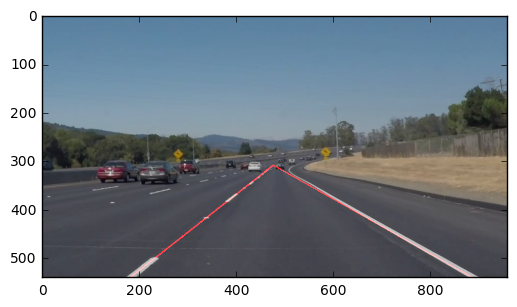

In [71]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [72]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In hough lines
In draw lines
Slope & intercept:  [[0.69897959183673475, -33.525510204081684], [0.64928909952606639, -6.1990521327014676], [0.64948453608247425, -8.3505154639175316], [0.64903846153846156, -6.3557692307692264]]
Slope:  0.649270699049 Intercept:  -6.96844560913
Slope & intercept:  [[-0.60550458715596334, 600.53211009174311], [-0.62790697674418605, 615.83720930232562], [-0.62612612612612617, 614.49549549549556], [-0.60285714285714287, 600.9028571428571], [-0.60119047619047616, 601.125], [-0.58333333333333337, 593.66666666666674], [-0.60135135135135132, 611.24324324324323]]
Slope:  -0.610822776738 Intercept:  607.355985879
Coef:  0.649270699049 Intercept:  -6.96844560913 intersection_x:  487.522904684
Point one:  (487, 309) Point two:  (960, 616)
Coef:  -0.610822776738 Intercept:  607.355985879 intersection_x:  487.522904684
Point one:  (487, 309) Point two:  (0, 607)
(540, 960, 3)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|                                                                                          | 0/682 [00:00<?, ?it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.69897959183673475, -33.525510204081684], [0.64928909952606639, -6.1990521327014676], [0.64948453608247425, -8.3505154639175316], [0.64903846153846156, -6.3557692307692264]]
Slope:  0.649270699049 Intercept:  -6.96844560913
Slope & intercept:  [[-0.60550458715596334, 600.53211009174311], [-0.62790697674418605, 615.83720930232562], [-0.62612612612612617, 614.49549549549556], [-0.60285714285714287, 600.9028571428571], [-0.60119047619047616, 601.125], [-0.58333333333333337, 593.66666666666674], [-0.60135135135135132, 611.24324324324323]]
Slope:  -0.610822776738 Intercept:  607.355985879
Coef:  0.649270699049 Intercept:  -6.96844560913 intersection_x:  487.522904684
Point one:  (487, 309) Point two:  (960, 616)
Coef:  -0.610822776738 Intercept:  607.355985879 intersection_x:  487.522904684
Point one:  (487, 309) Point two:  (0, 607)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.69918699186991873, -33.439024390243901],

  0%|▏                                                                                 | 2/682 [00:00<00:49, 13.80it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.70161290322580649, -35.620967741935488], [0.65040650406504064, -8.0406504065040281]]
Slope:  0.676009703645 Intercept:  -21.8308090742
Slope & intercept:  [[-0.59999999999999998, 601.60000000000002], [-0.64978902953586493, 623.00421940928265], [-0.64516129032258063, 617.32258064516122], [-0.62874251497005984, 617.85029940119762], [-0.58333333333333337, 595.41666666666674], [-0.70491803278688525, 647.44262295081967], [-0.62857142857142856, 617.08571428571429], [-0.60799999999999998, 602.46399999999994]]
Slope:  -0.63106445369 Intercept:  615.27326292
Coef:  0.676009703645 Intercept:  -21.8308090742 intersection_x:  487.427640137
Point one:  (487, 307) Point two:  (960, 627)
Coef:  -0.63106445369 Intercept:  615.27326292 intersection_x:  487.427640137
Point one:  (487, 307) Point two:  (0, 615)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64444444444444449, -3.3333333333333712], [0.69827586206896552, -33.206896551

  1%|▍                                                                                 | 4/682 [00:00<00:48, 14.01it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.70666666666666667, -39.866666666666674], [0.65000000000000002, -9.6000000000000227], [0.6271186440677966, 9.7288135593220204], [0.61702127659574468, 19.468085106383], [0.7142857142857143, -49.85714285714289], [0.65384615384615385, -13.153846153846132], [0.62222222222222223, 14.088888888888903]]
Slope:  0.646145827233 Intercept:  -3.22245421099
Slope & intercept:  [[-0.625, 609.875], [-0.64935064935064934, 625.66233766233768], [-0.60416666666666663, 604.27083333333326], [-0.640625, 615.265625], [-0.62195121951219512, 608.90243902439022]]
Slope:  -0.634231717216 Intercept:  614.926350422
Coef:  0.646145827233 Intercept:  -3.22245421099 intersection_x:  482.786352598
Point one:  (482, 308) Point two:  (960, 617)
Coef:  -0.634231717216 Intercept:  614.926350422 intersection_x:  482.786352598
Point one:  (482, 308) Point two:  (0, 614)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65000000000000002, -4.699999999999988

  1%|▋                                                                                 | 6/682 [00:00<00:48, 13.90it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.72727272727272729, -53.0], [0.6228070175438597, 6.8070175438596152]]
Slope:  0.675039872408 Intercept:  -23.0964912281
Slope & intercept:  [[-0.62574850299401197, 613.08982035928148], [-0.64963503649635035, 627.64963503649631], [-0.62721893491124259, 612.63905325443784], [-0.87931034482758619, 722.68965517241372], [-0.64777327935222673, 628.68825910931173]]
Slope:  -0.685937219716 Intercept:  640.951284586
Coef:  0.675039872408 Intercept:  -23.0964912281 intersection_x:  487.919877312
Point one:  (487, 306) Point two:  (960, 624)
Coef:  -0.685937219716 Intercept:  640.951284586 intersection_x:  487.919877312
Point one:  (487, 306) Point two:  (0, 640)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.67515923566878977, -23.216560509554142], [0.6470588235294118, -10.117647058823536], [0.67307692307692313, -20.346153846153868]]
Slope:  0.665098327425 Intercept:  -17.8934538048
Slope & intercept:  [[-0.62613981762917936

  1%|▉                                                                                 | 8/682 [00:00<00:47, 14.11it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67142857142857137, -19.75714285714281], [0.67441860465116277, -27.767441860465112]]
Slope:  0.67292358804 Intercept:  -23.7622923588
Slope & intercept:  [[-0.62576687116564422, 613.09202453987734], [-0.65346534653465349, 628.42574257425747], [-0.65217391304347827, 629.95652173913049], [-0.62857142857142856, 622.85714285714289], [-0.63636363636363635, 615.18181818181824], [-0.65079365079365081, 629.11111111111109], [-0.5901639344262295, 598.44262295081967], [-0.75510204081632648, 668.32653061224482]]
Slope:  -0.649050102714 Intercept:  625.674189321
Coef:  0.67292358804 Intercept:  -23.7622923588 intersection_x:  491.262788527
Point one:  (491, 306) Point two:  (960, 622)
Coef:  -0.649050102714 Intercept:  625.674189321 intersection_x:  491.262788527
Point one:  (491, 306) Point two:  (0, 625)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.69620253164556967, -35.974683544303844], [0.61818181818181817, 7.87272727272

  1%|█▏                                                                               | 10/682 [00:00<00:47, 14.07it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62135922330097082, 4.4271844660194688], [0.62903225806451613, 6.7096774193548185], [0.72463768115942029, -54.985507246376812]]
Slope:  0.658343054175 Intercept:  -14.6162151203
Slope & intercept:  [[-0.67474048442906576, 636.16262975778545], [-0.6278195488721805, 614.49624060150381], [-0.67241379310344829, 634.82758620689651], [-0.64888888888888885, 620.59555555555551], [-0.609375, 612.5625]]
Slope:  -0.646647543059 Intercept:  623.728902424
Coef:  0.658343054175 Intercept:  -14.6162151203 intersection_x:  489.156871243
Point one:  (489, 307) Point two:  (960, 617)
Coef:  -0.646647543059 Intercept:  623.728902424 intersection_x:  489.156871243
Point one:  (489, 307) Point two:  (0, 623)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.625, 2.375], [0.70085470085470081, -41.811965811965763]]
Slope:  0.662927350427 Intercept:  -19.718482906
Slope & intercept:  [[-0.64918032786885249, 619.72786885245898], [-0.671532846

  2%|█▍                                                                               | 12/682 [00:00<00:47, 14.20it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62658227848101267, 1.4113924050632818], [0.66887417218543044, -21.0], [0.69696969696969702, -39.060606060606062]]
Slope:  0.664142049212 Intercept:  -19.5497378852
Slope & intercept:  [[-0.67567567567567566, 637.64864864864865], [-0.62758620689655176, 615.97931034482758], [-0.6310679611650486, 615.30097087378635], [-0.65030674846625769, 620.93865030674851], [-0.58823529411764708, 602.82352941176475], [-0.67399267399267404, 636.40293040293045], [-0.69444444444444442, 637.63888888888891]]
Slope:  -0.65884561844 Intercept:  627.318233244
Coef:  0.664142049212 Intercept:  -19.5497378852 intersection_x:  488.944823104
Point one:  (488, 305) Point two:  (960, 618)
Coef:  -0.65884561844 Intercept:  627.318233244 intersection_x:  488.944823104
Point one:  (488, 305) Point two:  (0, 627)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62189054726368154, 4.6716417910448058], [0.67264573991031396, -22.116591928251125], [0.692

  2%|█▋                                                                               | 14/682 [00:00<00:47, 14.01it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64976958525345618, -7.1566820276497651], [0.6015625, 19.90625], [0.6228070175438597, 3.0087719298245474]]
Slope:  0.624713034266 Intercept:  5.25277996739
Slope & intercept:  [[-0.64968152866242035, 622.45859872611459], [-0.67500000000000004, 638.57500000000005], [-0.68656716417910446, 640.6567164179105], [-0.68103448275862066, 639.58620689655174], [-0.67368421052631577, 630.50526315789477]]
Slope:  -0.679071464366 Intercept:  637.330796618
Coef:  0.624713034266 Intercept:  5.25277996739 intersection_x:  484.802524738
Point one:  (484, 308) Point two:  (960, 604)
Coef:  -0.679071464366 Intercept:  637.330796618 intersection_x:  484.802524738
Point one:  (484, 308) Point two:  (0, 637)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64772727272727271, -6.0909090909090651], [0.60215053763440862, 19.548387096774206], [0.60317460317460314, 17.968253968253975]]
Slope:  0.617684137845 Intercept:  10.4752439914
Slope & in

  2%|█▉                                                                               | 16/682 [00:01<00:48, 13.67it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.66129032258064513, -17.5], [0.60273972602739723, 20.191780821917803], [0.58064516129032262, 37.0322580645161], [0.60273972602739723, 19.041095890410986], [0.68253968253968256, -32.968253968253975]]
Slope:  0.625990923693 Intercept:  5.15937616172
Slope & intercept:  [[-0.69999999999999996, 646.5], [-0.67355371900826444, 630.44628099173553], [-0.66666666666666663, 627.66666666666663], [-0.69892473118279574, 644.9354838709678], [-0.6741573033707865, 629.60674157303367]]
Slope:  -0.682660484046 Intercept:  635.83103462
Coef:  0.625990923693 Intercept:  5.15937616172 intersection_x:  481.924869166
Point one:  (481, 306) Point two:  (960, 606)
Coef:  -0.682660484046 Intercept:  635.83103462 intersection_x:  481.924869166
Point one:  (481, 306) Point two:  (0, 635)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.5957446808510638, 24.297872340425556], [0.62068965517241381, 5.068965517241395]]
Slope:  0.608217168012 Interc

  3%|██▏                                                                              | 18/682 [00:01<00:48, 13.81it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59459459459459463, 20.621621621621614], [0.61904761904761907, 10.90476190476187]]
Slope:  0.606821106821 Intercept:  15.7631917632
Slope & intercept:  [[-0.7007299270072993, 646.61313868613138], [-0.67515923566878977, 630.82165605095543], [-0.72398190045248867, 653.61990950226243], [-0.6518518518518519, 626.0]]
Slope:  -0.687930728745 Intercept:  639.26367606
Coef:  0.606821106821 Intercept:  15.7631917632 intersection_x:  481.559838086
Point one:  (481, 307) Point two:  (960, 598)
Coef:  -0.687930728745 Intercept:  639.26367606 intersection_x:  481.559838086
Point one:  (481, 307) Point two:  (0, 639)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62204724409448819, 8.7716535433070817], [0.59541984732824427, 19.770992366412202]]
Slope:  0.608733545711 Intercept:  14.2713229549
Slope & intercept:  [[-0.70181818181818179, 646.08000000000004], [-0.67307692307692313, 629.53846153846155], [-0.67419354838709677, 630.69

  3%|██▍                                                                              | 20/682 [00:01<00:47, 13.82it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62790697674418605, -1.5348837209302246]]
Slope & intercept:  [[-0.67524115755627012, 630.15755627009651], [-0.70300751879699253, 646.26315789473688], [-0.7008928571428571, 646.63839285714289], [-0.6542553191489362, 623.60106382978722]]
Slope:  -0.683349213161 Intercept:  636.665042713
Coef:  0.627906976744 Intercept:  -1.53488372093 intersection_x:  486.708799811
Point one:  (486, 304) Point two:  (960, 601)
Coef:  -0.683349213161 Intercept:  636.665042713 intersection_x:  486.708799811
Point one:  (486, 304) Point two:  (0, 636)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65000000000000002, -10.25], [0.61224489795918369, 7.959183673469397]]
Slope:  0.63112244898 Intercept:  -1.14540816327
Slope & intercept:  [[-0.70188679245283014, 645.38867924528302], [-0.67313915857605178, 628.20064724919098], [-0.63291139240506333, 614.51898734177212], [-0.63095238095238093, 614.52380952380952], [-0.70046082949308752, 645.8

  3%|██▌                                                                              | 22/682 [00:01<00:46, 14.28it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.61904761904761907, 4.5238095238095184], [0.64583333333333337, -7.6875], [0.64444444444444449, -13.53333333333336]]
Slope:  0.636441798942 Intercept:  -5.56567460317
Slope & intercept:  [[-0.67307692307692313, 628.51923076923072], [-0.70037453183520604, 644.45692883895128], [-0.66981132075471694, 626.41509433962267], [-0.70192307692307687, 639.23076923076928]]
Slope:  -0.686296463147 Intercept:  634.655505795
Coef:  0.636441798942 Intercept:  -5.56567460317 intersection_x:  484.011991448
Point one:  (484, 302) Point two:  (960, 605)
Coef:  -0.686296463147 Intercept:  634.655505795 intersection_x:  484.011991448
Point one:  (484, 302) Point two:  (0, 634)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59999999999999998, 17.199999999999989], [0.65217391304347827, -11.347826086956502]]
Slope:  0.626086956522 Intercept:  2.92608695652
Slope & intercept:  [[-0.70188679245283014, 645.38867924528302], [-0.6730769230769231

  4%|██▊                                                                              | 24/682 [00:01<00:49, 13.39it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62416107382550334, 0.26174496644296141], [0.6467065868263473, -7.149700598802383]]
Slope:  0.635433830326 Intercept:  -3.44397781618
Slope & intercept:  [[-0.70370370370370372, 648.07407407407413], [-0.67399267399267404, 629.90476190476193], [-0.67403314917127077, 630.90055248618785], [-0.70229007633587781, 646.15267175572512], [-0.68965517241379315, 631.93103448275861]]
Slope:  -0.688734955123 Intercept:  637.392618941
Coef:  0.635433830326 Intercept:  -3.44397781618 intersection_x:  483.953861319
Point one:  (483, 304) Point two:  (960, 606)
Coef:  -0.688734955123 Intercept:  637.392618941 intersection_x:  483.953861319
Point one:  (483, 304) Point two:  (0, 637)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64878048780487807, -9.5365853658536821], [0.6216216216216216, 1.9729729729729684], [0.67241379310344829, -24.879310344827616], [0.59893048128342241, 19.657754010695214], [0.62068965517241381, 11.41379310344

  4%|███                                                                              | 26/682 [00:01<00:48, 13.47it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59836065573770492, 17.827868852459005], [0.6244343891402715, 7.6018099547511042], [0.65022421524663676, -12.390134529147986], [0.58441558441558439, 27.389610389610425]]
Slope:  0.614358711135 Intercept:  10.1072886669
Slope & intercept:  [[-0.67576791808873715, 632.93174061433444], [-0.69620253164556967, 648.69620253164555], [-0.70833333333333337, 649.41666666666674], [-0.72631578947368425, 654.48421052631579], [-0.75510204081632648, 662.69387755102036], [-0.75471698113207553, 666.81132075471703], [-0.68041237113402064, 644.37113402061857], [-0.68852459016393441, 644.0], [-0.60447761194029848, 618.59701492537317], [-0.65217391304347827, 636.04347826086951]]
Slope:  -0.704172163203 Intercept:  648.827625658
Coef:  0.614358711135 Intercept:  10.1072886669 intersection_x:  484.418188017
Point one:  (484, 307) Point two:  (960, 599)
Coef:  -0.704172163203 Intercept:  648.827625658 intersection_x:  484.418188017
Point one:  (484, 307) Poi

  4%|███▎                                                                             | 28/682 [00:02<00:47, 13.71it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57999999999999996, 30.500000000000057], [0.6179775280898876, 9.6292134831460885], [0.59999999999999998, 13.600000000000023], [0.62121212121212122, 5.7272727272727479]]
Slope:  0.604797412326 Intercept:  14.8641215526
Slope & intercept:  [[-0.6768707482993197, 632.08503401360542], [-0.72727272727272729, 655.09090909090912], [-0.65445026178010468, 627.81675392670149], [-0.7239263803680982, 656.05521472392638], [-0.69491525423728817, 636.28813559322032], [-0.72043010752688175, 648.70967741935488], [-0.70046082949308752, 638.89400921658989], [-0.75342465753424659, 664.50684931506851]]
Slope:  -0.713900100676 Intercept:  647.37568991
Coef:  0.604797412326 Intercept:  14.8641215526 intersection_x:  479.648715586
Point one:  (479, 304) Point two:  (960, 595)
Coef:  -0.713900100676 Intercept:  647.37568991 intersection_x:  479.648715586
Point one:  (479, 304) Point two:  (0, 647)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept: 

  4%|███▌                                                                             | 30/682 [00:02<00:46, 14.01it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.61855670103092786, 5.9587628865979241]]
Slope & intercept:  [[-0.72950819672131151, 657.18032786885249], [-0.67730496453900713, 633.5], [-0.67636363636363639, 634.36727272727273], [-0.7191011235955056, 647.68539325842698], [-0.70629370629370625, 651.07692307692309]]
Slope:  -0.701714325503 Intercept:  644.761983386
Coef:  0.618556701031 Intercept:  5.9587628866 intersection_x:  483.842489657
Point one:  (483, 305) Point two:  (960, 599)
Coef:  -0.701714325503 Intercept:  644.761983386 intersection_x:  483.842489657
Point one:  (483, 305) Point two:  (0, 644)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62393162393162394, 3.2649572649572747], [0.59999999999999998, 17.400000000000034]]
Slope:  0.611965811966 Intercept:  10.3324786325
Slope & intercept:  [[-0.72641509433962259, 657.40566037735846], [-0.67636363636363639, 634.04363636363632], [-0.7441860465116279, 660.04651162790697], [-0.6796875, 634.1875], [-0.681

  5%|███▊                                                                             | 32/682 [00:02<00:45, 14.20it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6223776223776224, 3.2167832167831989]]
Slope & intercept:  [[-0.72844827586206895, 656.73706896551721], [-0.70149253731343286, 639.95522388059703], [-0.67657992565055758, 634.10408921933083], [-0.72727272727272729, 657.27272727272725], [-0.68085106382978722, 634.04255319148933], [-0.69491525423728817, 638.37288135593224]]
Slope:  -0.701593297361 Intercept:  643.414090648
Coef:  0.622377622378 Intercept:  3.21678321678 intersection_x:  483.543330058
Point one:  (483, 304) Point two:  (960, 600)
Coef:  -0.701593297361 Intercept:  643.414090648 intersection_x:  483.543330058
Point one:  (483, 304) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.60869565217391308, 12.043478260869563]]
Slope & intercept:  [[-0.72477064220183485, 657.58715596330273], [-0.67894736842105263, 635.04736842105262], [-0.7010309278350515, 640.64948453608247], [-0.85915492957746475, 704.85915492957747], [-0.86301369863013699

  5%|████                                                                             | 34/682 [00:02<00:45, 14.29it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.61111111111111116, 11.4444444444444], [0.62, -1.8000000000000114], [0.59999999999999998, 12.400000000000034]]
Slope:  0.61037037037 Intercept:  7.34814814815
Slope & intercept:  [[-0.69230769230769229, 638.38461538461536], [-0.72463768115942029, 658.28985507246375], [-0.70175438596491224, 641.45614035087715], [-0.80612244897959184, 684.66326530612241], [-0.83505154639175261, 693.73195876288662], [-0.72185430463576161, 648.4503311258278], [-0.82758620689655171, 694.82758620689651], [-0.72511848341232232, 659.36966824644549]]
Slope:  -0.754304093719 Intercept:  664.896677557
Coef:  0.61037037037 Intercept:  7.34814814815 intersection_x:  481.835446264
Point one:  (481, 301) Point two:  (960, 593)
Coef:  -0.754304093719 Intercept:  664.896677557 intersection_x:  481.835446264
Point one:  (481, 301) Point two:  (0, 664)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.61538461538461542, 8.3846153846153584], [0.591549295

  5%|████▎                                                                            | 36/682 [00:02<00:44, 14.53it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62195121951219512, 3.4878048780487916], [0.57954545454545459, 25.659090909090878]]
Slope:  0.600748337029 Intercept:  14.5734478936
Slope & intercept:  [[-0.75524475524475521, 666.74825174825173], [-0.72674418604651159, 648.41860465116281], [-0.671875, 636.09375], [-0.74509803921568629, 662.43137254901967], [-0.75416666666666665, 664.94583333333333], [-0.70106761565836295, 640.16014234875445], [-0.70289855072463769, 642.02898550724638]]
Slope:  -0.730869968926 Intercept:  654.122198356
Coef:  0.600748337029 Intercept:  14.5734478936 intersection_x:  480.279332
Point one:  (480, 303) Point two:  (960, 591)
Coef:  -0.730869968926 Intercept:  654.122198356 intersection_x:  480.279332
Point one:  (480, 303) Point two:  (0, 654)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57657657657657657, 27.810810810810835], [0.64516129032258063, -13.129032258064512], [0.55172413793103448, 48.344827586206918], [0.6700000000000000

  6%|████▌                                                                            | 38/682 [00:02<00:44, 14.43it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57727272727272727, 27.513636363636351], [0.59712230215827333, 20.582733812949698], [0.58181818181818179, 32.672727272727286], [0.64885496183206104, -19.007633587786245], [0.59999999999999998, 10.0]]
Slope:  0.589053302812 Intercept:  22.6922743623
Slope & intercept:  [[-0.70512820512820518, 640.32051282051282], [-0.7544642857142857, 664.75], [-0.72027972027972031, 644.88111888111894], [-0.6785714285714286, 632.57142857142856], [-0.70270270270270274, 640.35135135135135], [-0.8666666666666667, 704.26666666666665]]
Slope:  -0.737968834844 Intercept:  654.523513049
Coef:  0.589053302812 Intercept:  22.6922743623 intersection_x:  476.127127617
Point one:  (476, 303) Point two:  (960, 588)
Coef:  -0.737968834844 Intercept:  654.523513049 intersection_x:  476.127127617
Point one:  (476, 303) Point two:  (0, 654)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6166666666666667, 7.0833333333333144], [0.57707509881422925, 27

  6%|████▊                                                                            | 40/682 [00:02<00:46, 13.89it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62211981566820274, 1.7327188940092242], [0.57599999999999996, 28.816000000000031]]
Slope:  0.599059907834 Intercept:  15.274359447
Slope & intercept:  [[-0.75431034482758619, 663.2155172413793], [-0.70106761565836295, 638.95373665480429], [-0.7009345794392523, 638.10280373831779], [-0.76923076923076927, 663.53846153846155]]
Slope:  -0.731385827289 Intercept:  650.952629793
Coef:  0.599059907834 Intercept:  15.274359447 intersection_x:  477.793459413
Point one:  (477, 301) Point two:  (960, 590)
Coef:  -0.731385827289 Intercept:  650.952629793 intersection_x:  477.793459413
Point one:  (477, 301) Point two:  (0, 650)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.63380281690140849, -7.7042253521127009], [0.55555555555555558, 47.0], [0.59740259740259738, 12.090909090909122]]
Slope:  0.595586989953 Intercept:  17.1288945796
Slope & intercept:  [[-0.75536480686695284, 663.63519313304721], [-0.70181818181818179, 639.76

  6%|████▉                                                                            | 42/682 [00:02<00:45, 14.07it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.5714285714285714, 33.428571428571445]]
Slope & intercept:  [[-0.75376884422110557, 663.2010050251256], [-0.70138888888888884, 638.29861111111109], [-0.70106761565836295, 638.95373665480429], [-0.76470588235294112, 664.29411764705878], [-0.77777777777777779, 666.0], [-0.76363636363636367, 665.72727272727275]]
Slope:  -0.743724228756 Intercept:  656.079123861
Coef:  0.571428571429 Intercept:  33.4285714286 intersection_x:  473.443505838
Point one:  (473, 303) Point two:  (960, 582)
Coef:  -0.743724228756 Intercept:  656.079123861 intersection_x:  473.443505838
Point one:  (473, 303) Point two:  (0, 656)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.60377358490566035, 14.943396226415132]]
Slope & intercept:  [[-0.75494071146245056, 662.81027667984188], [-0.69999999999999996, 638.10000000000002], [-0.80689655172413788, 678.6689655172413], [-0.75, 655.5], [-0.73999999999999999, 658.75999999999999], [-0.700704225352112

  6%|█████▏                                                                           | 44/682 [00:03<00:46, 13.79it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57723577235772361, 33.0]]
Slope & intercept:  [[-0.70138888888888884, 639.70138888888891], [-0.75527426160337552, 664.37552742616037], [-0.7021276595744681, 639.02127659574467], [-0.75308641975308643, 664.62962962962956]]
Slope:  -0.727969307455 Intercept:  651.931955635
Coef:  0.577235772358 Intercept:  33.0 intersection_x:  474.202840004
Point one:  (474, 306) Point two:  (960, 587)
Coef:  -0.727969307455 Intercept:  651.931955635 intersection_x:  474.202840004
Point one:  (474, 306) Point two:  (0, 651)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59999999999999998, 19.199999999999989]]
Slope & intercept:  [[-0.70205479452054798, 639.79794520547944], [-0.75572519083969469, 663.69465648854964], [-0.80555555555555558, 678.0], [-0.80419580419580416, 678.76223776223776], [-0.73913043478260865, 659.6521739130435], [-0.72580645161290325, 646.5645161290322]]
Slope:  -0.755411371918 Intercept:  661.07858825
Coef:  0.

  7%|█████▍                                                                           | 46/682 [00:03<00:46, 13.82it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62, 7.839999999999975], [0.61111111111111116, 6.6666666666666288], [0.59615384615384615, 21.384615384615415]]
Slope:  0.609088319088 Intercept:  11.9637606838
Slope & intercept:  [[-0.7558139534883721, 664.46511627906978], [-0.70175438596491224, 640.75438596491222], [-0.74725274725274726, 655.34065934065939], [-0.75, 655.75], [-0.72558139534883725, 657.7209302325582], [-0.69965870307167233, 639.45051194539246]]
Slope:  -0.730010197521 Intercept:  652.24693396
Coef:  0.609088319088 Intercept:  11.9637606838 intersection_x:  478.14493507
Point one:  (478, 303) Point two:  (960, 596)
Coef:  -0.730010197521 Intercept:  652.24693396 intersection_x:  478.14493507
Point one:  (478, 303) Point two:  (0, 652)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.60606060606060608, 10.757575757575751], [0.6166666666666667, 10.116666666666674]]
Slope:  0.611363636364 Intercept:  10.4371212121
Slope & intercept:  [[-0.75510204081632

  7%|█████▋                                                                           | 48/682 [00:03<00:46, 13.52it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6216216216216216, 6.5405405405405759], [0.57317073170731703, 32.304878048780495], [0.57971014492753625, 26.927536231884062], [0.62295081967213117, 4.3442622950819327]]
Slope:  0.599363329482 Intercept:  17.5293042791
Slope & intercept:  [[-0.75336322869955152, 663.56502242152465], [-0.70068027210884354, 639.59863945578229], [-0.76470588235294112, 665.17647058823525], [-0.70056497175141241, 638.74576271186447], [-0.74137931034482762, 658.22413793103442], [-0.67948717948717952, 629.93589743589746]]
Slope:  -0.723363474124 Intercept:  649.207655091
Coef:  0.599363329482 Intercept:  17.5293042791 intersection_x:  477.557685449
Point one:  (477, 303) Point two:  (960, 592)
Coef:  -0.723363474124 Intercept:  649.207655091 intersection_x:  477.557685449
Point one:  (477, 303) Point two:  (0, 649)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59183673469387754, 18.612244897959215], [0.65000000000000002, -15.1999999999999

  7%|█████▉                                                                           | 50/682 [00:03<00:48, 12.98it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59523809523809523, 16.452380952380963], [0.5950413223140496, 24.942148760330554], [0.64227642276422769, -8.7886178861788835]]
Slope:  0.610851946772 Intercept:  10.8686372755
Slope & intercept:  [[-0.72222222222222221, 644.77777777777783], [-0.75348837209302322, 663.32558139534888], [-0.70059880239520955, 638.88622754491018], [-0.75091575091575091, 661.15018315018312], [-0.70138888888888884, 638.70138888888891], [-0.75423728813559321, 663.20338983050851]]
Slope:  -0.730475220775 Intercept:  651.674091431
Coef:  0.610851946772 Intercept:  10.8686372755 intersection_x:  477.739860684
Point one:  (477, 302) Point two:  (960, 597)
Coef:  -0.730475220775 Intercept:  651.674091431 intersection_x:  477.739860684
Point one:  (477, 302) Point two:  (0, 651)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57539682539682535, 31.678571428571445], [0.62231759656652363, 4.9184549356223215], [0.59999999999999998, 12.8000000000000

  8%|██████▏                                                                          | 52/682 [00:03<00:49, 12.68it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59745762711864403, 14.029661016949149], [0.59999999999999998, 23.800000000000011], [0.5892857142857143, 30.946428571428555], [0.57723577235772361, 30.544715447154431], [0.57586206896551728, 32.696551724137919]]
Slope:  0.587968236546 Intercept:  26.4034713519
Slope & intercept:  [[-0.70204081632653059, 638.39183673469392], [-0.75289575289575295, 662.76833976833973], [-0.75187969924812026, 661.30827067669168], [-0.70068027210884354, 639.19727891156458], [-0.67741935483870963, 629.38709677419354]]
Slope:  -0.716983179084 Intercept:  646.210564573
Coef:  0.587968236546 Intercept:  26.4034713519 intersection_x:  474.965646842
Point one:  (474, 305) Point two:  (960, 590)
Coef:  -0.716983179084 Intercept:  646.210564573 intersection_x:  474.965646842
Point one:  (474, 305) Point two:  (0, 646)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57692307692307687, 32.038461538461604], [0.62244897959183676, 5.1836734693877133

  8%|██████▍                                                                          | 54/682 [00:03<00:49, 12.65it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57692307692307687, 32.615384615384642], [0.61224489795918369, 14.530612244897952], [0.62, 7.2800000000000296]]
Slope:  0.603055991627 Intercept:  18.1419989534
Slope & intercept:  [[-0.75287356321839083, 663.5], [-0.70270270270270274, 638.78378378378375], [-0.7678571428571429, 664.82142857142856], [-0.76595744680851063, 665.63829787234044], [-0.6992481203007519, 638.57142857142856], [-0.75107296137339052, 662.22317596566518], [-0.6741573033707865, 628.23595505617982]]
Slope:  -0.739951989543 Intercept:  655.589685794
Coef:  0.603055991627 Intercept:  18.1419989534 intersection_x:  474.641771142
Point one:  (474, 304) Point two:  (960, 597)
Coef:  -0.739951989543 Intercept:  655.589685794 intersection_x:  474.641771142
Point one:  (474, 304) Point two:  (0, 655)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.55769230769230771, 45.634615384615358]]
Slope & intercept:  [[-0.70250896057347667, 637.75627240143365], [-0

  8%|██████▋                                                                          | 56/682 [00:04<00:49, 12.68it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57391304347826089, 31.9304347826087]]
Slope & intercept:  [[-0.70036101083032487, 636.75090252707582], [-0.75105485232067515, 661.21097046413502], [-0.72950819672131151, 656.18032786885249], [-0.71900826446280997, 643.15702479338847]]
Slope:  -0.724983081084 Intercept:  649.324806413
Coef:  0.573913043478 Intercept:  31.9304347826 intersection_x:  475.322360238
Point one:  (475, 304) Point two:  (960, 582)
Coef:  -0.724983081084 Intercept:  649.324806413 intersection_x:  475.322360238
Point one:  (475, 304) Point two:  (0, 649)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62345679012345678, 7.3827160493827364], [0.59722222222222221, 18.083333333333314]]
Slope:  0.610339506173 Intercept:  12.7330246914
Slope & intercept:  [[-0.70175438596491224, 637.64912280701753], [-0.75103734439834025, 661.7053941908714], [-0.75121951219512195, 661.2146341463415], [-0.70161290322580649, 638.62903225806451], [-0.764705882352941

  9%|██████▉                                                                          | 58/682 [00:04<00:50, 12.47it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60869565217391308, 10.043478260869563], [0.61363636363636365, 13.681818181818187], [0.65217391304347827, -15.434782608695684]]
Slope:  0.624835309618 Intercept:  2.76350461133
Slope & intercept:  [[-0.70289855072463769, 638.10869565217388], [-0.75, 660.75], [-0.75138121546961323, 661.8563535911602], [-0.76595744680851063, 663.10638297872345]]
Slope:  -0.755779554093 Intercept:  661.904245523
Coef:  0.624835309618 Intercept:  2.76350461133 intersection_x:  477.425499491
Point one:  (477, 301) Point two:  (960, 602)
Coef:  -0.755779554093 Intercept:  661.904245523 intersection_x:  477.425499491
Point one:  (477, 301) Point two:  (0, 661)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62222222222222223, 7.8666666666666742], [0.59999999999999998, 17.0], [0.60377358490566035, 20.867924528301899]]
Slope:  0.608665269043 Intercept:  15.2448637317
Slope & intercept:  [[-0.69930069930069927, 635.90209790209792], [-0.748603

  9%|███████▏                                                                         | 60/682 [00:04<00:50, 12.34it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59999999999999998, 18.0], [0.62264150943396224, 8.2641509433962597]]
Slope:  0.611320754717 Intercept:  13.1320754717
Slope & intercept:  [[-0.70070422535211263, 637.09859154929575], [-0.72830188679245278, 653.79999999999995], [-0.72692307692307689, 654.30769230769226], [-0.67721518987341767, 629.65189873417717], [-0.71999999999999997, 650.20000000000005]]
Slope:  -0.718982297267 Intercept:  648.851570964
Coef:  0.611320754717 Intercept:  13.1320754717 intersection_x:  477.875694974
Point one:  (477, 305) Point two:  (960, 600)
Coef:  -0.718982297267 Intercept:  648.851570964 intersection_x:  477.875694974
Point one:  (477, 305) Point two:  (0, 648)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62204724409448819, 8.2598425196850371], [0.59701492537313428, 18.38805970149258]]
Slope:  0.609531084734 Intercept:  13.3239511106
Slope & intercept:  [[-0.72692307692307689, 652.85384615384612], [-0.69930069930069927, 635

  9%|███████▎                                                                         | 62/682 [00:04<00:50, 12.18it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.625, 7.5], [0.59638554216867468, 20.186746987951835], [0.57894736842105265, 30.842105263157862], [0.59405940594059403, 27.326732673267372], [0.61702127659574468, 3.9787234042553337]]
Slope:  0.602282718625 Intercept:  17.9668616657
Slope & intercept:  [[-0.69711538461538458, 634.57692307692309], [-0.72592592592592597, 651.24444444444441], [-0.71666666666666667, 636.95000000000005], [-0.72535211267605637, 650.42957746478874], [-0.69930069930069927, 635.90909090909088], [-0.70731707317073167, 634.19512195121956], [-0.71153846153846156, 636.76923076923072]]
Slope:  -0.711888046271 Intercept:  640.010626945
Coef:  0.602282718625 Intercept:  17.9668616657 intersection_x:  473.335567869
Point one:  (473, 303) Point two:  (960, 596)
Coef:  -0.711888046271 Intercept:  640.010626945 intersection_x:  473.335567869
Point one:  (473, 303) Point two:  (0, 640)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6228813559322034, 7.

  9%|███████▌                                                                         | 64/682 [00:04<00:51, 11.97it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62411347517730498, 7.5035460992907588], [0.59999999999999998, 16.199999999999989], [0.59829059829059827, 18.470085470085507], [0.6470588235294118, -8.4705882352941444]]
Slope:  0.617365724249 Intercept:  8.42576083352
Slope & intercept:  [[-0.72661870503597126, 652.35251798561148], [-0.67656765676567654, 629.36633663366342], [-0.68235294117647061, 630.08235294117651], [-0.65363128491620115, 624.95530726256982], [-0.74509803921568629, 654.98039215686276], [-0.69230769230769229, 633.15384615384619]]
Slope:  -0.696096053236 Intercept:  637.481792189
Coef:  0.617365724249 Intercept:  8.42576083352 intersection_x:  478.929834228
Point one:  (478, 304) Point two:  (960, 601)
Coef:  -0.696096053236 Intercept:  637.481792189 intersection_x:  478.929834228
Point one:  (478, 304) Point two:  (0, 637)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57599999999999996, 35.456000000000017], [0.62773722627737227, 6.05109489051096

 10%|███████▊                                                                         | 66/682 [00:04<00:51, 11.90it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60493827160493829, 13.913580246913568], [0.60526315789473684, 24.131578947368439], [0.57317073170731703, 36.853658536585385], [0.57499999999999996, 36.800000000000011], [0.63793103448275867, -5.568965517241395]]
Slope:  0.589593040302 Intercept:  27.9247044327
Slope & intercept:  [[-0.72791519434628971, 653.01060070671383], [-0.69999999999999996, 637.89999999999998], [-0.6972111553784861, 635.70916334661354], [-0.69599999999999995, 635.048], [-0.72692307692307689, 653.85384615384612]]
Slope:  -0.70960988533 Intercept:  643.104322041
Coef:  0.589593040302 Intercept:  27.9247044327 intersection_x:  473.505412797
Point one:  (473, 307) Point two:  (960, 593)
Coef:  -0.70960988533 Intercept:  643.104322041 intersection_x:  473.505412797
Point one:  (473, 307) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64367816091954022, -6.9080459770115112], [0.62068965517241381, 10.379310344827559], [0.593023

 10%|████████                                                                         | 68/682 [00:05<00:52, 11.72it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59433962264150941, 27.122641509433947], [0.57272727272727275, 35.090909090909065]]
Slope:  0.583533447684 Intercept:  31.1067753002
Slope & intercept:  [[-0.72569444444444442, 652.65972222222217], [-0.69444444444444442, 635.27777777777783], [-0.72627737226277367, 653.75182481751824], [-0.72115384615384615, 645.49038461538464], [-0.69841269841269837, 635.07936507936506], [-0.70085470085470081, 638.46153846153845], [-0.70833333333333337, 639.75]]
Slope:  -0.710738691415 Intercept:  642.924373282
Coef:  0.583533447684 Intercept:  31.1067753002 intersection_x:  472.71171147
Point one:  (472, 306) Point two:  (960, 591)
Coef:  -0.710738691415 Intercept:  642.924373282 intersection_x:  472.71171147
Point one:  (472, 306) Point two:  (0, 642)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59523809523809523, 26.428571428571445], [0.5725190839694656, 35.206106870229007]]
Slope:  0.583878589604 Intercept:  30.8173391494
Slo

 10%|████████▎                                                                        | 70/682 [00:05<00:51, 11.87it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64179104477611937, -2.4626865671641553], [0.59459459459459463, 23.10810810810807]]
Slope:  0.618192819685 Intercept:  10.3227107705
Slope & intercept:  [[-0.67615658362989328, 630.56583629893237], [-0.72499999999999998, 652.54999999999995], [-0.7265625, 654.34375], [-0.68367346938775508, 633.34693877551024], [-0.72164948453608246, 646.58762886597935]]
Slope:  -0.706608407511 Intercept:  643.478830788
Coef:  0.618192819685 Intercept:  10.3227107705 intersection_x:  477.925372516
Point one:  (477, 305) Point two:  (960, 603)
Coef:  -0.706608407511 Intercept:  643.478830788 intersection_x:  477.925372516
Point one:  (477, 305) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62650602409638556, 7.7590361445783174], [0.5955056179775281, 22.39325842696627], [0.61363636363636365, 10.0]]
Slope:  0.61188266857 Intercept:  13.3840981905
Slope & intercept:  [[-0.6763754045307443, 630.66343042071196], [-0.7

 11%|████████▌                                                                        | 72/682 [00:05<00:51, 11.94it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60194174757281549, 18.067961165048587], [0.61403508771929827, 16.912280701754355]]
Slope:  0.607988417646 Intercept:  17.4901209334
Slope & intercept:  [[-0.67532467532467533, 630.51948051948057], [-0.70491803278688525, 647.90163934426232], [-0.67558528428093645, 631.55518394648834], [-0.70629370629370625, 647.51048951048949], [-0.69047619047619047, 641.28571428571422], [-0.74509803921568629, 656.15686274509812], [-0.61403508771929827, 607.82456140350882]]
Slope:  -0.699615988063 Intercept:  642.488228392
Coef:  0.607988417646 Intercept:  17.4901209334 intersection_x:  477.971858102
Point one:  (477, 308) Point two:  (960, 601)
Coef:  -0.699615988063 Intercept:  642.488228392 intersection_x:  477.971858102
Point one:  (477, 308) Point two:  (0, 642)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.66666666666666663, -16.666666666666629], [0.60330578512396693, 17.049586776859485], [0.64492753623188404, -3.44927536231

 11%|████████▊                                                                        | 74/682 [00:05<00:50, 11.94it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62352941176470589, 12.447058823529403], [0.58011049723756902, 33.977900552486233], [0.59999999999999998, 20.800000000000011]]
Slope:  0.601213303001 Intercept:  22.408319792
Slope & intercept:  [[-0.67567567567567566, 632.24324324324323], [-0.67567567567567566, 630.70270270270271], [-0.70053475935828879, 647.98395721925135], [-0.70967741935483875, 648.61290322580646], [-0.70053475935828879, 648.68449197860969], [-0.77586206896551724, 670.94827586206895], [-0.63, 618.02999999999997], [-0.67647058823529416, 631.35294117647061]]
Slope:  -0.702061563803 Intercept:  644.361216487
Coef:  0.601213303001 Intercept:  22.408319792 intersection_x:  477.223118881
Point one:  (477, 309) Point two:  (960, 599)
Coef:  -0.702061563803 Intercept:  644.361216487 intersection_x:  477.223118881
Point one:  (477, 309) Point two:  (0, 644)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64903846153846156, -4.8125], [0.59708737864077666,

 11%|█████████                                                                        | 76/682 [00:05<00:50, 11.91it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59782608695652173, 23.423913043478251], [0.65000000000000002, -4.5500000000000114], [0.6472868217054264, -3.7751937984496067], [0.64622641509433965, -4.1981132075471805]]
Slope:  0.635334830939 Intercept:  2.72515150937
Slope & intercept:  [[-0.67567567567567566, 632.59459459459458], [-0.72852233676975942, 654.8350515463917], [-0.69999999999999996, 639.5], [-0.80701754385964908, 682.78947368421052], [-0.63063063063063063, 618.90090090090087], [-0.70769230769230773, 649.53846153846155]]
Slope:  -0.708256415771 Intercept:  646.359747044
Coef:  0.635334830939 Intercept:  2.72515150937 intersection_x:  479.040479841
Point one:  (479, 307) Point two:  (960, 612)
Coef:  -0.708256415771 Intercept:  646.359747044 intersection_x:  479.040479841
Point one:  (479, 307) Point two:  (0, 646)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59999999999999998, 22.400000000000034], [0.62612612612612617, 11.054054054054006], [0.6153

 11%|█████████▎                                                                       | 78/682 [00:05<00:52, 11.46it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59813084112149528, 23.607476635514047], [0.62745098039215685, 11.941176470588232], [0.63, 8.4300000000000068], [0.61764705882352944, 13.558823529411768]]
Slope:  0.618307220084 Intercept:  14.3843691589
Slope & intercept:  [[-0.67524115755627012, 630.50803858520896], [-0.70769230769230773, 648.39999999999998], [-0.74137931034482762, 654.56896551724139], [-0.7142857142857143, 649.57142857142856], [-0.68965517241379315, 645.17241379310349], [-0.67241379310344829, 643.56896551724139], [-0.67567567567567566, 631.91891891891896], [-0.7009345794392523, 645.77570093457939], [-0.63291139240506333, 615.18987341772151]]
Slope:  -0.697159713814 Intercept:  643.68555398
Coef:  0.618307220084 Intercept:  14.3843691589 intersection_x:  478.386167379
Point one:  (478, 310) Point two:  (960, 607)
Coef:  -0.697159713814 Intercept:  643.68555398 intersection_x:  478.386167379
Point one:  (478, 310) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In 

 12%|█████████▌                                                                       | 80/682 [00:06<00:51, 11.59it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64367816091954022, -1.3333333333333144], [0.59999999999999998, 18.400000000000034], [0.61956521739130432, 7.7934782608695627]]
Slope:  0.621081126104 Intercept:  8.28671497585
Slope & intercept:  [[-0.72473867595818819, 652.68292682926835], [-0.69777777777777783, 636.34666666666669], [-0.72727272727272729, 654.36363636363637], [-0.69230769230769229, 634.0], [-0.70068027210884354, 638.39455782312928]]
Slope:  -0.708555429085 Intercept:  643.157557537
Coef:  0.621081126104 Intercept:  8.28671497585 intersection_x:  477.47697676
Point one:  (477, 304) Point two:  (960, 604)
Coef:  -0.708555429085 Intercept:  643.157557537 intersection_x:  477.47697676
Point one:  (477, 304) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59813084112149528, 19.504672897196315], [0.625, 9.375]]
Slope:  0.611565420561 Intercept:  14.4398364486
Slope & intercept:  [[-0.72664359861591699, 652.35640138408303], [-0.69897

 12%|█████████▋                                                                       | 82/682 [00:06<00:51, 11.66it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.61904761904761907, 12.523809523809518], [0.59848484848484851, 21.5], [0.64754098360655743, -3.6967213114754145], [0.5968992248062015, 20.651162790697697]]
Slope:  0.604810564113 Intercept:  18.2249907715
Slope & intercept:  [[-0.72444444444444445, 652.10222222222228], [-0.69696969696969702, 636.0], [-0.6964285714285714, 634.28571428571422], [-0.7142857142857143, 648.0], [-0.70491803278688525, 634.1639344262295], [-0.77536231884057971, 661.195652173913], [-0.67419354838709677, 629.01612903225805]]
Slope:  -0.71237176102 Intercept:  642.109093163
Coef:  0.604810564113 Intercept:  18.2249907715 intersection_x:  473.650526952
Point one:  (473, 304) Point two:  (960, 598)
Coef:  -0.71237176102 Intercept:  642.109093163 intersection_x:  473.650526952
Point one:  (473, 304) Point two:  (0, 642)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64666666666666661, -9.8799999999999386], [0.69491525423728817, -32.79661016949154

 12%|█████████▉                                                                       | 84/682 [00:06<00:51, 11.70it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.63461538461538458, 4.7884615384615472], [0.62264150943396224, 5.6981132075471805], [0.67441860465116277, -21.790697674418595]]
Slope:  0.6438918329 Intercept:  -3.76804097614
Slope & intercept:  [[-0.67441860465116277, 627.69767441860461], [-0.72413793103448276, 651.24137931034488], [-0.72641509433962259, 650.59433962264154], [-0.71666666666666667, 642.86666666666667]]
Slope:  -0.722406564014 Intercept:  648.234128533
Coef:  0.6438918329 Intercept:  -3.76804097614 intersection_x:  477.203348099
Point one:  (477, 303) Point two:  (960, 614)
Coef:  -0.722406564014 Intercept:  648.234128533 intersection_x:  477.203348099
Point one:  (477, 303) Point two:  (0, 648)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.61682242990654201, 9.39252336448601], [0.65000000000000002, -5.6500000000000341]]
Slope:  0.633411214953 Intercept:  1.87126168224
Slope & intercept:  [[-0.67399267399267404, 626.96703296703299], [-0.7054263565

 13%|██████████▏                                                                      | 86/682 [00:06<00:50, 11.71it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.65068493150684936, -5.7328767123287889], [0.6376811594202898, -5.0289855072463183]]
Slope:  0.644183045464 Intercept:  -5.38093110979
Slope & intercept:  [[-0.6768707482993197, 627.67006802721085], [-0.70403587443946192, 644.23766816143495], [-0.68965517241379315, 637.24137931034488], [-0.68518518518518523, 641.37037037037044], [-0.72159090909090906, 649.66477272727275]]
Slope:  -0.695467577886 Intercept:  640.036851719
Coef:  0.644183045464 Intercept:  -5.38093110979 intersection_x:  481.780675931
Point one:  (481, 304) Point two:  (960, 613)
Coef:  -0.695467577886 Intercept:  640.036851719 intersection_x:  481.780675931
Point one:  (481, 304) Point two:  (0, 640)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65116279069767447, -5.9069767441860677], [0.59788359788359791, 23.587301587301567], [0.57894736842105265, 35.526315789473642], [0.625, 2.625]]
Slope:  0.613248439251 Intercept:  13.9579101581
Slope & interc

 13%|██████████▍                                                                      | 88/682 [00:06<00:51, 11.65it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64573991031390132, -2.968609865470853], [0.62303664921465973, 4.43979057591622], [0.61979166666666663, 7.6458333333333712]]
Slope:  0.629522742065 Intercept:  3.03900468126
Slope & intercept:  [[-0.70138888888888884, 642.50694444444446], [-0.67333333333333334, 625.86000000000001], [-0.65540540540540537, 621.89189189189187], [-0.6875, 635.5625], [-0.6875, 636.375], [-0.70121951219512191, 643.48170731707319]]
Slope:  -0.690188346883 Intercept:  636.757230352
Coef:  0.629522742065 Intercept:  3.03900468126 intersection_x:  480.194666073
Point one:  (480, 305) Point two:  (960, 607)
Coef:  -0.690188346883 Intercept:  636.757230352 intersection_x:  480.194666073
Point one:  (480, 305) Point two:  (0, 636)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65189873417721522, -5.3354430379746987], [0.60135135135135132, 21.040540540540576], [0.64963503649635035, -5.0948905109489147], [0.57999999999999996, 39.440000000000055],

 13%|██████████▋                                                                      | 90/682 [00:06<00:50, 11.71it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60137457044673537, 22.621993127147789], [0.67460317460317465, -24.293650793650841], [0.62698412698412698, 13.85714285714289], [0.58750000000000002, 32.599999999999966], [0.67475728155339809, -22.082524271844704], [0.69999999999999996, -43.299999999999955]]
Slope:  0.644203192265 Intercept:  -3.43283984687
Slope & intercept:  [[-0.67346938775510201, 627.59183673469386], [-0.70334928229665072, 645.20574162679429], [-0.7068965517241379, 644.68965517241372], [-0.69999999999999996, 643.0], [-0.68852459016393441, 629.32786885245901], [-0.67434210526315785, 627.33881578947364]]
Slope:  -0.6910969862 Intercept:  636.192319696
Coef:  0.644203192265 Intercept:  -3.43283984687 intersection_x:  479.012262455
Point one:  (479, 305) Point two:  (960, 615)
Coef:  -0.6910969862 Intercept:  636.192319696 intersection_x:  479.012262455
Point one:  (479, 305) Point two:  (0, 636)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.652671

 13%|██████████▉                                                                      | 92/682 [00:07<00:49, 11.87it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6607142857142857, -10.714285714285666], [0.59615384615384615, 28.884615384615415], [0.65217391304347827, -4.6086956521738784], [0.60377358490566035, 23.981132075471692], [0.61538461538461542, 18.153846153846132], [0.64102564102564108, -1.794871794871824]]
Slope:  0.628204314371 Intercept:  8.98362340877
Slope & intercept:  [[-0.67549668874172186, 630.19205298013242], [-0.70036101083032487, 646.55595667870034], [-0.70205479452054798, 646.11643835616439], [-0.6718146718146718, 630.00386100386095]]
Slope:  -0.687431791477 Intercept:  638.217077255
Coef:  0.628204314371 Intercept:  8.98362340877 intersection_x:  478.273172231
Point one:  (478, 309) Point two:  (960, 612)
Coef:  -0.687431791477 Intercept:  638.217077255 intersection_x:  478.273172231
Point one:  (478, 309) Point two:  (0, 638)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.55555555555555558, 49.0], [0.59999999999999998, 28.800000000000011]]
Slope:  0.5

 14%|███████████▏                                                                     | 94/682 [00:07<00:49, 12.00it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.58333333333333337, 32.583333333333314], [0.66901408450704225, -12.943661971830977], [0.60150375939849621, 22.744360902255664]]
Slope:  0.617950392413 Intercept:  14.1280107546
Slope & intercept:  [[-0.67197452229299359, 630.76433121019113], [-0.70070422535211263, 646.60915492957747], [-0.67647058823529416, 631.0], [-0.72027972027972031, 652.90209790209792]]
Slope:  -0.69235726404 Intercept:  640.31889601
Coef:  0.617950392413 Intercept:  14.1280107546 intersection_x:  477.896074385
Point one:  (477, 309) Point two:  (960, 607)
Coef:  -0.69235726404 Intercept:  640.31889601 intersection_x:  477.896074385
Point one:  (477, 309) Point two:  (0, 640)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.60106382978723405, 24.021276595744666], [0.625, 13.75], [0.58750000000000002, 30.524999999999977]]
Slope:  0.604521276596 Intercept:  22.7654255319
Slope & intercept:  [[-0.67289719626168221, 631.18691588785043], [-0.70143884

 14%|███████████▍                                                                     | 96/682 [00:07<00:49, 11.81it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.66666666666666663, -12.666666666666629], [0.57999999999999996, 35.740000000000009]]
Slope:  0.623333333333 Intercept:  11.5366666667
Slope & intercept:  [[-0.70149253731343286, 647.43283582089555], [-0.67441860465116277, 629.72093023255809], [-0.6739811912225705, 631.33542319749222], [-0.68656716417910446, 641.52238805970148], [-0.70625000000000004, 647.86874999999998]]
Slope:  -0.688541899473 Intercept:  639.576065462
Coef:  0.623333333333 Intercept:  11.5366666667 intersection_x:  478.734092305
Point one:  (478, 309) Point two:  (960, 609)
Coef:  -0.688541899473 Intercept:  639.576065462 intersection_x:  478.734092305
Point one:  (478, 309) Point two:  (0, 639)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.63829787234042556, 5.2765957446808329], [0.62376237623762376, 8.4455445544554664], [0.58260869565217388, 33.730434782608711]]
Slope:  0.614889648077 Intercept:  15.8175250272
Slope & intercept:  [[-0.70186335

 14%|███████████▋                                                                     | 98/682 [00:07<00:49, 11.83it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64814814814814814, -0.85185185185184764], [0.58407079646017701, 32.761061946902657], [0.66666666666666663, -13.666666666666629], [0.61855670103092786, 10.525773195876297]]
Slope:  0.629360578076 Intercept:  7.19207915607
Slope & intercept:  [[-0.67729083665338641, 630.58964143426294], [-0.70285714285714285, 647.64571428571435], [-0.68253968253968256, 633.19047619047615], [-0.70714285714285718, 647.85000000000002], [-0.67405063291139244, 631.01898734177212], [-0.68181818181818177, 644.81818181818176], [-0.70388349514563109, 647.37378640776706]]
Slope:  -0.689940404153 Intercept:  640.355255354
Coef:  0.629360578076 Intercept:  7.19207915607 intersection_x:  479.923220498
Point one:  (479, 309) Point two:  (960, 611)
Coef:  -0.689940404153 Intercept:  640.355255354 intersection_x:  479.923220498
Point one:  (479, 309) Point two:  (0, 640)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64179104477611937, 2.3880597014

 15%|███████████▋                                                                    | 100/682 [00:07<00:49, 11.73it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67532467532467533, -20.96103896103898], [0.59782608695652173, 25.010869565217376], [0.69736842105263153, -35.592105263157862], [0.63043478260869568, 2.1086956521738784]]
Slope:  0.650238491486 Intercept:  -7.3583947517
Slope & intercept:  [[-0.67449664429530198, 629.05704697986573], [-0.69999999999999996, 647.20000000000005], [-0.72666666666666668, 654.90666666666664], [-0.74825174825174823, 659.06293706293707], [-0.80000000000000004, 676.39999999999998], [-0.6953125, 637.6328125], [-0.68421052631578949, 640.57894736842104], [-0.65546218487394958, 626.00840336134456], [-0.7570093457943925, 669.35514018691583]]
Slope:  -0.715712179578 Intercept:  648.911328236
Coef:  0.650238491486 Intercept:  -7.3583947517 intersection_x:  480.449065175
Point one:  (480, 305) Point two:  (960, 616)
Coef:  -0.715712179578 Intercept:  648.911328236 intersection_x:  480.449065175
Point one:  (480, 305) Point two:  (0, 648)
(540, 960, 3)
In hough lines
I

 15%|███████████▉                                                                    | 102/682 [00:08<01:04,  9.03it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64980544747081714, -3.7898832684825265], [0.625, 5.625], [0.6333333333333333, 10.466666666666697], [0.66871165644171782, -15.822085889570587], [0.60377358490566035, 22.433962264150978]]
Slope:  0.63612480443 Intercept:  3.78273195455
Slope & intercept:  [[-0.67192429022082023, 629.70977917981077], [-0.69999999999999996, 646.5], [-0.70422535211267601, 646.33802816901402], [-0.6901408450704225, 632.0], [-0.67474048442906576, 629.43944636678202], [-0.7142857142857143, 650.42857142857144]]
Slope:  -0.69255278102 Intercept:  639.069304191
Coef:  0.63612480443 Intercept:  3.78273195455 intersection_x:  478.134484387
Point one:  (478, 307) Point two:  (960, 614)
Coef:  -0.69255278102 Intercept:  639.069304191 intersection_x:  478.134484387
Point one:  (478, 307) Point two:  (0, 639)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62365591397849462, 6.3978494623655706], [0.64516129032258063, 1.2258064516129252], [0.6035087

 15%|████████████▏                                                                   | 104/682 [00:08<00:59,  9.79it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60439560439560436, 20.56043956043959], [0.6262626262626263, 3.5454545454545041], [0.65217391304347827, -5.2608695652173765], [0.67193675889328064, -22.395256916996061], [0.59999999999999998, 24.600000000000023]]
Slope:  0.630953780519 Intercept:  4.20995352474
Slope & intercept:  [[-0.67353951890034369, 628.58075601374571], [-0.70149253731343286, 645.32835820895525], [-0.66871165644171782, 626.93865030674851], [-0.70168067226890751, 646.35714285714289], [-0.69811320754716977, 638.07547169811323]]
Slope:  -0.688707518494 Intercept:  637.056075817
Coef:  0.630953780519 Intercept:  4.20995352474 intersection_x:  479.551929548
Point one:  (479, 306) Point two:  (960, 609)
Coef:  -0.688707518494 Intercept:  637.056075817 intersection_x:  479.551929548
Point one:  (479, 306) Point two:  (0, 637)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.61538461538461542, 11.846153846153811], [0.66666666666666663, -19.0], [0.659574

 16%|████████████▍                                                                   | 106/682 [00:08<00:55, 10.31it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.67391304347826086, -18.065217391304373], [0.61855670103092786, 9.2886597938144178]]
Slope:  0.646234872255 Intercept:  -4.38827879874
Slope & intercept:  [[-0.67558528428093645, 628.85284280936457], [-0.7007575757575758, 645.21590909090912], [-0.65365853658536588, 623.3024390243902], [-0.65656565656565657, 623.11111111111109], [-0.66249999999999998, 625.45000000000005], [-0.7009803921568627, 646.25]]
Slope:  -0.675007907558 Intercept:  632.030383673
Coef:  0.646234872255 Intercept:  -4.38827879874 intersection_x:  481.681846967
Point one:  (481, 306) Point two:  (960, 615)
Coef:  -0.675007907558 Intercept:  632.030383673 intersection_x:  481.681846967
Point one:  (481, 306) Point two:  (0, 632)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6228070175438597, 12.166666666666629], [0.57746478873239437, 35.422535211267586]]
Slope:  0.600135903138 Intercept:  23.794600939
Slope & intercept:  [[-0.67364016736401677, 62

 16%|████████████▋                                                                   | 108/682 [00:08<00:53, 10.73it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59880239520958078, 22.688622754491064], [0.62595419847328249, 11.30534351145036]]
Slope:  0.612378296841 Intercept:  16.996983133
Slope & intercept:  [[-0.70038910505836571, 646.56031128404675], [-0.67518248175182483, 629.978102189781], [-0.6711111111111111, 630.02666666666664], [-0.70999999999999996, 648.95000000000005], [-0.68627450980392157, 631.13725490196077]]
Slope:  -0.688591441545 Intercept:  637.330467008
Coef:  0.612378296841 Intercept:  16.996983133 intersection_x:  476.82391494
Point one:  (476, 308) Point two:  (960, 604)
Coef:  -0.688591441545 Intercept:  637.330467008 intersection_x:  476.82391494
Point one:  (476, 308) Point two:  (0, 637)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.647887323943662, -1.5352112676056322], [0.57547169811320753, 37.641509433962256], [0.62790697674418605, 10.116279069767415]]
Slope:  0.617088666267 Intercept:  15.4075257454
Slope & intercept:  [[-0.70342205323193918

 16%|████████████▉                                                                   | 110/682 [00:08<00:51, 11.11it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.65137614678899081, -3.8623853211009305], [0.57851239669421484, 36.239669421487633]]
Slope:  0.614944271742 Intercept:  16.1886420502
Slope & intercept:  [[-0.70196078431372544, 647.50588235294117], [-0.65217391304347827, 625.43478260869563], [-0.65384615384615385, 624.23076923076928], [-0.671875, 629.703125], [-0.6470588235294118, 619.05882352941171], [-0.69999999999999996, 648.20000000000005], [-0.67136150234741787, 631.16901408450701]]
Slope:  -0.671182311011 Intercept:  632.186056687
Coef:  0.614944271742 Intercept:  16.1886420502 intersection_x:  478.955510987
Point one:  (478, 310) Point two:  (960, 606)
Coef:  -0.671182311011 Intercept:  632.186056687 intersection_x:  478.955510987
Point one:  (478, 310) Point two:  (0, 632)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65116279069767447, -3.7441860465116292], [0.58156028368794321, 34.397163120567427]]
Slope:  0.616361537193 Intercept:  15.326488537
Slope &

 16%|█████████████▏                                                                  | 112/682 [00:09<00:51, 11.16it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64935064935064934, -3.0389610389610198], [0.6216216216216216, 7.8108108108108354]]
Slope:  0.635486135486 Intercept:  2.38592488592
Slope & intercept:  [[-0.67182662538699689, 631.04024767801855], [-0.70081967213114749, 647.32786885245901], [-0.70232558139534884, 648.9674418604651], [-0.67096774193548392, 629.92258064516136], [-0.759493670886076, 671.22784810126586]]
Slope:  -0.701086658347 Intercept:  645.697197427
Coef:  0.635486135486 Intercept:  2.38592488592 intersection_x:  481.314056002
Point one:  (481, 308) Point two:  (960, 612)
Coef:  -0.701086658347 Intercept:  645.697197427 intersection_x:  481.314056002
Point one:  (481, 308) Point two:  (0, 645)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62295081967213117, 6.8032786885245855], [0.67073170731707321, -18.012195121951265], [0.64673913043478259, -2.173913043478251]]
Slope:  0.646807219141 Intercept:  -4.46094315897
Slope & intercept:  [[-0.673981191

 17%|█████████████▎                                                                  | 114/682 [00:09<00:50, 11.35it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64888888888888885, -3.9733333333333007], [0.62272727272727268, 5.3272727272727707], [0.64840182648401823, -2.940639269406347]]
Slope:  0.640005996033 Intercept:  -0.528899958489
Slope & intercept:  [[-0.67231638418079098, 631.95480225988695], [-0.70129870129870131, 648.10389610389609], [-0.65600000000000003, 627.43200000000002], [-0.69536423841059603, 638.43708609271516], [-0.65476190476190477, 627.70238095238096], [-0.69230769230769229, 644.07692307692309], [-0.63235294117647056, 615.97058823529414], [-0.63043478260869568, 619.97826086956525], [-0.70149253731343286, 642.02985074626872], [-0.83464566929133854, 700.58267716535431]]
Slope:  -0.687097485135 Intercept:  639.62684655
Coef:  0.640005996033 Intercept:  -0.528899958489 intersection_x:  482.370633182
Point one:  (482, 308) Point two:  (960, 613)
Coef:  -0.687097485135 Intercept:  639.62684655 intersection_x:  482.370633182
Point one:  (482, 308) Point two:  (0, 639)
(540, 960

 17%|█████████████▌                                                                  | 116/682 [00:09<00:49, 11.41it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.65019011406844107, -4.5589353612167542], [0.62264150943396224, 4.8867924528302069], [0.61875000000000002, 9.21875], [0.65019011406844107, -5.5589353612167542], [0.6228070175438597, 5.280701754385916]]
Slope:  0.632915751023 Intercept:  1.85367469696
Slope & intercept:  [[-0.71232876712328763, 650.84931506849307], [-0.67099567099567103, 631.0], [-0.68656716417910446, 635.08955223880594], [-0.70270270270270274, 648.32432432432438], [-0.68852459016393441, 633.54098360655735], [-0.6875, 634.1875], [-0.65517241379310343, 624.51724137931035], [-0.68181818181818177, 632.40909090909088], [-0.63636363636363635, 624.0]]
Slope:  -0.685701186347 Intercept:  636.239750941
Coef:  0.632915751023 Intercept:  1.85367469696 intersection_x:  481.099596301
Point one:  (481, 306) Point two:  (960, 609)
Coef:  -0.685701186347 Intercept:  636.239750941 intersection_x:  481.099596301
Point one:  (481, 306) Point two:  (0, 636)
(540, 960, 3)
In hough lines
I

 17%|█████████████▊                                                                  | 118/682 [00:09<00:48, 11.56it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.65384615384615385, -7.4615384615384528], [0.66666666666666663, -20.666666666666629], [0.59999999999999998, 21.800000000000011]]
Slope:  0.640170940171 Intercept:  -2.1094017094
Slope & intercept:  [[-0.6717557251908397, 631.69465648854964], [-0.70243902439024386, 648.28292682926826], [-0.68181818181818177, 632.40909090909088], [-0.65384615384615385, 627.57692307692309], [-0.63291139240506333, 615.37974683544303], [-0.7021276595744681, 649.23404255319144], [-0.65405405405405403, 626.35675675675679], [-0.67719298245614035, 631.45263157894738]]
Slope:  -0.677604825904 Intercept:  635.286718313
Coef:  0.640170940171 Intercept:  -2.1094017094 intersection_x:  483.690880066
Point one:  (483, 307) Point two:  (960, 612)
Coef:  -0.677604825904 Intercept:  635.286718313 intersection_x:  483.690880066
Point one:  (483, 307) Point two:  (0, 635)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65040650406504064, -5.47967479674

 18%|██████████████                                                                  | 120/682 [00:09<00:48, 11.61it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64827586206896548, -3.8689655172413495], [0.67241379310344829, -25.13793103448279]]
Slope:  0.660344827586 Intercept:  -14.5034482759
Slope & intercept:  [[-0.67307692307692313, 631.55769230769238], [-0.72348484848484851, 654.80303030303025], [-0.7232142857142857, 655.57142857142856], [-0.68571428571428572, 634.4571428571428], [-0.73809523809523814, 654.09523809523807], [-0.77611940298507465, 663.49253731343288]]
Slope:  -0.719950830678 Intercept:  648.996178241
Coef:  0.660344827586 Intercept:  -14.5034482759 intersection_x:  480.693844499
Point one:  (480, 302) Point two:  (960, 619)
Coef:  -0.719950830678 Intercept:  648.996178241 intersection_x:  480.693844499
Point one:  (480, 302) Point two:  (0, 648)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64571428571428569, -2.6399999999999864], [0.60465116279069764, 16.767441860465112]]
Slope:  0.625182724252 Intercept:  7.06372093023
Slope & intercept:  [[-0.68085

 18%|██████████████▎                                                                 | 122/682 [00:09<00:48, 11.66it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.61627906976744184, 9.0930232558139892], [0.65048543689320393, -5.3203883495145874], [0.62, 12.939999999999998], [0.60465116279069764, 17.697674418604663]]
Slope:  0.613643410853 Intercept:  13.2435658915
Slope & intercept:  [[-0.67741935483870963, 633.83870967741939], [-0.72666666666666668, 656.72000000000003], [-0.71764705882352942, 647.9176470588236], [-0.70440251572327039, 650.70440251572325], [-0.71698113207547165, 647.07547169811323], [-0.73809523809523814, 652.73809523809518]]
Slope:  -0.720758522277 Intercept:  651.031123302
Coef:  0.613643410853 Intercept:  13.2435658915 intersection_x:  477.957609005
Point one:  (477, 306) Point two:  (960, 602)
Coef:  -0.720758522277 Intercept:  651.031123302 intersection_x:  477.957609005
Point one:  (477, 306) Point two:  (0, 651)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.65079365079365081, -5.190476190476204], [0.62376237623762376, 4.9801980198020033]]
Slope:  0.

 18%|██████████████▌                                                                 | 124/682 [00:10<00:47, 11.69it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6462585034013606, -3.2585034013605991], [0.5714285714285714, 41.285714285714334], [0.60227272727272729, 17.443181818181813], [0.64406779661016944, -8.152542372881328]]
Slope:  0.616006899678 Intercept:  11.8294625824
Slope & intercept:  [[-0.72473867595818819, 656.13240418118471], [-0.6728395061728395, 632.87037037037032], [-0.6967741935483871, 639.02580645161288], [-0.71999999999999997, 649.39999999999998], [-0.72413793103448276, 657.44827586206895], [-0.69767441860465118, 640.55813953488371], [-0.72542372881355932, 657.24406779661012]]
Slope:  -0.714791491327 Intercept:  649.968115638
Coef:  0.616006899678 Intercept:  11.8294625824 intersection_x:  479.515648177
Point one:  (479, 307) Point two:  (960, 603)
Coef:  -0.714791491327 Intercept:  649.968115638 intersection_x:  479.515648177
Point one:  (479, 307) Point two:  (0, 649)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64971751412429379, -5.491525423728830

 18%|██████████████▊                                                                 | 126/682 [00:10<00:47, 11.83it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64953271028037385, -4.3364485981308576], [0.60280373831775702, 19.1682242990654], [0.57861635220125784, 38.201257861635213], [0.67171717171717171, -22.267676767676789]]
Slope:  0.625667493129 Intercept:  7.69133919872
Slope & intercept:  [[-0.72666666666666668, 658.17333333333329], [-0.67647058823529416, 632.82352941176475], [-0.69230769230769229, 638.61538461538464], [-0.7142857142857143, 642.14285714285711], [-0.71875, 642.375], [-0.75, 663.25], [-0.69999999999999996, 652.20000000000005]]
Slope:  -0.717001678877 Intercept:  649.459429182
Coef:  0.625667493129 Intercept:  7.69133919872 intersection_x:  477.979314163
Point one:  (477, 306) Point two:  (960, 608)
Coef:  -0.717001678877 Intercept:  649.459429182 intersection_x:  477.979314163
Point one:  (477, 306) Point two:  (0, 649)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64794007490636707, -3.0299625468164777], [0.60069444444444442, 21.805555555555543], [

 19%|███████████████                                                                 | 128/682 [00:10<00:47, 11.78it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.65037593984962405, -6.015037593984971], [0.60069444444444442, 21.402777777777771], [0.57894736842105265, 40.421052631578959], [0.62, 8.0199999999999818], [0.64794007490636707, -4.973782771535582]]
Slope:  0.619591565524 Intercept:  11.7710020088
Slope & intercept:  [[-0.67553191489361697, 634.60106382978722], [-0.72516556291390732, 657.92715231788077], [-0.6962962962962963, 641.1185185185185], [-0.65402843601895733, 629.03791469194312], [-0.65497076023391809, 627.87719298245611], [-0.70192307692307687, 652.32692307692309]]
Slope:  -0.684652674547 Intercept:  640.481460903
Coef:  0.619591565524 Intercept:  11.7710020088 intersection_x:  482.049634246
Point one:  (482, 310) Point two:  (960, 606)
Coef:  -0.684652674547 Intercept:  640.481460903 intersection_x:  482.049634246
Point one:  (482, 310) Point two:  (0, 640)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59999999999999998, 23.0], [0.65151515151515149, -5.2

 19%|███████████████▏                                                                | 130/682 [00:10<00:46, 11.82it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64646464646464652, -2.6666666666666856], [0.59615384615384615, 23.769230769230774], [0.59999999999999998, 23.0], [0.66666666666666663, -21.333333333333258], [0.65000000000000002, -9.9000000000000341]]
Slope:  0.631857031857 Intercept:  2.57384615385
Slope & intercept:  [[-0.67412140575079871, 633.79233226837061], [-0.72575250836120397, 658.02341137123744], [-0.72586872586872586, 658.98069498069503], [-0.67901234567901236, 634.34567901234573], [-0.66666666666666663, 633.33333333333337]]
Slope:  -0.694284330465 Intercept:  643.695090193
Coef:  0.631857031857 Intercept:  2.57384615385 intersection_x:  483.448644507
Point one:  (483, 308) Point two:  (960, 609)
Coef:  -0.694284330465 Intercept:  643.695090193 intersection_x:  483.448644507
Point one:  (483, 308) Point two:  (0, 643)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64912280701754388, -4.7543859649122737], [0.61855670103092786, 9.4329896907216266]]
Slope:

 19%|███████████████▍                                                                | 132/682 [00:10<00:46, 11.75it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64925373134328357, -5.4253731343283675], [0.6228070175438597, 5.9385964912280542]]
Slope:  0.636030374444 Intercept:  0.25661167845
Slope & intercept:  [[-0.72519083969465647, 657.93893129770993], [-0.69587628865979378, 639.79381443298962], [-0.69387755102040816, 637.53061224489795], [-0.73809523809523814, 657.73809523809518], [-0.74137931034482762, 659.84482758620686], [-0.75, 665.0], [-0.69387755102040816, 637.9795918367347], [-0.77777777777777779, 671.55555555555554], [-0.77622377622377625, 668.4545454545455], [-0.67625899280575541, 633.35251798561148]]
Slope:  -0.726855732564 Intercept:  652.918849163
Coef:  0.636030374444 Intercept:  0.25661167845 intersection_x:  478.882449626
Point one:  (478, 304) Point two:  (960, 610)
Coef:  -0.726855732564 Intercept:  652.918849163 intersection_x:  478.882449626
Point one:  (478, 304) Point two:  (0, 652)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64942528735632188,

 20%|███████████████▋                                                                | 134/682 [00:10<00:46, 11.71it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64516129032258063, -2.6451612903225623], [0.62666666666666671, 3.0266666666666424], [0.62790697674418605, 9.2325581395348877]]
Slope:  0.633244977911 Intercept:  3.20468783863
Slope & intercept:  [[-0.72363636363636363, 657.12363636363636], [-0.67492260061919507, 634.5139318885449], [-0.67704280155642027, 633.7626459143969], [-0.72390572390572394, 658.06397306397309]]
Slope:  -0.699876872429 Intercept:  645.866046808
Coef:  0.633244977911 Intercept:  3.20468783863 intersection_x:  482.072481825
Point one:  (482, 308) Point two:  (960, 611)
Coef:  -0.699876872429 Intercept:  645.866046808 intersection_x:  482.072481825
Point one:  (482, 308) Point two:  (0, 645)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64655172413793105, -2.5431034482758719], [0.62222222222222223, 6.1333333333333258]]
Slope:  0.63438697318 Intercept:  1.79511494253
Slope & intercept:  [[-0.67537313432835822, 633.90298507462683], [-0.726277372

 20%|███████████████▉                                                                | 136/682 [00:11<00:46, 11.79it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57823129251700678, 36.081632653061263], [0.625, 10.875], [0.60305343511450382, 19.259541984732834], [0.59375, 31.9375]]
Slope:  0.600008681908 Intercept:  24.5384186594
Slope & intercept:  [[-0.67492260061919507, 635.1888544891641], [-0.72448979591836737, 659.0612244897959], [-0.72627737226277367, 658.83576642335765], [-0.67241379310344829, 631.65517241379303]]
Slope:  -0.699525890476 Intercept:  646.185254454
Coef:  0.600008681908 Intercept:  24.5384186594 intersection_x:  478.361137137
Point one:  (478, 311) Point two:  (960, 600)
Coef:  -0.699525890476 Intercept:  646.185254454 intersection_x:  478.361137137
Point one:  (478, 311) Point two:  (0, 646)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64779874213836475, -4.1194968553459148], [0.59615384615384615, 23.807692307692321]]
Slope:  0.621976294146 Intercept:  9.84409772617
Slope & intercept:  [[-0.67755102040816328, 634.730612244898], [-0.7232472324723247,

 20%|████████████████▏                                                               | 138/682 [00:11<00:46, 11.75it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64736842105263159, -3.1736842105263463], [0.60106382978723405, 19.9840425531915]]
Slope:  0.62421612542 Intercept:  8.40517917133
Slope & intercept:  [[-0.72516556291390732, 657.92715231788077], [-0.67578125, 633.9609375], [-0.67741935483870963, 633.61290322580646], [-0.72519083969465647, 658.66412213740455], [-0.74193548387096775, 660.16129032258061]]
Slope:  -0.709098498264 Intercept:  648.865281101
Coef:  0.62421612542 Intercept:  8.40517917133 intersection_x:  480.351816858
Point one:  (480, 308) Point two:  (960, 607)
Coef:  -0.709098498264 Intercept:  648.865281101 intersection_x:  480.351816858
Point one:  (480, 308) Point two:  (0, 648)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64680851063829792, -4.0936170212766001], [0.59913793103448276, 22.702586206896569], [0.58011049723756902, 36.116022099447548], [0.64935064935064934, -4.5324675324675354]]
Slope:  0.618851897065 Intercept:  12.5481309381
Slope &

 21%|████████████████▍                                                               | 140/682 [00:11<00:45, 11.85it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59931506849315064, 22.589041095890423], [0.62135922330097082, 17.300970873786468], [0.6310679611650486, 7.6213592233009422], [0.57978723404255317, 35.680851063829778], [0.60194174757281549, 32.184466019417528]]
Slope:  0.606694246915 Intercept:  23.0753376552
Slope & intercept:  [[-0.72480620155038755, 656.14341085271315], [-0.67729083665338641, 634.17529880478082], [-0.72463768115942029, 657.1159420289855], [-0.66000000000000003, 624.96000000000004], [-0.66101694915254239, 626.47457627118638], [-0.66666666666666663, 632.33333333333326], [-0.67431192660550454, 633.77522935779814]]
Slope:  -0.684104323113 Intercept:  637.853970093
Coef:  0.606694246915 Intercept:  23.0753376552 intersection_x:  476.277745198
Point one:  (476, 312) Point two:  (960, 605)
Coef:  -0.684104323113 Intercept:  637.853970093 intersection_x:  476.277745198
Point one:  (476, 312) Point two:  (0, 637)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept

 21%|████████████████▋                                                               | 142/682 [00:11<00:45, 11.77it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59740259740259738, 24.038961038961077], [0.66666666666666663, -20.0], [0.67123287671232879, -21.657534246575381], [0.65151515151515149, -6.318181818181813], [0.58227848101265822, 35.443037974683534]]
Slope:  0.633819154662 Intercept:  2.30125658978
Slope & intercept:  [[-0.72333333333333338, 657.07333333333338], [-0.67741935483870963, 634.19354838709683], [-0.67632850241545894, 634.71497584541066], [-0.67826086956521736, 633.96521739130435], [-0.72368421052631582, 657.96052631578948], [-0.66000000000000003, 625.27999999999997]]
Slope:  -0.68983771178 Intercept:  640.531266879
Coef:  0.633819154662 Intercept:  2.30125658978 intersection_x:  482.171797291
Point one:  (482, 307) Point two:  (960, 610)
Coef:  -0.68983771178 Intercept:  640.531266879 intersection_x:  482.171797291
Point one:  (482, 307) Point two:  (0, 640)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64485981308411211, -3.0560747663550956], [0.61538

 21%|████████████████▉                                                               | 144/682 [00:11<00:45, 11.77it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.56140350877192979, 43.68421052631578], [0.64227642276422769, -0.17073170731708842]]
Slope:  0.601839965768 Intercept:  21.7567394095
Slope & intercept:  [[-0.72549019607843135, 656.98039215686276], [-0.68627450980392157, 640.8039215686274], [-0.67724867724867721, 635.20105820105823], [-0.67368421052631577, 631.8947368421052], [-0.70625000000000004, 651.69375000000002], [-0.70338983050847459, 652.65254237288138], [-0.62962962962962965, 617.55555555555554], [-0.6776859504132231, 644.33057851239664], [-0.65217391304347827, 626.0]]
Slope:  -0.687774660953 Intercept:  642.444622457
Coef:  0.601839965768 Intercept:  21.7567394095 intersection_x:  481.297179938
Point one:  (481, 311) Point two:  (960, 599)
Coef:  -0.687774660953 Intercept:  642.444622457 intersection_x:  481.297179938
Point one:  (481, 311) Point two:  (0, 642)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64814814814814814, -3.7222222222222285], [0.575

 21%|█████████████████▏                                                              | 146/682 [00:11<00:44, 11.95it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64824120603015079, -3.4773869346734045], [0.61194029850746268, 12.850746268656735]]
Slope:  0.630090752269 Intercept:  4.68667966699
Slope & intercept:  [[-0.72348484848484851, 656.375], [-0.67391304347826086, 631.6521739130435], [-0.67469879518072284, 633.80722891566268], [-0.65454545454545454, 626.78181818181815], [-0.62931034482758619, 616.93103448275861]]
Slope:  -0.671190497303 Intercept:  633.109451099
Coef:  0.630090752269 Intercept:  4.68667966699 intersection_x:  482.92617114
Point one:  (482, 308) Point two:  (960, 609)
Coef:  -0.671190497303 Intercept:  633.109451099 intersection_x:  482.92617114
Point one:  (482, 308) Point two:  (0, 633)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64485981308411211, -1.3177570093457689], [0.61904761904761907, 7.8571428571428328], [0.6470588235294118, -3.4117647058823763]]
Slope:  0.636988751887 Intercept:  1.04254038064
Slope & intercept:  [[-0.72623574144486691, 6

 22%|█████████████████▎                                                              | 148/682 [00:12<00:44, 11.97it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57599999999999996, 35.864000000000033], [0.64102564102564108, -0.53846153846154721], [0.64516129032258063, -2.0645161290322562]]
Slope:  0.620728977116 Intercept:  11.0870074442
Slope & intercept:  [[-0.72499999999999998, 657.85000000000002], [-0.67512690355329952, 632.5583756345178], [-0.72619047619047616, 657.36904761904759], [-0.67567567567567566, 633.94594594594594], [-0.73148148148148151, 661.87037037037044]]
Slope:  -0.70669490738 Intercept:  648.718747914
Coef:  0.620728977116 Intercept:  11.0870074442 intersection_x:  480.352770443
Point one:  (480, 309) Point two:  (960, 606)
Coef:  -0.70669490738 Intercept:  648.718747914 intersection_x:  480.352770443
Point one:  (480, 309) Point two:  (0, 648)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.647887323943662, -5.1126760563380458], [0.59663865546218486, 21.806722689075627]]
Slope:  0.622262989703 Intercept:  8.34702331637
Slope & intercept:  [[-0.676666666

 22%|█████████████████▌                                                              | 150/682 [00:12<00:44, 11.87it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57754010695187163, 36.422459893048142], [0.62068965517241381, 13.931034482758605], [0.57718120805369133, 34.624161073825462]]
Slope:  0.591803656726 Intercept:  28.3258851499
Slope & intercept:  [[-0.72516556291390732, 657.92715231788077], [-0.67426710097719866, 633.74592833876227], [-0.67610062893081757, 633.6823899371069], [-0.72413793103448276, 658.17241379310349], [-0.72727272727272729, 659.90909090909088], [-0.74285714285714288, 660.68571428571431], [-0.77685950413223137, 683.46280991735534]]
Slope:  -0.720951514017 Intercept:  655.369357071
Coef:  0.591803656726 Intercept:  28.3258851499 intersection_x:  477.654543586
Point one:  (477, 311) Point two:  (960, 596)
Coef:  -0.720951514017 Intercept:  655.369357071 intersection_x:  477.654543586
Point one:  (477, 311) Point two:  (0, 655)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62385321100917435, 12.642201834862362], [0.62427745664739887, 2.57225433526008

 22%|█████████████████▊                                                              | 152/682 [00:12<00:45, 11.75it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.65020576131687247, -8.6213991769547533], [0.60074626865671643, 18.164179104477626], [0.5799256505576208, 35.442379182156174], [0.64903846153846156, -6.3028846153846416], [0.580952380952381, 35.647619047619003], [0.67195767195767198, -25.30158730158729]]
Slope:  0.622137699163 Intercept:  8.17138437339
Slope & intercept:  [[-0.6763754045307443, 634.72168284789643], [-0.72727272727272729, 657.27272727272725], [-0.72891566265060237, 661.40361445783128], [-0.67682926829268297, 633.69512195121956], [-0.7055555555555556, 652.20555555555552], [-0.70434782608695656, 652.80869565217392]]
Slope:  -0.703216074065 Intercept:  648.68456629
Coef:  0.622137699163 Intercept:  8.17138437339 intersection_x:  483.277140681
Point one:  (483, 308) Point two:  (960, 605)
Coef:  -0.703216074065 Intercept:  648.68456629 intersection_x:  483.277140681
Point one:  (483, 308) Point two:  (0, 648)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [

 23%|██████████████████                                                              | 154/682 [00:12<00:44, 11.84it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59999999999999998, 19.0], [0.62222222222222223, 13.46666666666664], [0.60204081632653061, 18.234693877551024], [0.62637362637362637, 9.3406593406593288], [0.60563380281690138, 20.338028169014081]]
Slope:  0.611254093548 Intercept:  16.0760096108
Slope & intercept:  [[-0.72425249169435213, 658.95016611295682], [-0.67391304347826086, 636.39130434782612], [-0.67441860465116277, 635.95348837209303], [-0.72727272727272729, 663.18181818181824], [-0.73999999999999999, 667.83999999999992], [-0.75555555555555554, 671.57777777777778]]
Slope:  -0.715902070442 Intercept:  655.649092465
Coef:  0.611254093548 Intercept:  16.0760096108 intersection_x:  481.912453265
Point one:  (481, 310) Point two:  (960, 602)
Coef:  -0.715902070442 Intercept:  655.649092465 intersection_x:  481.912453265
Point one:  (481, 310) Point two:  (0, 655)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57647058823529407, 38.764705882352985], [0.6046511

 23%|██████████████████▎                                                             | 156/682 [00:12<00:46, 11.36it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62318840579710144, 11.739130434782624], [0.57936507936507942, 32.761904761904759]]
Slope:  0.601276742581 Intercept:  22.2505175983
Slope & intercept:  [[-0.67500000000000004, 637.89999999999998], [-0.7024793388429752, 654.38016528925618], [-0.74647887323943662, 665.15492957746483], [-0.7010309278350515, 652.98969072164948], [-0.69999999999999996, 647.59999999999991], [-0.69999999999999996, 645.10000000000002], [-0.7407407407407407, 663.18518518518522]]
Slope:  -0.709389982951 Intercept:  652.329995825
Coef:  0.601276742581 Intercept:  22.2505175983 intersection_x:  480.73203199
Point one:  (480, 311) Point two:  (960, 599)
Coef:  -0.709389982951 Intercept:  652.329995825 intersection_x:  480.73203199
Point one:  (480, 311) Point two:  (0, 652)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57432432432432434, 35.763513513513487], [0.60240963855421692, 23.879518072289102]]
Slope:  0.588366981439 Intercept:  29.8215

 23%|██████████████████▌                                                             | 158/682 [00:12<00:45, 11.49it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.60204081632653061, 24.275510204081627], [0.57746478873239437, 34.070422535211264], [0.56122448979591832, 46.642857142857167], [0.57647058823529407, 35.29411764705884]]
Slope:  0.571719955588 Intercept:  38.6691324417
Slope & intercept:  [[-0.67491166077738518, 639.23321554770314], [-0.70222222222222219, 655.96000000000004], [-0.70731707317073167, 658.2439024390244], [-0.67741935483870963, 639.0322580645161], [-0.6619718309859155, 637.95774647887322], [-0.67592592592592593, 644.09259259259261], [-0.63114754098360659, 629.0], [-0.65957446808510634, 636.531914893617]]
Slope:  -0.679906076572 Intercept:  644.435947145
Coef:  0.571719955588 Intercept:  38.6691324417 intersection_x:  483.983873089
Point one:  (483, 315) Point two:  (960, 587)
Coef:  -0.679906076572 Intercept:  644.435947145 intersection_x:  483.983873089
Point one:  (483, 315) Point two:  (0, 644)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.599999999

 23%|██████████████████▊                                                             | 160/682 [00:13<00:45, 11.49it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.55797101449275366, 47.347826086956502], [0.60360360360360366, 23.756756756756715], [0.57391304347826089, 36.721739130434798]]
Slope:  0.578495887192 Intercept:  35.9421073247
Slope & intercept:  [[-0.72333333333333338, 663.86000000000001], [-0.67716535433070868, 640.91338582677167], [-0.67426710097719866, 641.27687296416934], [-0.72666666666666668, 663.71333333333337], [-0.86274509803921573, 722.72549019607845]]
Slope:  -0.732835510669 Intercept:  666.497816464
Coef:  0.578495887192 Intercept:  35.9421073247 intersection_x:  480.851530107
Point one:  (480, 314) Point two:  (960, 591)
Coef:  -0.732835510669 Intercept:  666.497816464 intersection_x:  480.851530107
Point one:  (480, 314) Point two:  (0, 666)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.55704697986577179, 48.939597315436231], [0.59375, 30.78125], [0.62204724409448819, 11.031496062992119], [0.59398496240601506, 23.270676691729307]]
Slope:  0.59170729

 24%|███████████████████                                                             | 162/682 [00:13<00:44, 11.66it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.55813953488372092, 47.651162790697697], [0.59493670886075944, 29.101265822784853], [0.5280898876404494, 70.685393258426984]]
Slope:  0.560388710462 Intercept:  49.145940624
Slope & intercept:  [[-0.72826086956521741, 666.445652173913], [-0.69503546099290781, 645.73049645390074], [-0.70056497175141241, 648.86440677966107], [-0.75, 670.0], [-0.75242718446601942, 672.13592233009706], [-0.7142857142857143, 651.42857142857144], [-0.72666666666666668, 664.44000000000005]]
Slope:  -0.723891552533 Intercept:  659.863578452
Coef:  0.560388710462 Intercept:  49.145940624 intersection_x:  475.532993402
Point one:  (475, 315) Point two:  (960, 587)
Coef:  -0.723891552533 Intercept:  659.863578452 intersection_x:  475.532993402
Point one:  (475, 315) Point two:  (0, 659)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.60122699386503065, 16.441717791411065], [0.62311557788944727, 8.0703517587939473], [0.5535714285714286, 51.6607

 24%|███████████████████▏                                                            | 164/682 [00:13<00:43, 11.83it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57471264367816088, 35.264367816091976], [0.625, 6.0], [0.65000000000000002, -10.600000000000023], [0.57894736842105265, 30.736842105263122]]
Slope:  0.607165003025 Intercept:  15.3503024803
Slope & intercept:  [[-0.72916666666666663, 665.33333333333326], [-0.69958847736625518, 648.40740740740739], [-0.70063694267515919, 648.29936305732485], [-0.7533333333333333, 676.29999999999995], [-0.71830985915492962, 657.64788732394368], [-0.72666666666666668, 665.16666666666663]]
Slope:  -0.721283657644 Intercept:  660.192442965
Coef:  0.607165003025 Intercept:  15.3503024803 intersection_x:  485.40990674
Point one:  (485, 310) Point two:  (960, 598)
Coef:  -0.721283657644 Intercept:  660.192442965 intersection_x:  485.40990674
Point one:  (485, 310) Point two:  (0, 660)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57986111111111116, 30.041666666666629], [0.60431654676258995, 20.517985611510767], [0.58666666666666667, 35.8

 24%|███████████████████▍                                                            | 166/682 [00:13<00:44, 11.59it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59459459459459463, 28.432432432432392], [0.55696202531645567, 47.936708860759495], [0.53125, 70.03125], [0.54929577464788737, 51.309859154929541], [0.5092592592592593, 89.092592592592553]]
Slope:  0.536691764806 Intercept:  64.5926026521
Slope & intercept:  [[-0.72661870503597126, 664.43165467625897], [-0.69798657718120805, 647.65771812080538], [-0.69718309859154926, 647.06338028169012], [-0.72477064220183485, 659.19266055045864], [-0.75409836065573765, 676.60655737704917], [-0.74193548387096775, 669.70967741935488], [-0.77611940298507465, 677.38805970149258]]
Slope:  -0.731244610075 Intercept:  663.149958304
Coef:  0.536691764806 Intercept:  64.5926026521 intersection_x:  472.072075153
Point one:  (472, 317) Point two:  (960, 579)
Coef:  -0.731244610075 Intercept:  663.149958304 intersection_x:  472.072075153
Point one:  (472, 317) Point two:  (0, 663)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.54430379746835

 25%|███████████████████▋                                                            | 168/682 [00:13<00:43, 11.77it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57291666666666663, 33.541666666666686], [0.60176991150442483, 19.991150442477874]]
Slope:  0.587343289086 Intercept:  26.7664085546
Slope & intercept:  [[-0.69655172413793098, 648.05517241379312], [-0.72653061224489801, 666.59591836734694], [-0.72727272727272729, 660.36363636363637], [-0.7142857142857143, 653.57142857142856], [-0.72874493927125505, 666.73279352226723], [-0.67894736842105263, 643.8105263157895], [-0.7191011235955056, 658.5393258426966]]
Slope:  -0.718747806801 Intercept:  658.97637918
Coef:  0.587343289086 Intercept:  26.7664085546 intersection_x:  484.047378178
Point one:  (484, 311) Point two:  (960, 590)
Coef:  -0.718747806801 Intercept:  658.97637918 intersection_x:  484.047378178
Point one:  (484, 311) Point two:  (0, 658)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57798165137614677, 34.633027522935777], [0.57017543859649122, 34.614035087719287]]
Slope:  0.574078544986 Intercept:  34.62353

 25%|███████████████████▉                                                            | 170/682 [00:13<00:43, 11.83it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.578125, 34.078125], [0.57352941176470584, 32.0]]
Slope:  0.575827205882 Intercept:  33.0390625
Slope & intercept:  [[-0.69805194805194803, 648.99025974025972], [-0.72625698324022347, 668.0], [-0.70163934426229513, 651.26229508196718], [-0.86153846153846159, 720.7538461538461], [-0.75342465753424659, 676.04109589041093], [-0.77832512315270941, 681.14285714285711]]
Slope:  -0.753206086297 Intercept:  674.365059002
Coef:  0.575827205882 Intercept:  33.0390625 intersection_x:  482.550738402
Point one:  (482, 310) Point two:  (960, 585)
Coef:  -0.753206086297 Intercept:  674.365059002 intersection_x:  482.550738402
Point one:  (482, 310) Point two:  (0, 674)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.61971830985915488, 8.4647887323943678], [0.52631578947368418, 61.526315789473699]]
Slope:  0.573017049666 Intercept:  34.9955522609
Slope & intercept:  [[-0.75330396475770922, 675.77973568281936], [-0.7231638418079096,

 25%|████████████████████▏                                                           | 172/682 [00:14<00:42, 11.89it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.56603773584905659, 41.660377358490564]]
Slope & intercept:  [[-0.70270270270270274, 652.83783783783781], [-0.75416666666666665, 676.42499999999995], [-0.70370370370370372, 650.33333333333326], [-0.75362318840579712, 677.536231884058], [-0.70588235294117652, 651.64705882352951], [-0.77777777777777779, 681.66666666666674], [-0.7678571428571429, 678.28571428571433], [-0.7192982456140351, 654.52631578947364]]
Slope:  -0.735626472584 Intercept:  665.407269828
Coef:  0.566037735849 Intercept:  41.6603773585 intersection_x:  479.191859489
Point one:  (479, 312) Point two:  (960, 585)
Coef:  -0.735626472584 Intercept:  665.407269828 intersection_x:  479.191859489
Point one:  (479, 312) Point two:  (0, 665)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.61764705882352944, 6.8823529411764639], [0.55737704918032782, 41.049180327868896]]
Slope:  0.587512054002 Intercept:  23.9657666345
Slope & intercept:  [[-0.755725190839694

 26%|████████████████████▍                                                           | 174/682 [00:14<00:42, 11.93it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59589041095890416, 22.171232876712281], [0.55200000000000005, 44.488], [0.59999999999999998, 18.600000000000023], [0.57377049180327866, 30.278688524590166]]
Slope:  0.580415225691 Intercept:  28.8844803503
Slope & intercept:  [[-0.75384615384615383, 675.95384615384614], [-0.72151898734177211, 659.22784810126586], [-0.72549019607843135, 657.25490196078431], [-0.72685185185185186, 660.16666666666663], [-0.75287356321839083, 677.97126436781605], [-0.71999999999999997, 656.67999999999995], [-0.74137931034482762, 663.41379310344826], [-0.80606060606060603, 692.5030303030303], [-0.78030303030303028, 686.84090909090901], [-0.80794701986754969, 694.88741721854308]]
Slope:  -0.753627071891 Intercept:  672.489967697
Coef:  0.580415225691 Intercept:  28.8844803503 intersection_x:  482.447586942
Point one:  (482, 308) Point two:  (960, 586)
Coef:  -0.753627071891 Intercept:  672.489967697 intersection_x:  482.447586942
Point one:  (482, 308) Poi

 26%|████████████████████▋                                                           | 176/682 [00:14<00:42, 11.95it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.61875000000000002, 4.1374999999999886], [0.55118110236220474, 46.582677165354312], [0.53164556962025311, 59.367088607594951], [0.62011173184357538, 1.4301675977653758]]
Slope:  0.580422100957 Intercept:  27.8793583427
Slope & intercept:  [[-0.72666666666666668, 660.08000000000004], [-0.78181818181818186, 688.65454545454543], [-0.75838926174496646, 679.32214765100673], [-0.72614107883817425, 661.10788381742736], [-0.73015873015873012, 673.60317460317458], [-0.76923076923076927, 682.38461538461547], [-0.80748663101604279, 694.05882352941171]]
Slope:  -0.757127331353 Intercept:  677.030170063
Coef:  0.580422100957 Intercept:  27.8793583427 intersection_x:  485.328464159
Point one:  (485, 309) Point two:  (960, 585)
Coef:  -0.757127331353 Intercept:  677.030170063 intersection_x:  485.328464159
Point one:  (485, 309) Point two:  (0, 677)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.60074626865671643, 16.152985074626

 26%|████████████████████▉                                                           | 178/682 [00:14<00:42, 11.83it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.5992366412213741, 16.664122137404547], [0.5787234042553191, 24.514893617021301], [0.62135922330097082, -0.88349514563105913], [0.61988304093567248, 1.3157894736842195], [0.52857142857142858, 61.899999999999977]]
Slope:  0.589554747657 Intercept:  20.7022620165
Slope & intercept:  [[-0.72727272727272729, 662.63636363636363], [-0.77946768060836502, 687.6730038022813], [-0.78238341968911918, 689.54922279792743], [-0.73809523809523814, 664.69047619047615], [-0.72818791946308725, 661.79194630872485]]
Slope:  -0.751081397026 Intercept:  673.268202547
Coef:  0.589554747657 Intercept:  20.7022620165 intersection_x:  486.758426676
Point one:  (486, 307) Point two:  (960, 586)
Coef:  -0.751081397026 Intercept:  673.268202547 intersection_x:  486.758426676
Point one:  (486, 307) Point two:  (0, 673)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57777777777777772, 34.333333333333371], [0.55000000000000004, 47.949999999999989

 26%|█████████████████████                                                           | 180/682 [00:14<00:42, 11.80it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59154929577464788, 20.338028169014081], [0.52747252747252749, 63.208791208791183], [0.55555555555555558, 41.333333333333314]]
Slope:  0.558192459601 Intercept:  41.6267175704
Slope & intercept:  [[-0.72789115646258506, 663.46938775510205], [-0.78228782287822873, 689.19926199261988], [-0.78139534883720929, 689.21860465116276], [-0.7303370786516854, 662.79775280898878], [-0.7142857142857143, 654.57142857142856]]
Slope:  -0.747239424223 Intercept:  671.851287156
Coef:  0.558192459601 Intercept:  41.6267175704 intersection_x:  482.770933815
Point one:  (482, 311) Point two:  (960, 577)
Coef:  -0.747239424223 Intercept:  671.851287156 intersection_x:  482.770933815
Point one:  (482, 311) Point two:  (0, 671)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57480314960629919, 34.637795275590577]]
Slope & intercept:  [[-0.72727272727272729, 663.36363636363637], [-0.78181818181818186, 687.32727272727277], [-0.75, 670.25], [

 27%|█████████████████████▎                                                          | 182/682 [00:14<00:41, 11.92it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57432432432432434, 35.040540540540519], [0.53030303030303028, 58.575757575757621], [0.53125, 56.875]]
Slope:  0.545292451542 Intercept:  50.1637660388
Slope & intercept:  [[-0.78297872340425534, 689.11489361702127], [-0.72602739726027399, 662.15068493150682], [-0.73059360730593603, 662.45662100456616], [-0.77659574468085102, 680.563829787234], [-0.76666666666666672, 682.06666666666661]]
Slope:  -0.756572427864 Intercept:  675.270539201
Coef:  0.545292451542 Intercept:  50.1637660388 intersection_x:  480.162559918
Point one:  (480, 311) Point two:  (960, 573)
Coef:  -0.756572427864 Intercept:  675.270539201 intersection_x:  480.162559918
Point one:  (480, 311) Point two:  (0, 675)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.56000000000000005, 44.599999999999966], [0.51111111111111107, 70.133333333333383], [0.57541899441340782, 34.530726256983257]]
Slope:  0.548843368508 Intercept:  49.7546865301
Slope & intercep

 27%|█████████████████████▌                                                          | 184/682 [00:15<00:41, 11.88it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.55462184873949583, 48.18487394957981], [0.53846153846153844, 53.846153846153868]]
Slope:  0.546541693601 Intercept:  51.0155138979
Slope & intercept:  [[-0.7531914893617021, 670.468085106383], [-0.81081081081081086, 699.83783783783792], [-0.76190476190476186, 685.04761904761904], [-0.80198019801980203, 695.4356435643565], [-0.72959183673469385, 663.26020408163265], [-0.77358490566037741, 673.60377358490564], [-0.83333333333333337, 705.5], [-0.74545454545454548, 667.9454545454546]]
Slope:  -0.77623148516 Intercept:  682.637327221
Coef:  0.546541693601 Intercept:  51.0155138979 intersection_x:  477.498201101
Point one:  (477, 311) Point two:  (960, 575)
Coef:  -0.77623148516 Intercept:  682.637327221 intersection_x:  477.498201101
Point one:  (477, 311) Point two:  (0, 682)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.55000000000000004, 46.449999999999989], [0.5736434108527132, 36.612403100775168]]
Slope:  0.56182

 27%|█████████████████████▊                                                          | 186/682 [00:15<00:42, 11.79it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57446808510638303, 36.106382978723389], [0.53389830508474578, 57.059322033898297], [0.51094890510948909, 73.3576642335766]]
Slope:  0.5397717651 Intercept:  55.5077897487
Slope & intercept:  [[-0.75187969924812026, 669.62406015037595], [-0.80616740088105732, 696.86784140969166], [-0.80722891566265065, 698.16867469879526], [-0.72727272727272729, 663.27272727272725], [-0.76470588235294112, 685.58823529411757], [-0.72881355932203384, 662.4406779661017], [-0.75, 668.75]]
Slope:  -0.762295454963 Intercept:  677.81603097
Coef:  0.5397717651 Intercept:  55.5077897487 intersection_x:  477.938643745
Point one:  (477, 313) Point two:  (960, 573)
Coef:  -0.762295454963 Intercept:  677.81603097 intersection_x:  477.938643745
Point one:  (477, 313) Point two:  (0, 677)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57692307692307687, 34.615384615384642], [0.55172413793103448, 44.793103448275872], [0.59398496240601506, 21.85714

 28%|██████████████████████                                                          | 188/682 [00:15<00:43, 11.28it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.55660377358490565, 48.169811320754718], [0.55494505494505497, 43.379120879120876], [0.53333333333333333, 66.066666666666663], [0.57711442786069655, 35.199004975124353], [0.53191489361702127, 59.872340425531945]]
Slope:  0.54419926387 Intercept:  54.371984823
Slope & intercept:  [[-0.75268817204301075, 671.0], [-0.78658536585365857, 689.40243902439022], [-0.78125, 688.78125], [-0.7526132404181185, 668.95470383275256], [-0.75172413793103443, 669.79999999999995]]
Slope:  -0.764972183249 Intercept:  677.587678571
Coef:  0.54419926387 Intercept:  54.371984823 intersection_x:  476.03825696
Point one:  (476, 313) Point two:  (960, 576)
Coef:  -0.764972183249 Intercept:  677.587678571 intersection_x:  476.03825696
Point one:  (476, 313) Point two:  (0, 677)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.53125, 61.65625], [0.57509157509157505, 35.622710622710656], [0.51282051282051277, 73.897435897435912], [0.5103448275862

 28%|██████████████████████▎                                                         | 190/682 [00:15<00:43, 11.34it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57460317460317456, 36.796825396825398], [0.55200000000000005, 45.511999999999944], [0.57894736842105265, 21.0], [0.59813084112149528, 16.401869158878526], [0.57615894039735094, 33.556291390728518]]
Slope:  0.570427370855 Intercept:  34.2162791969
Slope & intercept:  [[-0.7846153846153846, 688.56923076923078], [-0.75172413793103443, 669.79999999999995], [-0.78034682080924855, 688.60693641618491], [-0.75438596491228072, 669.77192982456143], [-0.77083333333333337, 681.58333333333337]]
Slope:  -0.76838112832 Intercept:  679.666286069
Coef:  0.570427370855 Intercept:  34.2162791969 intersection_x:  482.107790075
Point one:  (482, 309) Point two:  (960, 581)
Coef:  -0.76838112832 Intercept:  679.666286069 intersection_x:  482.107790075
Point one:  (482, 309) Point two:  (0, 679)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57657657657657657, 34.648648648648646], [0.55084745762711862, 46.542372881355959], [0.5803571428

 28%|██████████████████████▌                                                         | 192/682 [00:15<00:42, 11.44it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.5714285714285714, 39.285714285714278], [0.5757575757575758, 24.272727272727252], [0.53333333333333333, 71.066666666666663], [0.53409090909090906, 56.886363636363626], [0.52702702702702697, 66.310810810810835], [0.59701492537313428, 17.20895522388065]]
Slope:  0.548327483327 Intercept:  51.5644565345
Slope & intercept:  [[-0.75531914893617025, 669.67021276595744], [-0.78536585365853662, 688.57560975609761], [-0.78205128205128205, 686.78205128205127], [-0.75289575289575295, 669.59073359073363], [-0.76470588235294112, 684.41176470588232]]
Slope:  -0.768067583979 Intercept:  679.80607442
Coef:  0.548327483327 Intercept:  51.5644565345 intersection_x:  477.243977502
Point one:  (477, 313) Point two:  (960, 577)
Coef:  -0.768067583979 Intercept:  679.80607442 intersection_x:  477.243977502
Point one:  (477, 313) Point two:  (0, 679)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59375, 21.125], [0.53398058252427183, 61.

 28%|██████████████████████▊                                                         | 194/682 [00:16<00:41, 11.64it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.53389830508474578, 62.194915254237287], [0.52845528455284552, 60.398373983739816]]
Slope:  0.531176794819 Intercept:  61.296644619
Slope & intercept:  [[-0.74789915966386555, 667.52941176470586], [-0.75438596491228072, 668.0], [-0.80571428571428572, 694.29142857142858], [-0.80991735537190079, 696.75206611570252], [-0.78048780487804881, 686.29268292682923], [-0.75409836065573765, 667.36065573770497]]
Slope:  -0.775417155199 Intercept:  680.037707519
Coef:  0.531176794819 Intercept:  61.296644619 intersection_x:  473.55267709
Point one:  (473, 312) Point two:  (960, 571)
Coef:  -0.775417155199 Intercept:  680.037707519 intersection_x:  473.55267709
Point one:  (473, 312) Point two:  (0, 680)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.55384615384615388, 49.276923076923083], [0.52173913043478259, 64.869565217391312], [0.55555555555555558, 49.666666666666629]]
Slope:  0.543713613279 Intercept:  54.604384987
Slope &

 29%|██████████████████████▉                                                         | 196/682 [00:16<00:41, 11.61it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.55319148936170215, 50.446808510638277], [0.5089285714285714, 73.580357142857167]]
Slope:  0.531060030395 Intercept:  62.0135828267
Slope & intercept:  [[-0.75444839857651247, 668.0106761565836], [-0.79000000000000004, 687.81999999999994], [-0.75265017667844525, 666.7031802120141], [-0.80861244019138756, 694.57894736842104], [-0.7678571428571429, 683.89285714285711], [-0.75694444444444442, 679.9375]]
Slope:  -0.771752100458 Intercept:  680.15719348
Coef:  0.531060030395 Intercept:  62.0135828267 intersection_x:  474.46872501
Point one:  (474, 313) Point two:  (960, 571)
Coef:  -0.771752100458 Intercept:  680.15719348 intersection_x:  474.46872501
Point one:  (474, 313) Point two:  (0, 680)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57258064516129037, 39.362903225806406], [0.53389830508474578, 59.813559322033882]]
Slope:  0.553239475123 Intercept:  49.5882312739
Slope & intercept:  [[-0.75438596491228072, 668.0]

 29%|███████████████████████▏                                                        | 198/682 [00:16<00:41, 11.66it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57746478873239437, 35.929577464788736], [0.54867256637168138, 48.539823008849567], [0.54887218045112784, 49.496240601503757]]
Slope:  0.558336511852 Intercept:  44.6552136917
Slope & intercept:  [[-0.75193798449612403, 667.37984496124034], [-0.78125, 685.65625], [-0.75352112676056338, 667.09859154929575], [-0.759493670886076, 675.32911392405072], [-0.78723404255319152, 688.57446808510645]]
Slope:  -0.766687364939 Intercept:  676.807653704
Coef:  0.558336511852 Intercept:  44.6552136917 intersection_x:  477.087583918
Point one:  (477, 311) Point two:  (960, 580)
Coef:  -0.766687364939 Intercept:  676.807653704 intersection_x:  477.087583918
Point one:  (477, 311) Point two:  (0, 676)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.53107344632768361, 63.661016949152554], [0.59731543624161076, 23.543624161073808], [0.52970297029702973, 63.668316831683171], [0.64571428571428569, -7.428571428571388]]
Slope:  0.575951534

 29%|███████████████████████▍                                                        | 200/682 [00:16<00:40, 11.78it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.53333333333333333, 62.266666666666652], [0.55813953488372092, 51.813953488372078], [0.48623853211009177, 99.110091743119256], [0.52813852813852813, 64.502164502164533], [0.59895833333333337, 22.786458333333314]]
Slope:  0.526462482116 Intercept:  69.4232191001
Slope & intercept:  [[-0.78113207547169816, 684.85283018867926], [-0.75111111111111106, 666.0044444444444], [-0.7857142857142857, 685.21428571428578], [-0.76595744680851063, 667.57446808510645], [-0.76470588235294112, 669.0]]
Slope:  -0.769724160292 Intercept:  674.529205687
Coef:  0.526462482116 Intercept:  69.4232191001 intersection_x:  466.83553648
Point one:  (466, 315) Point two:  (960, 574)
Coef:  -0.769724160292 Intercept:  674.529205687 intersection_x:  466.83553648
Point one:  (466, 315) Point two:  (0, 674)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59999999999999998, 21.800000000000011], [0.55430711610486894, 48.468164794007464], [0.5328467153

 30%|███████████████████████▋                                                        | 202/682 [00:16<00:41, 11.65it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57692307692307687, 40.115384615384642], [0.55287009063444104, 50.262839879154114], [0.5280898876404494, 65.775280898876417], [0.53361344537815125, 62.373949579831958], [0.53252032520325199, 65.109756097560989], [0.60465116279069764, 19.116279069767472]]
Slope:  0.544803365156 Intercept:  56.7274422142
Slope & intercept:  [[-0.78388278388278387, 683.80219780219784], [-0.75115207373271886, 664.44239631336404], [-0.78813559322033899, 686.38135593220341], [-0.77192982456140347, 674.36842105263156], [-0.7068965517241379, 648.17241379310349]]
Slope:  -0.773775068849 Intercept:  677.248592775
Coef:  0.544803365156 Intercept:  56.7274422142 intersection_x:  470.598589024
Point one:  (470, 313) Point two:  (960, 579)
Coef:  -0.773775068849 Intercept:  677.248592775 intersection_x:  470.598589024
Point one:  (470, 313) Point two:  (0, 677)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.55692307692307697, 47.350769230769231]

 30%|███████████████████████▉                                                        | 204/682 [00:16<00:40, 11.73it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6071428571428571, 17.071428571428612], [0.55200000000000005, 51.575999999999965], [0.5714285714285714, 37.285714285714334], [0.60240963855421692, 22.734939759036081], [0.55238095238095242, 50.219047619047615], [0.57462686567164178, 41.19402985074629], [0.55339805825242716, 48.543689320388353], [0.56097560975609762, 44.707317073170714]]
Slope:  0.566745670863 Intercept:  42.3229625583
Slope & intercept:  [[-0.72881355932203384, 658.16949152542372], [-0.78301886792452835, 683.62264150943395], [-0.77857142857142858, 683.59285714285716], [-0.72670807453416153, 656.28571428571433], [-0.77777777777777779, 668.88888888888891], [-0.7142857142857143, 656.0], [-0.78136200716845883, 683.33333333333337]]
Slope:  -0.755791061369 Intercept:  669.984703812
Coef:  0.566745670863 Intercept:  42.3229625583 intersection_x:  474.58926921
Point one:  (474, 311) Point two:  (960, 586)
Coef:  -0.755791061369 Intercept:  669.984703812 intersection_x:  474.5

 30%|████████████████████████▏                                                       | 206/682 [00:17<00:40, 11.73it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57471264367816088, 41.574712643678197], [0.5714285714285714, 37.714285714285722], [0.53333333333333333, 62.466666666666697]]
Slope:  0.55982484948 Intercept:  47.2518883415
Slope & intercept:  [[-0.78136200716845883, 683.33333333333337], [-0.72862453531598514, 657.16728624535313], [-0.7752808988764045, 682.05617977528095], [-0.72789115646258506, 658.10204081632651], [-0.80555555555555558, 688.83333333333337]]
Slope:  -0.763742830676 Intercept:  673.898434701
Coef:  0.55982484948 Intercept:  47.2518883415 intersection_x:  473.452590113
Point one:  (473, 312) Point two:  (960, 584)
Coef:  -0.763742830676 Intercept:  673.898434701 intersection_x:  473.452590113
Point one:  (473, 312) Point two:  (0, 673)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.57499999999999996, 40.700000000000045], [0.57594936708860756, 35.981012658227883]]
Slope:  0.575474683544 Intercept:  38.3405063291
Slope & intercept:  [[-0.724252491694

 30%|████████████████████████▍                                                       | 208/682 [00:17<00:39, 11.86it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.57377049180327866, 41.34426229508199], [0.57446808510638303, 36.872340425531888], [0.55405405405405406, 47.202702702702709]]
Slope:  0.567430876988 Intercept:  41.8064351411
Slope & intercept:  [[-0.75663716814159288, 674.67699115044252], [-0.72822299651567945, 655.97212543554008], [-0.7592592592592593, 673.81481481481478], [-0.71875, 654.21875], [-0.73809523809523814, 672.07142857142856], [-0.72818791946308725, 656.96644295302008], [-0.73913043478260865, 667.43478260869563]]
Slope:  -0.73832614518 Intercept:  665.022190791
Coef:  0.567430876988 Intercept:  41.8064351411 intersection_x:  477.283097138
Point one:  (477, 312) Point two:  (960, 586)
Coef:  -0.73832614518 Intercept:  665.022190791 intersection_x:  477.283097138
Point one:  (477, 312) Point two:  (0, 665)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59541984732824427, 29.022900763358791], [0.57943925233644855, 33.355140186915889], [0.5766423357664233

 31%|████████████████████████▋                                                       | 210/682 [00:17<00:40, 11.71it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59602649006622521, 29.298013245033076], [0.578125, 34.09375], [0.624, 9.6800000000000068]]
Slope:  0.599383830022 Intercept:  24.357254415
Slope & intercept:  [[-0.72483221476510062, 654.97315436241615], [-0.75464684014869887, 673.08178438661707], [-0.75609756097560976, 672.51219512195121], [-0.72527472527472525, 655.90109890109886], [-0.72727272727272729, 667.36363636363637], [-0.75520833333333337, 672.84375]]
Slope:  -0.740555400295 Intercept:  666.112603189
Coef:  0.599383830022 Intercept:  24.357254415 intersection_x:  478.943622408
Point one:  (478, 311) Point two:  (960, 599)
Coef:  -0.740555400295 Intercept:  666.112603189 intersection_x:  478.943622408
Point one:  (478, 311) Point two:  (0, 666)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.5977011494252874, 28.218390804597675], [0.55555555555555558, 49.777777777777771]]
Slope:  0.57662835249 Intercept:  38.9980842912
Slope & intercept:  [[-0.722466960352

 31%|████████████████████████▊                                                       | 212/682 [00:17<00:39, 11.79it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6216216216216216, 12.351351351351354], [0.57309941520467833, 38.198830409356731], [0.53475935828877008, 64.604278074866272], [0.6216216216216216, 13.216216216216253]]
Slope:  0.587775504184 Intercept:  32.0926690129
Slope & intercept:  [[-0.72388059701492535, 654.53731343283584], [-0.75536480686695284, 674.2103004291846], [-0.75882352941176467, 673.50588235294117], [-0.72413793103448276, 655.37931034482756], [-0.75373134328358204, 672.91791044776119], [-0.74468085106382975, 657.40425531914889], [-0.7407407407407407, 658.11111111111109]]
Slope:  -0.743051399917 Intercept:  663.723726205
Coef:  0.587775504184 Intercept:  32.0926690129 intersection_x:  474.61548549
Point one:  (474, 311) Point two:  (960, 596)
Coef:  -0.743051399917 Intercept:  663.723726205 intersection_x:  474.61548549
Point one:  (474, 311) Point two:  (0, 663)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62200956937799046, 10.942583732057415], 

 31%|█████████████████████████                                                       | 214/682 [00:17<00:40, 11.52it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59936908517350163, 29.722397476340689], [0.57627118644067798, 37.474576271186436], [0.57272727272727275, 37.899999999999977], [0.57823129251700678, 35.238095238095241], [0.6012861736334405, 27.533762057877823]]
Slope:  0.585577002098 Intercept:  33.5737662087
Slope & intercept:  [[-0.75457875457875456, 672.31501831501828], [-0.70307167235494883, 648.08532423208192], [-0.70512820512820518, 647.53846153846155]]
Slope:  -0.720926210687 Intercept:  655.979601362
Coef:  0.585577002098 Intercept:  33.5737662087 intersection_x:  476.390589064
Point one:  (476, 312) Point two:  (960, 595)
Coef:  -0.720926210687 Intercept:  655.979601362 intersection_x:  476.390589064
Point one:  (476, 312) Point two:  (0, 655)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.60126582278481011, 26.924050632911417], [0.57594936708860756, 36.924050632911417], [0.59880239520958078, 29.616766467065872]]
Slope:  0.592005861694 Intercept:  31.1549

 32%|█████████████████████████▎                                                      | 216/682 [00:17<00:40, 11.64it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59595959595959591, 32.03030303030306], [0.54666666666666663, 59.213333333333367], [0.57798165137614677, 36.155963302752298], [0.580952380952381, 32.571428571428555], [0.53284671532846717, 63.518248175182464]]
Slope:  0.566881402057 Intercept:  44.6978552826
Slope & intercept:  [[-0.75457875457875456, 671.05128205128199], [-0.7023411371237458, 646.16053511705684], [-0.75384615384615383, 666.46153846153845], [-0.75272727272727269, 669.72727272727275], [-0.71999999999999997, 650.51999999999998]]
Slope:  -0.745288045288 Intercept:  664.44002331
Coef:  0.566881402057 Intercept:  44.6978552826 intersection_x:  472.30345843
Point one:  (472, 312) Point two:  (960, 588)
Coef:  -0.745288045288 Intercept:  664.44002331 intersection_x:  472.30345843
Point one:  (472, 312) Point two:  (0, 664)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.54651162790697672, 59.569767441860506], [0.56666666666666665, 45.0], [0.617021276595744

 32%|█████████████████████████▌                                                      | 218/682 [00:18<00:40, 11.38it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.55232558139534882, 52.790697674418595], [0.57831325301204817, 39.855421686746979], [0.55555555555555558, 49.555555555555543]]
Slope:  0.562064796654 Intercept:  47.4005583056
Slope & intercept:  [[-0.70099667774086383, 645.2524916943521], [-0.75272727272727269, 669.72727272727275], [-0.80341880341880345, 686.45299145299145], [-0.8351648351648352, 700.64835164835165]]
Slope:  -0.773076897263 Intercept:  675.520276881
Coef:  0.562064796654 Intercept:  47.4005583056 intersection_x:  470.451729159
Point one:  (470, 311) Point two:  (960, 586)
Coef:  -0.773076897263 Intercept:  675.520276881 intersection_x:  470.451729159
Point one:  (470, 311) Point two:  (0, 675)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59893048128342241, 28.754010695187219], [0.57471264367816088, 38.505747126436802]]
Slope:  0.586821562481 Intercept:  33.6298789108
Slope & intercept:  [[-0.7023411371237458, 646.45819397993307], [-0.75294117647

 32%|█████████████████████████▊                                                      | 220/682 [00:18<00:39, 11.60it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6243386243386243, 11.359788359788354], [0.55045871559633031, 53.055045871559628], [0.57894736842105265, 40.0]]
Slope:  0.584581569452 Intercept:  34.8049447438
Slope & intercept:  [[-0.70032573289902278, 643.7491856677525], [-0.73684210526315785, 665.73684210526312], [-0.75369458128078815, 669.66995073891621], [-0.77777777777777779, 674.66666666666663], [-0.72549019607843135, 653.01960784313724], [-0.72674418604651159, 661.79651162790697], [-0.70370370370370372, 656.74074074074076]]
Slope:  -0.732082611864 Intercept:  660.76850077
Coef:  0.584581569452 Intercept:  34.8049447438 intersection_x:  475.416256407
Point one:  (475, 312) Point two:  (960, 596)
Coef:  -0.732082611864 Intercept:  660.76850077 intersection_x:  475.416256407
Point one:  (475, 312) Point two:  (0, 660)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.61946902654867253, 15.964601769911496], [0.58974358974358976, 27.948717948717956], [0.641304347

 33%|██████████████████████████                                                      | 222/682 [00:18<00:39, 11.57it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62015503875968991, 14.736434108527135], [0.59292035398230092, 25.592920353982265], [0.59836065573770492, 27.5]]
Slope:  0.60381201616 Intercept:  22.6097848208
Slope & intercept:  [[-0.70261437908496727, 645.09477124183002], [-0.72222222222222221, 661.5], [-0.73750000000000004, 663.71250000000009], [-0.72282608695652173, 651.82608695652175], [-0.72093023255813948, 659.25581395348831], [-0.72727272727272729, 654.18181818181824]]
Slope:  -0.726150253802 Intercept:  658.095243818
Coef:  0.60381201616 Intercept:  22.6097848208 intersection_x:  477.822170862
Point one:  (477, 311) Point two:  (960, 602)
Coef:  -0.726150253802 Intercept:  658.095243818 intersection_x:  477.822170862
Point one:  (477, 311) Point two:  (0, 658)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6216216216216216, 13.702702702702709], [0.59615384615384615, 22.692307692307679], [0.60144927536231885, 20.985507246376812]]
Slope:  0.606408247713 In

 33%|██████████████████████████▎                                                     | 224/682 [00:18<00:39, 11.56it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62209302325581395, 13.581395348837191], [0.57608695652173914, 37.456521739130437], [0.57894736842105265, 34.368421052631561], [0.64743589743589747, -4.8589743589743648]]
Slope:  0.606140811409 Intercept:  20.1368409454
Slope & intercept:  [[-0.70163934426229513, 645.35081967213114], [-0.75444839857651247, 670.27402135231318], [-0.70283018867924529, 646.53301886792451], [-0.80327868852459017, 687.86885245901635], [-0.7531914893617021, 670.42978723404258]]
Slope:  -0.743077621881 Intercept:  664.091299917
Coef:  0.606140811409 Intercept:  20.1368409454 intersection_x:  477.279618395
Point one:  (477, 309) Point two:  (960, 602)
Coef:  -0.743077621881 Intercept:  664.091299917 intersection_x:  477.279618395
Point one:  (477, 309) Point two:  (0, 664)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.60416666666666663, 25.25], [0.55778894472361806, 50.849246231155803], [0.57627118644067798, 36.474576271186436], [0.552795

 33%|██████████████████████████▌                                                     | 226/682 [00:18<00:39, 11.62it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.624, 10.800000000000011], [0.60204081632653061, 17.530612244897952], [0.57551020408163267, 35.685714285714255], [0.6470588235294118, -8.2941176470588402]]
Slope:  0.612152460984 Intercept:  13.9305522209
Slope & intercept:  [[-0.70121951219512191, 645.58536585365857], [-0.75357142857142856, 669.36785714285713], [-0.70065789473684215, 644.5], [-0.70078740157480313, 643.55905511811022], [-0.72549019607843135, 662.78431372549016]]
Slope:  -0.716345286631 Intercept:  653.159318368
Coef:  0.612152460984 Intercept:  13.9305522209 intersection_x:  481.166616424
Point one:  (481, 308) Point two:  (960, 601)
Coef:  -0.716345286631 Intercept:  653.159318368 intersection_x:  481.166616424
Point one:  (481, 308) Point two:  (0, 653)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62365591397849462, 9.1397849462365457], [0.57777777777777772, 36.488888888888937], [0.57615894039735094, 35.589403973509945], [0.62585034013605445, 8

 33%|██████████████████████████▋                                                     | 228/682 [00:18<00:39, 11.62it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62542955326460481, 8.6357388316151287], [0.59817351598173518, 18.981735159817333], [0.60119047619047616, 19.113095238095241], [0.62181818181818183, 10.076363636363624], [0.59893048128342241, 19.090909090909122]]
Slope:  0.609108441708 Intercept:  15.1795683914
Slope & intercept:  [[-0.75352112676056338, 668.6056338028169], [-0.70032573289902278, 643.7491856677525], [-0.70512820512820518, 644.07692307692309], [-0.73202614379084963, 661.43137254901956], [-0.70285714285714285, 643.85142857142853], [-0.72727272727272729, 662.36363636363637]]
Slope:  -0.720188513118 Intercept:  654.013030005
Coef:  0.609108441708 Intercept:  15.1795683914 intersection_x:  480.579948141
Point one:  (480, 307) Point two:  (960, 599)
Coef:  -0.720188513118 Intercept:  654.013030005 intersection_x:  480.579948141
Point one:  (480, 307) Point two:  (0, 654)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.61842105263157898, 13.93421052631578]

 34%|██████████████████████████▉                                                     | 230/682 [00:19<00:38, 11.77it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.6179775280898876, 14.101123595505669], [0.64772727272727271, -9.806818181818187]]
Slope:  0.632852400409 Intercept:  2.14715270684
Slope & intercept:  [[-0.69836065573770489, 642.05573770491799], [-0.75132275132275128, 665.9735449735449], [-0.75, 666.5], [-0.76190476190476186, 671.90476190476193], [-0.67816091954022983, 634.85057471264372], [-0.73076923076923073, 659.46153846153845], [-0.71844660194174759, 646.29126213592235]]
Slope:  -0.735134000279 Intercept:  658.69780753
Coef:  0.632852400409 Intercept:  2.14715270684 intersection_x:  479.939460285
Point one:  (479, 305) Point two:  (960, 609)
Coef:  -0.735134000279 Intercept:  658.69780753 intersection_x:  479.939460285
Point one:  (479, 305) Point two:  (0, 658)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.64800000000000002, -5.0640000000000214], [0.62307692307692308, 6.9769230769230717], [0.59292035398230092, 24.212389380530965]]
Slope:  0.621332425686 In

 34%|███████████████████████████▏                                                    | 232/682 [00:19<00:38, 11.76it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.5757575757575758, 35.090909090909065], [0.59848484848484851, 27.106060606060566]]
Slope:  0.587121212121 Intercept:  31.0984848485
Slope & intercept:  [[-0.7279411764705882, 659.56617647058829], [-0.69999999999999996, 642.39999999999998], [-0.72661870503597126, 658.61870503597129], [-0.69841269841269837, 642.8730158730159], [-0.70731707317073167, 641.97560975609758], [-0.71153846153846156, 644.05769230769238]]
Slope:  -0.711971352438 Intercept:  648.248533241
Coef:  0.587121212121 Intercept:  31.0984848485 intersection_x:  475.062412971
Point one:  (475, 310) Point two:  (960, 594)
Coef:  -0.711971352438 Intercept:  648.248533241 intersection_x:  475.062412971
Point one:  (475, 310) Point two:  (0, 648)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62135922330097082, 13.601941747572823], [0.60526315789473684, 19.157894736842081], [0.61643835616438358, 10.849315068493127]]
Slope:  0.61435357912 Intercept:  14.5363

 34%|███████████████████████████▍                                                    | 234/682 [00:19<00:38, 11.62it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62393162393162394, 11.957264957264954], [0.5977011494252874, 22.344827586206861]]
Slope:  0.610816386678 Intercept:  17.1510462717
Slope & intercept:  [[-0.72727272727272729, 659.4545454545455], [-0.69480519480519476, 641.25324675324669], [-0.69668246445497628, 642.77725118483409], [-0.70833333333333337, 643.08333333333337], [-0.72727272727272729, 658.72727272727275]]
Slope:  -0.710873289428 Intercept:  649.059129891
Coef:  0.610816386678 Intercept:  17.1510462717 intersection_x:  478.106241611
Point one:  (478, 309) Point two:  (960, 603)
Coef:  -0.710873289428 Intercept:  649.059129891 intersection_x:  478.106241611
Point one:  (478, 309) Point two:  (0, 649)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.59595959595959591, 21.000000000000057], [0.61904761904761907, 12.952380952380963], [0.58252427184466016, 32.310679611650528], [0.60869565217391308, 20.869565217391255]]
Slope:  0.601556784756 Intercept:  21.783

 35%|███████████████████████████▋                                                    | 236/682 [00:19<00:37, 11.79it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.62251655629139069, 10.013245033112582], [0.59999999999999998, 18.600000000000023], [0.62179487179487181, 11.391025641025635]]
Slope:  0.614770476029 Intercept:  13.3347568914
Slope & intercept:  [[-0.72900763358778631, 659.28625954198469], [-0.6767676767676768, 635.13131313131316], [-0.67500000000000004, 631.79999999999995], [-0.65546218487394958, 627.15966386554624], [-0.72627737226277367, 657.83576642335765], [-0.69999999999999996, 640.5], [-0.6588235294117647, 626.49411764705883]]
Slope:  -0.688762628129 Intercept:  639.743874373
Coef:  0.614770476029 Intercept:  13.3347568914 intersection_x:  480.5471495
Point one:  (480, 308) Point two:  (960, 603)
Coef:  -0.688762628129 Intercept:  639.743874373 intersection_x:  480.5471495
Point one:  (480, 308) Point two:  (0, 639)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.6203208556149733, 11.721925133689808], [0.62411347517730498, 1.0425531914893327]]
Slope:  0.6222

 35%|███████████████████████████▉                                                    | 238/682 [00:19<00:37, 11.69it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.64880952380952384, -10.017857142857167], [0.62616822429906538, -2.0560747663550956], [0.6470588235294118, -7.3529411764706083], [0.55371900826446285, 51.685950413223111], [0.64814814814814814, -15.981481481481467]]
Slope:  0.62478074561 Intercept:  3.25551916921
Slope & intercept:  [[-0.67540983606557381, 633.90819672131147], [-0.72627737226277367, 657.38321167883214], [-0.68000000000000005, 634.39999999999998], [-0.77692307692307694, 672.65384615384619], [-0.6987951807228916, 639.96385542168673]]
Slope:  -0.711481093195 Intercept:  647.661821995
Coef:  0.62478074561 Intercept:  3.25551916921 intersection_x:  482.245533108
Point one:  (482, 304) Point two:  (960, 603)
Coef:  -0.711481093195 Intercept:  647.661821995 intersection_x:  482.245533108
Point one:  (482, 304) Point two:  (0, 647)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62328767123287676, 10.191780821917746], [0.57801418439716312, 35.32978723404255

 35%|████████████████████████████▏                                                   | 240/682 [00:19<00:37, 11.90it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.59911894273127753, 17.365638766519851], [0.64761904761904765, -10.180952380952419], [0.64534883720930236, -6.9476744186046631], [0.67500000000000004, -34.400000000000034], [0.58011049723756902, 35.259668508287291]]
Slope:  0.629439464959 Intercept:  0.21933609505
Slope & intercept:  [[-0.72758620689655173, 657.32413793103444], [-0.69999999999999996, 642.29999999999995], [-0.7009345794392523, 640.63551401869154], [-0.72695035460992907, 657.94680851063833], [-0.7142857142857143, 644.42857142857144], [-0.72692307692307689, 658.94230769230774], [-0.70038910505836571, 641.27237354085605]]
Slope:  -0.713867005316 Intercept:  648.978530446
Coef:  0.629439464959 Intercept:  0.21933609505 intersection_x:  482.956948922
Point one:  (482, 304) Point two:  (960, 604)
Coef:  -0.713867005316 Intercept:  648.978530446 intersection_x:  482.956948922
Point one:  (482, 304) Point two:  (0, 648)
(540, 960, 3)
In hough lines
In draw lines
Slope & interc

 35%|████████████████████████████▍                                                   | 242/682 [00:20<00:37, 11.67it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.58333333333333337, 30.916666666666629], [0.57777777777777772, 34.755555555555588], [0.59482758620689657, 27.060344827586221], [0.62244897959183676, 7.0918367346938567]]
Slope:  0.585312899106 Intercept:  30.9108556833
Slope & intercept:  [[-0.726962457337884, 657.22184300341291], [-0.69999999999999996, 641.20000000000005], [-0.69230769230769229, 638.07692307692309], [-0.77653631284916202, 673.70949720670387], [-0.72680412371134018, 658.89175257731961], [-0.72826086956521741, 653.07608695652175], [-0.69491525423728817, 639.25423728813564], [-0.72695035460992907, 658.21985815602841]]
Slope:  -0.721592133077 Intercept:  652.456274783
Coef:  0.585312899106 Intercept:  30.9108556833 intersection_x:  475.585757032
Point one:  (475, 309) Point two:  (960, 592)
Coef:  -0.721592133077 Intercept:  652.456274783 intersection_x:  475.585757032
Point one:  (475, 309) Point two:  (0, 652)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercep

 36%|████████████████████████████▌                                                   | 244/682 [00:20<00:37, 11.74it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.5977653631284916, 26.804469273743052], [0.57894736842105265, 33.631578947368382]]
Slope:  0.588356365775 Intercept:  30.2180241106
Slope & intercept:  [[-0.67628205128205132, 635.06089743589746], [-0.72759856630824371, 659.05376344086017], [-0.65625, 632.5], [-0.67272727272727273, 632.10909090909092], [-0.66216216216216217, 632.94594594594594], [-0.72631578947368425, 658.29473684210529]]
Slope:  -0.686889306992 Intercept:  641.660739096
Coef:  0.588356365775 Intercept:  30.2180241106 intersection_x:  479.470527164
Point one:  (479, 312) Point two:  (960, 595)
Coef:  -0.686889306992 Intercept:  641.660739096 intersection_x:  479.470527164
Point one:  (479, 312) Point two:  (0, 641)
(540, 960, 3)
In hough lines
In draw lines
Slope & intercept:  [[0.62962962962962965, 9.0], [0.58730158730158732, 29.0]]
Slope:  0.608465608466 Intercept:  19.0
Slope & intercept:  [[-0.72759856630824371, 659.78136200716847], [-0.67829457364341084, 635.6589

 36%|████████████████████████████▊                                                   | 246/682 [00:20<00:37, 11.75it/s]

In hough lines
In draw lines
Slope & intercept:  [[0.5544554455445545, 51.48514851485146], [0.5544554455445545, 49.48514851485146]]


NameError: name 'slope_intercept' is not defined

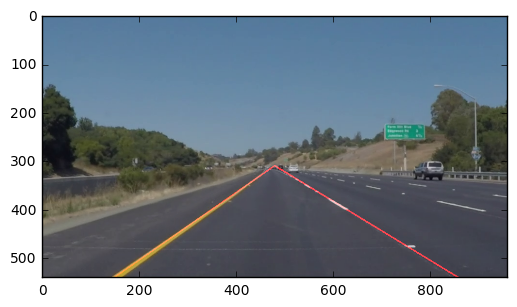

 36%|████████████████████████████▊                                                   | 246/682 [00:40<01:10,  6.15it/s]

In [73]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

I really enjoyed working on this project. I had no idea computer vision was such an exciting subject. I would really like to make the pipeline more robust and also make it a better representation of the lane lines. In the current code, the lines are intersecting because I plotted the lines using a common  intersecting point to find the slope. It could be improved by finding lane lines that are not intersecting. 


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))